In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = np.asarray(['highway','insidecity','tallbuilding','street','forest','coast','mountain','opencountry'])
folder = "./LabelMe/"

### Load Data and preprocess

In [4]:
#which X?? max could do overfitting


In [4]:
X_train_vgg16 = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

X_val_vgg16 = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

X_test_vgg16 = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",X_train_vgg16.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


In [5]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

In [40]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=False,with_std=False)  #do it ??
std.fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)
Xstd_train.shape

(1000, 512)

### Load annotations / Generate

In [6]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Loading AMT data...
Remove 18 annotators that do not annotate on this set 
Shape (data,annotators):  (1000, 59)
Classes:  8


In [7]:
#generate conf matrix...
confe_matrix = np.zeros((T,K,K),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix[t,:,:][~mask_nan],axis=0)
    for value in np.arange(K)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix[t,:,:] = confe_matrix[t,:,:]/confe_matrix[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix

array([[[0.7777778 , 0.11111111, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.78571427, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.23076923, 0.7692308 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.05555556,
         0.22222222, 0.5555556 ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.125     , 0.125     , 0.125     , ..., 0.125     ,
         0.125     , 0.125     ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0. 

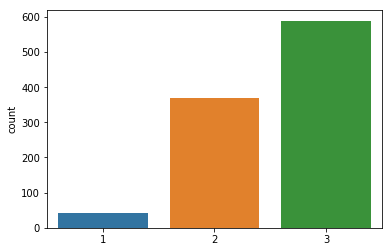

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


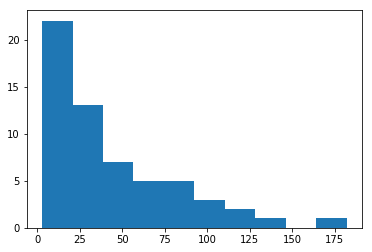

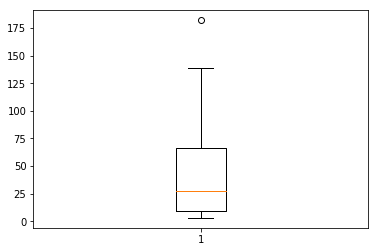

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182


In [7]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())

#### Delta Convergence criteria

In [8]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [9]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

Trained IDeal Model, Epochs to converge = 8


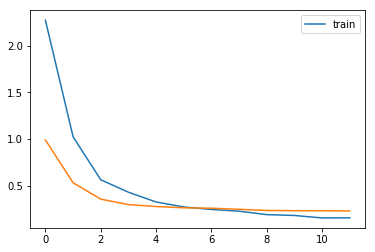

In [42]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [10]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas = label_I.mv_labels('probas')
mv_onehot = label_I.mv_labels('onehot')

if y_obs.shape[1] <= 3000:
    ds_labels,ds_conf = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -2837.6143296389882
2 	 -2762.646210244835 	0.0214	0.065072	0.026419
3 	 -2736.633208243355 	0.0117	0.059334	0.009416
4 	 -2725.378111119757 	0.0071	0.058779	0.004113
5 	 -2719.6973578268603 	0.0041	0.051646	0.002084
6 	 -2716.566654228873 	0.0027	0.040519	0.001151
7 	 -2714.775977808997 	0.0021	0.031279	0.000659
8 	 -2713.6296368849667 	0.0017	0.024918	0.000422
Class marginals
[0.08 0.11 0.14 0.11 0.14 0.14 0.17 0.09]


In [46]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.769
ACC D&S on train: 0.804


In [24]:
#check ds with  theones come with data
aux = np.loadtxt("./LabelMe/answers_DS.txt",dtype='int')
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train)) #calculated by Rodrigues (until converge)
print("Similaririty between ours and his: ",np.mean(ds_labels.argmax(axis=1) == aux))

ACC D&S on train: 0.804
Similaririty between ours and his:  0.966


In [11]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

Trained model over soft-MV, Epochs to converge = 12


In [107]:
model_mvhard = keras.models.clone_model(model_UB)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

Trained model over hard-MV, Epochs to converge = 13


In [22]:
model_ds = keras.models.clone_model(model_UB)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

Trained model over D&S, Epochs to converge = 7


### Raykar Model (joint predict model)

In [12]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (1000, 59, 8)


In [13]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=False,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(30,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.81 sec)	logL: -3101.304	
Iter 2/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -2736.565	Tol1: 0.11761	Tol2: 0.11227	
Iter 3/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2594.501	Tol1: 0.05191	Tol2: 0.04730	
Iter 4/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2513.285	Tol1: 0.03130	Tol2: 0.03237	
Iter 5/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2462.675	Tol1: 0.02014	Tol2: 0.02595	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.65 sec)	logL: -3091.133	
Iter 2/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2609.977	Tol1: 0.15566	Tol2: 0.08711	
Iter 3/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2457.280	Tol1: 0.05851	Tol2: 0.04105	
Iter 4/50 
M step: done,  E 

M step: done,  E step: done //  (in 0.74 sec)	logL: -3009.448	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -2607.771	Tol1: 0.13347	Tol2: 0.08820	
Iter 3/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2466.756	Tol1: 0.05407	Tol2: 0.04399	
Iter 4/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2402.907	Tol1: 0.02588	Tol2: 0.01918	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.55 sec)	logL: -3163.654	
Iter 2/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2678.429	Tol1: 0.15337	Tol2: 0.10301	
Iter 3/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2515.901	Tol1: 0.06068	Tol2: 0.04367	
Iter 4/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2439.133	Tol1: 0.03051	Tol2: 0.02476	
Iter 5/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2388.344	Tol1: 0.02082	Tol2: 0.01330	
Finished training
Initializing new EM...
Betas shape: 

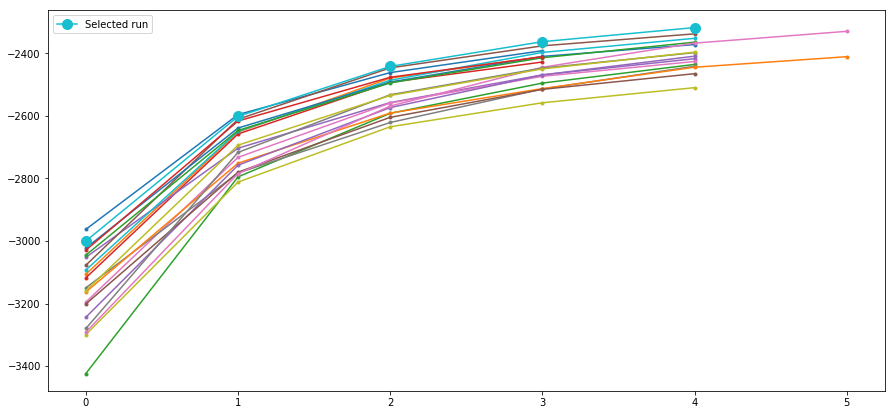

In [67]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [9]:
from code.MixtureofGroupsV2 import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 2 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
shape: (1000, 8)


In [35]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Normalized entropy (0-1) of repeats annotations: 0.11212816116784208


There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

In [10]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

for M_seted in range(2,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
        gMixture_Global.lambda_random = True 
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Wmean JS"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.005504 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.96552247 0.3891166 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -2866.735	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2150.394	Tol1: 0.24988	Tol2: 0.32061	Tol3: 0.06156	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1943.215	Tol1: 0.09634	Tol2: 0.12642	Tol3: 0.17143	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1835.853	Tol1: 0.05525	Tol2: 0.08494	Tol3: 0.16386	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.015	Tol1: 0.03314	Tol2: 0.04651	Tol3: 0.15420	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1733.844	Tol1: 0.02319	Tol2: 0.03424	Tol3: 0.12967	
Iter 7/50
M step: done,  E step: done //  (in 0.05 s

M step: done,  E step: done //  (in 0.06 sec)	logL: -1593.754	Tol1: 0.01988	Tol2: 0.04803	Tol3: 0.19053	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1565.649	Tol1: 0.01763	Tol2: 0.02968	Tol3: 0.17572	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3588294  0.96680355]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3277.453	
Iter 2/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -2312.270	Tol1: 0.29449	Tol2: 0.52077	Tol3: 0.15072	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2024.339	Tol1: 0.12452	Tol2: 0.14641	Tol3: 0.13356	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1900.085	Tol1: 0.06138	Tol2: 0.10469	Tol3: 0.17515	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1821.436	Tol1: 0.04139	Tol2: 0.05645	Tol3: 0.17998	
Iter 6/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1692.285	Tol1: 0.03387	Tol2: 0.05213	Tol3: 0.17611	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1646.003	Tol1: 0.02735	Tol2: 0.03378	Tol3: 0.15570	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1609.207	Tol1: 0.02235	Tol2: 0.02497	Tol3: 0.12436	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5865253  0.42636564]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2913.780	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2135.473	Tol1: 0.26711	Tol2: 0.33793	Tol3: 0.01437	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1918.604	Tol1: 0.10156	Tol2: 0.11347	Tol3: 0.16655	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1803.450	Tol1: 0.06002	Tol2: 0.08922	Tol3: 0.17492	
Iter 5/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.253	Tol1: 0.02934	Tol2: 0.03966	Tol3: 0.13803	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1673.646	Tol1: 0.01796	Tol2: 0.03455	Tol3: 0.10464	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1648.307	Tol1: 0.01514	Tol2: 0.01802	Tol3: 0.06985	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6283917  0.04192043]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3116.716	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2259.678	Tol1: 0.27498	Tol2: 0.34083	Tol3: 0.02162	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1986.559	Tol1: 0.12087	Tol2: 0.15432	Tol3: 0.15238	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1863.133	Tol1: 0.06213	Tol2: 0.09906	Tol3: 0.17212	
Iter 5/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.06 sec)	logL: -1714.928	Tol1: 0.03151	Tol2: 0.04995	Tol3: 0.14384	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1665.681	Tol1: 0.02872	Tol2: 0.02986	Tol3: 0.12160	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.39008605 0.57300794]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3264.333	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2290.358	Tol1: 0.29837	Tol2: 0.43555	Tol3: 0.13933	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1980.962	Tol1: 0.13509	Tol2: 0.15216	Tol3: 0.13124	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1835.278	Tol1: 0.07354	Tol2: 0.09531	Tol3: 0.18072	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1755.944	Tol1: 0.04323	Tol2: 0.06012	Tol3: 0.18534	
Iter 6/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1734.286	Tol1: 0.03482	Tol2: 0.05589	Tol3: 0.17016	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1676.997	Tol1: 0.03303	Tol2: 0.03805	Tol3: 0.14639	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1635.090	Tol1: 0.02499	Tol2: 0.02263	Tol3: 0.11553	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.5
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003291 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.71158385 0.37393713]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.73 sec)	logL: -3448.844	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2373.092	Tol1: 0.31192	Tol2: 0.46287	Tol3: 0.09911	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2057.310	Tol1: 0

M step: done,  E step: done //  (in 0.05 sec)	logL: -2322.557	Tol1: 0.30253	Tol2: 0.44094	Tol3: 0.11547	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2005.342	Tol1: 0.13658	Tol2: 0.13546	Tol3: 0.14477	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1886.072	Tol1: 0.05948	Tol2: 0.12281	Tol3: 0.17549	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.245	Tol1: 0.04179	Tol2: 0.06390	Tol3: 0.17010	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1742.450	Tol1: 0.03585	Tol2: 0.04574	Tol3: 0.15638	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1693.625	Tol1: 0.02802	Tol2: 0.03456	Tol3: 0.13063	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1656.998	Tol1: 0.02163	Tol2: 0.02938	Tol3: 0.09537	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.32752344 0.16232887]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
I

M step: done,  E step: done //  (in 0.70 sec)	logL: -3017.315	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2129.735	Tol1: 0.29416	Tol2: 0.49146	Tol3: 0.09522	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1920.327	Tol1: 0.09833	Tol2: 0.14266	Tol3: 0.16316	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1813.632	Tol1: 0.05556	Tol2: 0.08748	Tol3: 0.17689	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1753.443	Tol1: 0.03319	Tol2: 0.06094	Tol3: 0.17270	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1710.164	Tol1: 0.02468	Tol2: 0.03645	Tol3: 0.15786	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1674.794	Tol1: 0.02068	Tol2: 0.02797	Tol3: 0.12831	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43154415 0.6181669 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.08 sec)	logL: -1762.198	Tol1: 0.04993	Tol2: 0.04314	Tol3: 0.12778	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1701.139	Tol1: 0.03465	Tol2: 0.03404	Tol3: 0.10687	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1649.819	Tol1: 0.03017	Tol2: 0.03364	Tol3: 0.07368	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1617.433	Tol1: 0.01963	Tol2: 0.01444	Tol3: 0.04333	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.20724542 0.04938824]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3612.212	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2265.728	Tol1: 0.37276	Tol2: 0.60873	Tol3: 0.17037	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1935.223	Tol1: 0.14587	Tol2: 0.16354	Tol3: 0.14927	
Iter 4/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.60 sec)	logL: -3247.872	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2275.741	Tol1: 0.29931	Tol2: 0.48971	Tol3: 0.12364	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2063.268	Tol1: 0.09336	Tol2: 0.14947	Tol3: 0.16846	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1961.146	Tol1: 0.04950	Tol2: 0.08173	Tol3: 0.16079	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1891.629	Tol1: 0.03545	Tol2: 0.05368	Tol3: 0.15668	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1842.023	Tol1: 0.02622	Tol2: 0.04712	Tol3: 0.14597	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1801.986	Tol1: 0.02174	Tol2: 0.03643	Tol3: 0.12398	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1772.619	Tol1: 0.01630	Tol2: 0.02239	Tol3: 0.09595	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3899266  0.48693463]
Alphas:  

M step: done,  E step: done //  (in 0.57 sec)	logL: -2842.457	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2016.487	Tol1: 0.29058	Tol2: 0.34295	Tol3: 0.00247	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1826.785	Tol1: 0.09408	Tol2: 0.14575	Tol3: 0.14545	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1772.921	Tol1: 0.02949	Tol2: 0.07039	Tol3: 0.16018	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1725.506	Tol1: 0.02674	Tol2: 0.04368	Tol3: 0.15353	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1688.352	Tol1: 0.02153	Tol2: 0.02816	Tol3: 0.14181	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.38074583 0.47364804]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -3035.882	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2110.327	Tol1: 0.30487

M step: done,  E step: done //  (in 0.05 sec)	logL: -1848.262	Tol1: 0.04990	Tol2: 0.08898	Tol3: 0.16584	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1773.529	Tol1: 0.04043	Tol2: 0.06649	Tol3: 0.15838	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.740	Tol1: 0.02751	Tol2: 0.04692	Tol3: 0.14125	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1678.275	Tol1: 0.02694	Tol2: 0.03441	Tol3: 0.11062	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1641.276	Tol1: 0.02205	Tol2: 0.03237	Tol3: 0.07816	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1616.668	Tol1: 0.01499	Tol2: 0.02108	Tol3: 0.04724	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.04284675 0.0868606 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3275.564	
Iter 2/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.06 sec)	logL: -2095.843	Tol1: 0.26861	Tol2: 0.49576	Tol3: 0.10453	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1896.201	Tol1: 0.09526	Tol2: 0.15917	Tol3: 0.11489	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1790.647	Tol1: 0.05567	Tol2: 0.09256	Tol3: 0.16708	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1729.016	Tol1: 0.03442	Tol2: 0.05438	Tol3: 0.18335	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1685.491	Tol1: 0.02517	Tol2: 0.03919	Tol3: 0.17081	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.967	Tol1: 0.01811	Tol2: 0.02588	Tol3: 0.14020	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.98572004 0.7063874 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2926.498	
Iter 2/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.62 sec)	logL: -3486.691	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2310.549	Tol1: 0.33732	Tol2: 0.67914	Tol3: 0.36349	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1989.274	Tol1: 0.13905	Tol2: 0.15692	Tol3: 0.13437	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1864.898	Tol1: 0.06252	Tol2: 0.11963	Tol3: 0.18626	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1768.104	Tol1: 0.05190	Tol2: 0.05879	Tol3: 0.19044	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1692.469	Tol1: 0.04278	Tol2: 0.04815	Tol3: 0.18962	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1631.130	Tol1: 0.03624	Tol2: 0.03629	Tol3: 0.16263	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1583.649	Tol1: 0.02911	Tol2: 0.02864	Tol3: 0.11682	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.49970928 0.43696994]
Alphas:  

M step: done,  E step: done //  (in 0.59 sec)	logL: -2735.647	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2038.331	Tol1: 0.25490	Tol2: 0.30375	Tol3: 0.04183	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1869.048	Tol1: 0.08305	Tol2: 0.11171	Tol3: 0.18917	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1786.446	Tol1: 0.04419	Tol2: 0.07988	Tol3: 0.18356	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1723.749	Tol1: 0.03510	Tol2: 0.04450	Tol3: 0.16917	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1669.676	Tol1: 0.03137	Tol2: 0.03227	Tol3: 0.13708	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1619.230	Tol1: 0.03021	Tol2: 0.02639	Tol3: 0.09594	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1582.316	Tol1: 0.02280	Tol2: 0.01387	Tol3: 0.05887	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8552909  0.01621298]
Alphas:  

M step: done,  E step: done //  (in 0.05 sec)	logL: -1582.331	Tol1: 0.01951	Tol2: 0.02050	Tol3: 0.14981	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.06328161 0.27501023]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3706.557	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2324.538	Tol1: 0.37286	Tol2: 1.04882	Tol3: 0.56441	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2047.186	Tol1: 0.11931	Tol2: 0.19813	Tol3: 0.06190	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1940.980	Tol1: 0.05188	Tol2: 0.11105	Tol3: 0.14941	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1884.376	Tol1: 0.02916	Tol2: 0.08579	Tol3: 0.17020	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1827.435	Tol1: 0.03022	Tol2: 0.07075	Tol3: 0.17565	
Iter 7/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1709.461	Tol1: 0.02292	Tol2: 0.02318	Tol3: 0.10043	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.83470786 0.8670463 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3084.127	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2172.534	Tol1: 0.29558	Tol2: 0.28104	Tol3: 0.06576	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1971.823	Tol1: 0.09239	Tol2: 0.13260	Tol3: 0.17739	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1859.177	Tol1: 0.05713	Tol2: 0.07921	Tol3: 0.16956	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1776.570	Tol1: 0.04443	Tol2: 0.04710	Tol3: 0.15552	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1733.067	Tol1: 0.02449	Tol2: 0.03779	Tol3: 0.13537	
Iter 7/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1615.431	Tol1: 0.02817	Tol2: 0.02473	Tol3: 0.10279	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9236547 0.5580211]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2770.851	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2128.883	Tol1: 0.23169	Tol2: 0.32923	Tol3: 0.08227	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1954.821	Tol1: 0.08176	Tol2: 0.11433	Tol3: 0.18453	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1864.984	Tol1: 0.04596	Tol2: 0.07216	Tol3: 0.17492	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1795.559	Tol1: 0.03723	Tol2: 0.05040	Tol3: 0.15185	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -1744.691	Tol1: 0.02833	Tol2: 0.03147	Tol3: 0.13067	
Iter 7/50
M step: done,  E step: done //  (in

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.21885294 0.3699984 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3219.408	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2192.688	Tol1: 0.31892	Tol2: 0.64418	Tol3: 0.23946	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1990.234	Tol1: 0.09233	Tol2: 0.15563	Tol3: 0.11352	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1874.871	Tol1: 0.05796	Tol2: 0.12115	Tol3: 0.15737	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1817.433	Tol1: 0.03064	Tol2: 0.06872	Tol3: 0.17456	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1775.352	Tol1: 0.02315	Tol2: 0.03958	Tol3: 0.16676	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1744.539	Tol1: 0.01736	Tol2: 0.02816	Tol3: 0.15274	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14384295 0.15766387]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3105.967	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2089.042	Tol1: 0.32741	Tol2: 0.54142	Tol3: 0.15541	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1874.945	Tol1: 0.10249	Tol2: 0.15399	Tol3: 0.11851	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1770.639	Tol1: 0.05563	Tol2: 0.11102	Tol3: 0.15456	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1712.318	Tol1: 0.03294	Tol2: 0.06217	Tol3: 0.17028	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1670.124	Tol1: 0.02464	Tol2: 0.03528	Tol3: 0.16587	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1636.759	Tol1: 0.01998	Tol2: 0.02151	Tol3: 0.14317	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1685.078	Tol1: 0.01199	Tol2: 0.02412	Tol3: 0.13649	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3545606  0.39803272]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3080.775	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2098.110	Tol1: 0.31897	Tol2: 0.50436	Tol3: 0.11964	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1897.252	Tol1: 0.09573	Tol2: 0.18083	Tol3: 0.16101	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1775.371	Tol1: 0.06424	Tol2: 0.08766	Tol3: 0.17474	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1719.918	Tol1: 0.03123	Tol2: 0.04922	Tol3: 0.17813	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1692.947	Tol1: 0.01568	Tol2: 0.03054	Tol3: 0.15580	
Iter 7/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.07 sec)	logL: -1740.509	Tol1: 0.02677	Tol2: 0.04729	Tol3: 0.15046	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1694.390	Tol1: 0.02650	Tol2: 0.03069	Tol3: 0.13433	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.458	Tol1: 0.02062	Tol2: 0.04197	Tol3: 0.11394	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1630.356	Tol1: 0.01754	Tol2: 0.03890	Tol3: 0.07896	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1601.671	Tol1: 0.01759	Tol2: 0.02489	Tol3: 0.05257	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5918753 0.2810693]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2833.250	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2086.645	Tol1: 0.26352	Tol2: 0.27104	Tol3: 0.09918	
Iter 3/50
M step: done,  E step: done //  (i

M step: done,  E step: done //  (in 0.07 sec)	logL: -1849.448	Tol1: 0.04712	Tol2: 0.05351	Tol3: 0.15948	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1792.473	Tol1: 0.03081	Tol2: 0.04548	Tol3: 0.14215	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1725.276	Tol1: 0.03749	Tol2: 0.02681	Tol3: 0.11266	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1659.456	Tol1: 0.03815	Tol2: 0.02396	Tol3: 0.07602	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1615.674	Tol1: 0.02638	Tol2: 0.02157	Tol3: 0.04288	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.81346136 0.02177021]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2801.638	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2185.433	Tol1: 0.21994	Tol2: 0.41844	Tol3: 0.01720	
Iter 3/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1751.844	Tol1: 0.02304	Tol2: 0.03944	Tol3: 0.13273	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.921	Tol1: 0.02279	Tol2: 0.03214	Tol3: 0.09750	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1674.039	Tol1: 0.02213	Tol2: 0.02323	Tol3: 0.06420	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.9
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.004374 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14388724 0.09362858]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -3171.772	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2155.031	Tol1: 0.32056	Tol2: 0.66086	Tol3: 0.19876	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1922.650	Tol1: 0

M step: done,  E step: done //  (in 0.05 sec)	logL: -2023.813	Tol1: 0.11741	Tol2: 0.13379	Tol3: 0.14456	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1923.096	Tol1: 0.04977	Tol2: 0.10309	Tol3: 0.15703	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1843.815	Tol1: 0.04123	Tol2: 0.06256	Tol3: 0.15207	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1786.764	Tol1: 0.03094	Tol2: 0.04041	Tol3: 0.14785	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1742.733	Tol1: 0.02464	Tol2: 0.02947	Tol3: 0.13214	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5342573  0.09592118]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2935.050	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2153.817	Tol1: 0.26617	Tol2: 0.40038	Tol3: 0.03564	
Iter 3/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1840.935	Tol1: 0.07013	Tol2: 0.09682	Tol3: 0.15917	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1763.335	Tol1: 0.04215	Tol2: 0.05608	Tol3: 0.16021	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1702.961	Tol1: 0.03424	Tol2: 0.03525	Tol3: 0.15385	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.620	Tol1: 0.02780	Tol2: 0.03107	Tol3: 0.13760	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1624.518	Tol1: 0.01879	Tol2: 0.02298	Tol3: 0.10721	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.50551385 0.84212005]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3355.642	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2277.325	Tol1: 0.32134	Tol2: 0.44209	Tol3: 0.16107	
Iter 3/50
M step: done,  E step: done //  (

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.979701   0.0762663  0.19884287]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3234.358	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2204.345	Tol1: 0.31846	Tol2: 0.50683	Tol3: 0.27321	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1985.629	Tol1: 0.09922	Tol2: 0.16884	Tol3: 0.17303	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1862.796	Tol1: 0.06186	Tol2: 0.08971	Tol3: 0.20159	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1796.463	Tol1: 0.03561	Tol2: 0.07095	Tol3: 0.21845	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1740.773	Tol1: 0.03100	Tol2: 0.05335	Tol3: 0.21613	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1682.858	Tol1: 0.03327	Tol2: 0.04218	Tol3: 0.20506	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1

M step: done,  E step: done //  (in 0.05 sec)	logL: -1911.168	Tol1: 0.05072	Tol2: 0.08989	Tol3: 0.21974	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1814.450	Tol1: 0.05061	Tol2: 0.06195	Tol3: 0.22730	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1735.777	Tol1: 0.04336	Tol2: 0.04406	Tol3: 0.21739	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1685.331	Tol1: 0.02906	Tol2: 0.03056	Tol3: 0.19022	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1641.945	Tol1: 0.02574	Tol2: 0.02034	Tol3: 0.15362	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.08414245 0.9197252  0.9387418 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3129.661	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2247.462	Tol1: 0.28188	Tol2: 0.38472	Tol3: 0.04611	
Iter 3/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -2092.061	Tol1: 0.28899	Tol2: 0.37855	Tol3: 0.01002	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1884.401	Tol1: 0.09926	Tol2: 0.13099	Tol3: 0.20154	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1771.015	Tol1: 0.06017	Tol2: 0.07526	Tol3: 0.22001	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1713.257	Tol1: 0.03261	Tol2: 0.06399	Tol3: 0.23359	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1663.160	Tol1: 0.02924	Tol2: 0.04523	Tol3: 0.22200	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1623.136	Tol1: 0.02407	Tol2: 0.02643	Tol3: 0.19612	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.73146796 0.35976592 0.40191028]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3966.514	
Iter 2/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1529.133	Tol1: 0.01907	Tol2: 0.02681	Tol3: 0.18854	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9372173  0.5563962  0.46930882]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -3229.696	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2180.764	Tol1: 0.32478	Tol2: 0.40449	Tol3: 0.12013	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1958.385	Tol1: 0.10197	Tol2: 0.13954	Tol3: 0.21675	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1858.199	Tol1: 0.05116	Tol2: 0.08148	Tol3: 0.22835	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1784.371	Tol1: 0.03973	Tol2: 0.05450	Tol3: 0.22629	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1738.667	Tol1: 0.02561	Tol2: 0.04202	Tol3: 0.22163	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.803	Tol1: 0.06114	Tol2: 0.11188	Tol3: 0.20809	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1797.059	Tol1: 0.03061	Tol2: 0.07553	Tol3: 0.22541	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1749.878	Tol1: 0.02625	Tol2: 0.05255	Tol3: 0.22395	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1702.618	Tol1: 0.02701	Tol2: 0.03777	Tol3: 0.21179	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1656.443	Tol1: 0.02712	Tol2: 0.02690	Tol3: 0.19599	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.96987844 0.592069   0.5837409 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3074.111	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2161.679	Tol1: 0.29681	Tol2: 0.33823	Tol3: 0.04029	
Iter 3/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1634.726	Tol1: 0.02577	Tol2: 0.02510	Tol3: 0.17962	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.71383464 0.01565256 0.02151622]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3745.003	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2297.289	Tol1: 0.38657	Tol2: 0.98143	Tol3: 0.83046	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2012.227	Tol1: 0.12409	Tol2: 0.26322	Tol3: 0.09973	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1901.109	Tol1: 0.05522	Tol2: 0.12606	Tol3: 0.16163	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1829.821	Tol1: 0.03750	Tol2: 0.09488	Tol3: 0.19454	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1780.930	Tol1: 0.02672	Tol2: 0.06841	Tol3: 0.21164	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1646.103	Tol1: 0.03238	Tol2: 0.06358	Tol3: 0.24711	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1603.618	Tol1: 0.02581	Tol2: 0.04045	Tol3: 0.21892	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1566.499	Tol1: 0.02315	Tol2: 0.02543	Tol3: 0.19050	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6180123  0.92803144 0.9256954 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3326.531	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2482.022	Tol1: 0.25387	Tol2: 0.47072	Tol3: 0.15292	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2234.021	Tol1: 0.09992	Tol2: 0.14415	Tol3: 0.18652	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2079.429	Tol1: 0.06920	Tol2: 0.10948	Tol3: 0.22336	
Iter 5/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1822.405	Tol1: 0.11692	Tol2: 0.13126	Tol3: 0.18555	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1711.760	Tol1: 0.06071	Tol2: 0.09941	Tol3: 0.22687	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1658.911	Tol1: 0.03087	Tol2: 0.07045	Tol3: 0.23291	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1620.928	Tol1: 0.02290	Tol2: 0.04751	Tol3: 0.22875	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1587.245	Tol1: 0.02078	Tol2: 0.03149	Tol3: 0.20975	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1556.838	Tol1: 0.01916	Tol2: 0.02802	Tol3: 0.17901	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14270313 0.1689911  0.92311114]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3000.180	
Iter 2/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.68 sec)	logL: -2974.815	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2109.514	Tol1: 0.29088	Tol2: 0.45159	Tol3: 0.13302	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1894.006	Tol1: 0.10216	Tol2: 0.14016	Tol3: 0.18086	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1802.991	Tol1: 0.04805	Tol2: 0.10370	Tol3: 0.21261	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1750.315	Tol1: 0.02922	Tol2: 0.06326	Tol3: 0.21813	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1702.509	Tol1: 0.02731	Tol2: 0.04572	Tol3: 0.21890	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1665.056	Tol1: 0.02200	Tol2: 0.03416	Tol3: 0.21184	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.818	Tol1: 0.02417	Tol2: 0.03062	Tol3: 0.18356	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1589.135	Tol1: 0.02196	Tol2: 0.01942	Tol3: 0.15112	
Finished training

M step: done,  E step: done //  (in 0.05 sec)	logL: -1800.600	Tol1: 0.02661	Tol2: 0.06131	Tol3: 0.22422	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1743.931	Tol1: 0.03147	Tol2: 0.04120	Tol3: 0.21465	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1704.315	Tol1: 0.02272	Tol2: 0.03159	Tol3: 0.19733	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1671.441	Tol1: 0.01929	Tol2: 0.02402	Tol3: 0.16226	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.77220297 0.38693282 0.25618717]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -2512.413	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1949.101	Tol1: 0.22421	Tol2: 0.32420	Tol3: 0.05763	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1794.488	Tol1: 0.07933	Tol2: 0.11841	Tol3: 0.20424	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1625.626	Tol1: 0.01783	Tol2: 0.02533	Tol3: 0.16972	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0589733  0.29328567 0.8236655 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2883.078	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2109.527	Tol1: 0.26831	Tol2: 0.36015	Tol3: 0.06473	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1965.912	Tol1: 0.06808	Tol2: 0.12887	Tol3: 0.23568	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1867.670	Tol1: 0.04997	Tol2: 0.07611	Tol3: 0.22458	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1792.587	Tol1: 0.04020	Tol2: 0.05119	Tol3: 0.22570	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1733.417	Tol1: 0.03301	Tol2: 0.03314	Tol3: 0.20562	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -2166.549	Tol1: 0.25862	Tol2: 0.37590	Tol3: 0.04208	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1974.842	Tol1: 0.08848	Tol2: 0.15966	Tol3: 0.21268	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1876.325	Tol1: 0.04989	Tol2: 0.08450	Tol3: 0.22400	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1805.912	Tol1: 0.03753	Tol2: 0.06134	Tol3: 0.22721	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1756.902	Tol1: 0.02714	Tol2: 0.04156	Tol3: 0.21961	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1700.319	Tol1: 0.03221	Tol2: 0.03070	Tol3: 0.19159	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1647.938	Tol1: 0.03081	Tol2: 0.01981	Tol3: 0.16005	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1605.172	Tol1: 0.02595	Tol2: 0.01420	Tol3: 0.11991	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -3013.662	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2139.604	Tol1: 0.29003	Tol2: 0.52015	Tol3: 0.26916	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1904.354	Tol1: 0.10995	Tol2: 0.11813	Tol3: 0.16191	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1803.279	Tol1: 0.05308	Tol2: 0.12615	Tol3: 0.21443	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1741.769	Tol1: 0.03411	Tol2: 0.07537	Tol3: 0.22590	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1696.593	Tol1: 0.02594	Tol2: 0.04894	Tol3: 0.22397	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.519	Tol1: 0.02421	Tol2: 0.03907	Tol3: 0.21258	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1614.741	Tol1: 0.02463	Tol2: 0.02877	Tol3: 0.18767	
Finished training!
Initializing new EM...

M step: done,  E step: done //  (in 0.57 sec)	logL: -3205.488	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2340.654	Tol1: 0.26980	Tol2: 0.50310	Tol3: 0.34365	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2092.334	Tol1: 0.10609	Tol2: 0.15228	Tol3: 0.11009	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1997.471	Tol1: 0.04534	Tol2: 0.10656	Tol3: 0.20561	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1946.697	Tol1: 0.02542	Tol2: 0.07295	Tol3: 0.22172	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1878.804	Tol1: 0.03488	Tol2: 0.05396	Tol3: 0.22147	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1812.270	Tol1: 0.03541	Tol2: 0.04538	Tol3: 0.22315	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1748.076	Tol1: 0.03542	Tol2: 0.03626	Tol3: 0.20833	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1701.556	Tol1: 0.02661	Tol2: 0.02787	Tol3: 0.18077	
Finished training

M step: done,  E step: done //  (in 0.05 sec)	logL: -1816.630	Tol1: 0.05010	Tol2: 0.08793	Tol3: 0.25490	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1755.997	Tol1: 0.03338	Tol2: 0.05559	Tol3: 0.23517	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1706.423	Tol1: 0.02823	Tol2: 0.03321	Tol3: 0.21557	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.590	Tol1: 0.02686	Tol2: 0.02566	Tol3: 0.17930	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.35710385 0.28396118 0.06032276]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3327.661	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2095.414	Tol1: 0.37030	Tol2: 0.65322	Tol3: 0.44669	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1864.507	Tol1: 0.11020	Tol2: 0.20883	Tol3: 0.16855	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1756.581	Tol1: 0.03160	Tol2: 0.05443	Tol3: 0.21235	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1725.631	Tol1: 0.01762	Tol2: 0.03840	Tol3: 0.20790	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.631	Tol1: 0.02782	Tol2: 0.03127	Tol3: 0.18323	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1638.625	Tol1: 0.02325	Tol2: 0.02269	Tol3: 0.15003	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31149498 0.6444805  0.20127423]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -3569.106	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2323.314	Tol1: 0.34905	Tol2: 0.65180	Tol3: 0.51117	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2079.821	Tol1: 0.10480	Tol2: 0.17798	Tol3: 0.13566	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1669.706	Tol1: 0.01454	Tol2: 0.03804	Tol3: 0.21710	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1638.953	Tol1: 0.01842	Tol2: 0.02726	Tol3: 0.19638	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8849832  0.6819309  0.46740988]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -3206.120	
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -2246.415	Tol1: 0.29934	Tol2: 0.42800	Tol3: 0.19084	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1973.207	Tol1: 0.12162	Tol2: 0.14033	Tol3: 0.19835	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1841.131	Tol1: 0.06693	Tol2: 0.11330	Tol3: 0.24530	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1768.176	Tol1: 0.03963	Tol2: 0.07393	Tol3: 0.24589	
Iter 6/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -2192.557	Tol1: 0.08890	Tol2: 0.16337	Tol3: 0.17028	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2067.048	Tol1: 0.05724	Tol2: 0.09609	Tol3: 0.20913	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1946.453	Tol1: 0.05834	Tol2: 0.07246	Tol3: 0.21466	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1861.279	Tol1: 0.04376	Tol2: 0.05445	Tol3: 0.22573	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1796.374	Tol1: 0.03487	Tol2: 0.04205	Tol3: 0.21604	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1748.230	Tol1: 0.02680	Tol2: 0.02871	Tol3: 0.19831	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.29428628 0.1432996  0.12521166]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3245.039	
Iter 2/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.08 sec)	logL: -1861.357	Tol1: 0.03503	Tol2: 0.07366	Tol3: 0.23025	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1811.723	Tol1: 0.02667	Tol2: 0.04578	Tol3: 0.21051	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1764.447	Tol1: 0.02609	Tol2: 0.02661	Tol3: 0.18589	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.962392   0.10540567 0.7932843 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2834.768	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2137.426	Tol1: 0.24600	Tol2: 0.27618	Tol3: 0.08990	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1913.068	Tol1: 0.10497	Tol2: 0.12781	Tol3: 0.24383	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1787.576	Tol1: 0.06560	Tol2: 0.09030	Tol3: 0.24935	
Iter 5/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1604.823	Tol1: 0.02420	Tol2: 0.02032	Tol3: 0.14169	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6364485  0.8321601  0.20738555]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3201.778	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2307.500	Tol1: 0.27931	Tol2: 0.53933	Tol3: 0.26369	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2036.346	Tol1: 0.11751	Tol2: 0.13836	Tol3: 0.09655	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1928.486	Tol1: 0.05297	Tol2: 0.09547	Tol3: 0.20651	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.285	Tol1: 0.03899	Tol2: 0.07265	Tol3: 0.22288	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1790.424	Tol1: 0.03392	Tol2: 0.05593	Tol3: 0.22752	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1658.062	Tol1: 0.01820	Tol2: 0.02012	Tol3: 0.16108	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.18808433 0.13127816 0.5542387 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3350.546	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2227.025	Tol1: 0.33532	Tol2: 0.47885	Tol3: 0.11546	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2030.620	Tol1: 0.08819	Tol2: 0.14859	Tol3: 0.22170	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1903.764	Tol1: 0.06247	Tol2: 0.09923	Tol3: 0.21129	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1821.674	Tol1: 0.04312	Tol2: 0.07076	Tol3: 0.21904	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1761.095	Tol1: 0.03325	Tol2: 0.04414	Tol3: 0.21709	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1723.954	Tol1: 0.03450	Tol2: 0.06831	Tol3: 0.21474	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.593	Tol1: 0.02689	Tol2: 0.04865	Tol3: 0.21918	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1627.535	Tol1: 0.02984	Tol2: 0.03861	Tol3: 0.20670	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1588.250	Tol1: 0.02414	Tol2: 0.02579	Tol3: 0.17938	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.32747912 0.2581077  0.82299167]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3163.125	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2273.465	Tol1: 0.28126	Tol2: 0.41425	Tol3: 0.05308	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2000.489	Tol1: 0.12007	Tol2: 0.17147	Tol3: 0.23166	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -2154.875	Tol1: 0.28783	Tol2: 0.52474	Tol3: 0.24258	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1909.553	Tol1: 0.11385	Tol2: 0.15327	Tol3: 0.13974	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1802.193	Tol1: 0.05622	Tol2: 0.09918	Tol3: 0.21098	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1728.693	Tol1: 0.04078	Tol2: 0.07367	Tol3: 0.22391	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1672.328	Tol1: 0.03261	Tol2: 0.05405	Tol3: 0.22889	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1626.810	Tol1: 0.02722	Tol2: 0.04038	Tol3: 0.22091	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1586.202	Tol1: 0.02496	Tol2: 0.02635	Tol3: 0.19563	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.26036173 0.41584948 0.25775844]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000,

M step: done,  E step: done //  (in 0.05 sec)	logL: -1816.354	Tol1: 0.03005	Tol2: 0.05449	Tol3: 0.21476	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1758.947	Tol1: 0.03161	Tol2: 0.04664	Tol3: 0.21319	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1716.737	Tol1: 0.02400	Tol2: 0.03454	Tol3: 0.20362	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1679.677	Tol1: 0.02159	Tol2: 0.02374	Tol3: 0.17887	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9229029  0.5238088  0.08432041]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3328.213	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2105.879	Tol1: 0.36726	Tol2: 0.53667	Tol3: 0.30492	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1889.761	Tol1: 0.10263	Tol2: 0.16309	Tol3: 0.15255	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.55 sec)	logL: -3010.131	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2162.575	Tol1: 0.28157	Tol2: 0.38221	Tol3: 0.05200	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1961.882	Tol1: 0.09280	Tol2: 0.12973	Tol3: 0.21749	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1834.860	Tol1: 0.06474	Tol2: 0.08897	Tol3: 0.21977	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1763.787	Tol1: 0.03873	Tol2: 0.05646	Tol3: 0.23307	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1718.956	Tol1: 0.02542	Tol2: 0.04264	Tol3: 0.21871	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1683.199	Tol1: 0.02080	Tol2: 0.02740	Tol3: 0.18326	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4010799 0.4379352 0.6050317]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.05 sec)	logL: -1648.267	Tol1: 0.02111	Tol2: 0.02633	Tol3: 0.18121	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8321763  0.55722404 0.4077702 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -2899.868	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2004.722	Tol1: 0.30868	Tol2: 0.33625	Tol3: 0.03488	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1791.835	Tol1: 0.10619	Tol2: 0.11687	Tol3: 0.23507	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1717.386	Tol1: 0.04155	Tol2: 0.09029	Tol3: 0.23484	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1663.958	Tol1: 0.03111	Tol2: 0.06133	Tol3: 0.22967	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.106	Tol1: 0.02395	Tol2: 0.04256	Tol3: 0.21696	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1865.787	Tol1: 0.10333	Tol2: 0.13847	Tol3: 0.14512	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.914	Tol1: 0.05460	Tol2: 0.10300	Tol3: 0.19601	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1731.976	Tol1: 0.01811	Tol2: 0.08301	Tol3: 0.21299	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1694.755	Tol1: 0.02149	Tol2: 0.05194	Tol3: 0.21362	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.091	Tol1: 0.02045	Tol2: 0.04277	Tol3: 0.21128	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1630.846	Tol1: 0.01762	Tol2: 0.02615	Tol3: 0.19168	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.40425703 0.7388222  0.14905687]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -3478.619	
Iter 2/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -2192.645	Tol1: 0.23516	Tol2: 0.31309	Tol3: 0.08153	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1986.850	Tol1: 0.09386	Tol2: 0.11088	Tol3: 0.19317	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1905.150	Tol1: 0.04112	Tol2: 0.07488	Tol3: 0.20338	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1838.821	Tol1: 0.03482	Tol2: 0.04775	Tol3: 0.18653	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.157	Tol1: 0.03462	Tol2: 0.03934	Tol3: 0.16622	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1727.117	Tol1: 0.02706	Tol2: 0.03880	Tol3: 0.13380	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1694.847	Tol1: 0.01868	Tol2: 0.03431	Tol3: 0.10469	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1658.345	Tol1: 0.02154	Tol2: 0.03467	Tol3: 0.07905	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1622.858	Tol1: 0.02140	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1634.541	Tol1: 0.01792	Tol2: 0.03270	Tol3: 0.08663	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1603.584	Tol1: 0.01894	Tol2: 0.03127	Tol3: 0.07867	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1580.743	Tol1: 0.01424	Tol2: 0.03593	Tol3: 0.07828	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1555.443	Tol1: 0.01601	Tol2: 0.03459	Tol3: 0.07990	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1531.515	Tol1: 0.01538	Tol2: 0.03415	Tol3: 0.08411	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1513.645	Tol1: 0.01167	Tol2: 0.03037	Tol3: 0.09229	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1489.510	Tol1: 0.01594	Tol2: 0.02739	Tol3: 0.09416	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.27749896 0.49039638 0.958457   0.31943622]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1753.130	Tol1: 0.03834	Tol2: 0.06633	Tol3: 0.21388	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1695.234	Tol1: 0.03302	Tol2: 0.04911	Tol3: 0.21395	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1649.839	Tol1: 0.02678	Tol2: 0.03927	Tol3: 0.19583	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1606.928	Tol1: 0.02601	Tol2: 0.03683	Tol3: 0.16087	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1576.273	Tol1: 0.01908	Tol2: 0.03627	Tol3: 0.13074	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1540.467	Tol1: 0.02272	Tol2: 0.03533	Tol3: 0.09855	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1509.416	Tol1: 0.02016	Tol2: 0.03544	Tol3: 0.08960	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1482.400	Tol1: 0.01790	Tol2: 0.04199	Tol3: 0.08798	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1460.199	Tol1: 0.01498	

M step: done,  E step: done //  (in 0.05 sec)	logL: -1976.599	Tol1: 0.09972	Tol2: 0.12343	Tol3: 0.17798	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1860.461	Tol1: 0.05876	Tol2: 0.07087	Tol3: 0.19704	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1781.563	Tol1: 0.04241	Tol2: 0.05793	Tol3: 0.20556	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1735.548	Tol1: 0.02583	Tol2: 0.04040	Tol3: 0.17436	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1698.604	Tol1: 0.02129	Tol2: 0.03921	Tol3: 0.14056	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1663.988	Tol1: 0.02038	Tol2: 0.03160	Tol3: 0.10452	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1623.202	Tol1: 0.02451	Tol2: 0.03393	Tol3: 0.08223	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1595.458	Tol1: 0.01709	Tol2: 0.03708	Tol3: 0.06728	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1565.267	Tol1: 0.01892	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -1787.284	Tol1: 0.02310	Tol2: 0.03145	Tol3: 0.14329	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1725.754	Tol1: 0.03443	Tol2: 0.03090	Tol3: 0.11562	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1677.705	Tol1: 0.02784	Tol2: 0.03861	Tol3: 0.09521	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1645.590	Tol1: 0.01914	Tol2: 0.03723	Tol3: 0.07328	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1619.154	Tol1: 0.01607	Tol2: 0.03272	Tol3: 0.06456	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1595.604	Tol1: 0.01454	Tol2: 0.03400	Tol3: 0.06361	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1577.506	Tol1: 0.01134	Tol2: 0.03949	Tol3: 0.06616	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1559.839	Tol1: 0.01120	Tol2: 0.03334	Tol3: 0.07463	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1535.719	Tol1: 0.0154

M step: done,  E step: done //  (in 0.05 sec)	logL: -1666.737	Tol1: 0.03670	Tol2: 0.03929	Tol3: 0.15519	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1620.586	Tol1: 0.02769	Tol2: 0.03754	Tol3: 0.11216	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1584.236	Tol1: 0.02243	Tol2: 0.03461	Tol3: 0.08508	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1551.592	Tol1: 0.02061	Tol2: 0.03785	Tol3: 0.07550	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1521.350	Tol1: 0.01949	Tol2: 0.03797	Tol3: 0.07377	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1496.060	Tol1: 0.01662	Tol2: 0.03931	Tol3: 0.07323	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1472.299	Tol1: 0.01588	Tol2: 0.03930	Tol3: 0.08128	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1447.850	Tol1: 0.01661	Tol2: 0.03479	Tol3: 0.08962	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1423.800	Tol1: 0.0166

M step: done,  E step: done //  (in 0.07 sec)	logL: -2079.550	Tol1: 0.26210	Tol2: 0.42150	Tol3: 0.01687	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1886.948	Tol1: 0.09262	Tol2: 0.12908	Tol3: 0.18621	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1783.540	Tol1: 0.05480	Tol2: 0.07885	Tol3: 0.20344	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.343	Tol1: 0.03319	Tol2: 0.05745	Tol3: 0.20394	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1687.065	Tol1: 0.02162	Tol2: 0.04195	Tol3: 0.18530	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1648.285	Tol1: 0.02299	Tol2: 0.03142	Tol3: 0.15015	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1616.257	Tol1: 0.01943	Tol2: 0.03157	Tol3: 0.11562	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1579.975	Tol1: 0.02245	Tol2: 0.03087	Tol3: 0.09240	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1553.017	Tol1: 0.01706	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1540.625	Tol1: 0.01725	Tol2: 0.03453	Tol3: 0.07720	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1514.667	Tol1: 0.01685	Tol2: 0.03980	Tol3: 0.07535	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1490.832	Tol1: 0.01574	Tol2: 0.03703	Tol3: 0.07675	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1469.266	Tol1: 0.01447	Tol2: 0.03284	Tol3: 0.08332	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1451.129	Tol1: 0.01234	Tol2: 0.02854	Tol3: 0.09194	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.23270856 0.77391607 0.8154858  0.64697784]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3214.861	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2408.409	Tol1: 0.25085	Tol2: 0.48660	Tol3: 0.04617	
Iter 3/50
M step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1614.852	Tol1: 0.01929	Tol2: 0.03700	Tol3: 0.07807	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1581.727	Tol1: 0.02051	Tol2: 0.03940	Tol3: 0.07629	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1549.747	Tol1: 0.02022	Tol2: 0.03893	Tol3: 0.07673	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1521.357	Tol1: 0.01832	Tol2: 0.03831	Tol3: 0.08519	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1494.942	Tol1: 0.01736	Tol2: 0.03221	Tol3: 0.09141	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1470.724	Tol1: 0.01620	Tol2: 0.02683	Tol3: 0.09585	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  13.25
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003652 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.85724884 0.895188

M step: done,  E step: done //  (in 0.06 sec)	logL: -1531.082	Tol1: 0.01763	Tol2: 0.03742	Tol3: 0.05999	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1509.990	Tol1: 0.01378	Tol2: 0.03869	Tol3: 0.06284	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1488.209	Tol1: 0.01442	Tol2: 0.03706	Tol3: 0.06765	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1466.841	Tol1: 0.01436	Tol2: 0.03712	Tol3: 0.07674	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1445.942	Tol1: 0.01425	Tol2: 0.03094	Tol3: 0.08591	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1433.762	Tol1: 0.00842	Tol2: 0.02808	Tol3: 0.09385	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.34583098 0.9551918  0.32207882 0.78732294]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -3311.647	
Iter 2/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1487.240	Tol1: 0.01661	Tol2: 0.03578	Tol3: 0.07531	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1468.787	Tol1: 0.01241	Tol2: 0.03406	Tol3: 0.08091	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1448.610	Tol1: 0.01374	Tol2: 0.03035	Tol3: 0.08998	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1432.200	Tol1: 0.01133	Tol2: 0.02469	Tol3: 0.09521	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.61531883 0.97568494 0.9888332  0.45011413]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3112.605	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2199.696	Tol1: 0.29329	Tol2: 0.33377	Tol3: 0.06382	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1989.662	Tol1: 0.09548	Tol2: 0.13517	Tol3: 0.23987	
Iter 4/50
M step: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1670.973	Tol1: 0.02859	Tol2: 0.03503	Tol3: 0.14076	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1625.081	Tol1: 0.02746	Tol2: 0.03346	Tol3: 0.10626	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1588.589	Tol1: 0.02246	Tol2: 0.03135	Tol3: 0.08172	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1555.316	Tol1: 0.02094	Tol2: 0.03318	Tol3: 0.06658	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1521.206	Tol1: 0.02193	Tol2: 0.03464	Tol3: 0.06283	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1496.866	Tol1: 0.01600	Tol2: 0.03759	Tol3: 0.07018	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1476.464	Tol1: 0.01363	Tol2: 0.03596	Tol3: 0.07561	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1451.700	Tol1: 0.01677	Tol2: 0.03595	Tol3: 0.07937	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1437.161	Tol1: 0.0100

M step: done,  E step: done //  (in 0.05 sec)	logL: -1668.807	Tol1: 0.02736	Tol2: 0.03204	Tol3: 0.14342	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1613.294	Tol1: 0.03327	Tol2: 0.03209	Tol3: 0.11159	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1574.086	Tol1: 0.02430	Tol2: 0.04219	Tol3: 0.09798	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1547.536	Tol1: 0.01687	Tol2: 0.03430	Tol3: 0.07578	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1525.056	Tol1: 0.01453	Tol2: 0.03742	Tol3: 0.06488	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1503.520	Tol1: 0.01412	Tol2: 0.03697	Tol3: 0.06349	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1477.330	Tol1: 0.01742	Tol2: 0.04021	Tol3: 0.07268	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1452.804	Tol1: 0.01660	Tol2: 0.03482	Tol3: 0.08237	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1439.638	Tol1: 0.0090

M step: done,  E step: done //  (in 0.06 sec)	logL: -1781.981	Tol1: 0.02914	Tol2: 0.03868	Tol3: 0.18274	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1741.381	Tol1: 0.02278	Tol2: 0.03700	Tol3: 0.15614	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1705.500	Tol1: 0.02061	Tol2: 0.03316	Tol3: 0.12427	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.070	Tol1: 0.01432	Tol2: 0.03340	Tol3: 0.09826	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.635	Tol1: 0.01513	Tol2: 0.03521	Tol3: 0.07736	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1630.568	Tol1: 0.01514	Tol2: 0.03352	Tol3: 0.07313	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1603.662	Tol1: 0.01650	Tol2: 0.03841	Tol3: 0.07199	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1579.966	Tol1: 0.01478	Tol2: 0.03421	Tol3: 0.07631	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1564.104	Tol1: 0.01004

M step: done,  E step: done //  (in 0.08 sec)	logL: -1759.732	Tol1: 0.03035	Tol2: 0.04243	Tol3: 0.17546	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1708.556	Tol1: 0.02908	Tol2: 0.03799	Tol3: 0.15001	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1664.464	Tol1: 0.02581	Tol2: 0.03407	Tol3: 0.11546	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1625.629	Tol1: 0.02333	Tol2: 0.03478	Tol3: 0.09455	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1596.841	Tol1: 0.01771	Tol2: 0.03445	Tol3: 0.07687	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1575.161	Tol1: 0.01358	Tol2: 0.03623	Tol3: 0.07111	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1552.760	Tol1: 0.01422	Tol2: 0.03401	Tol3: 0.06913	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1533.592	Tol1: 0.01234	Tol2: 0.03545	Tol3: 0.07549	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1518.466	Tol1: 0.00986

M step: done,  E step: done //  (in 0.06 sec)	logL: -1726.642	Tol1: 0.02387	Tol2: 0.03959	Tol3: 0.15851	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1686.892	Tol1: 0.02302	Tol2: 0.03674	Tol3: 0.11959	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1650.727	Tol1: 0.02144	Tol2: 0.03652	Tol3: 0.09496	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1614.904	Tol1: 0.02170	Tol2: 0.03722	Tol3: 0.08201	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1587.435	Tol1: 0.01701	Tol2: 0.03778	Tol3: 0.07946	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1562.997	Tol1: 0.01539	Tol2: 0.03503	Tol3: 0.07934	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1549.999	Tol1: 0.00832	Tol2: 0.03427	Tol3: 0.08159	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1528.398	Tol1: 0.01394	Tol2: 0.02922	Tol3: 0.08923	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lamb

M step: done,  E step: done //  (in 0.07 sec)	logL: -1890.910	Tol1: 0.09638	Tol2: 0.17286	Tol3: 0.19105	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1794.733	Tol1: 0.05086	Tol2: 0.09171	Tol3: 0.19429	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1729.937	Tol1: 0.03610	Tol2: 0.05657	Tol3: 0.20321	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1682.048	Tol1: 0.02768	Tol2: 0.04443	Tol3: 0.19033	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.145	Tol1: 0.01659	Tol2: 0.04039	Tol3: 0.15817	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1617.791	Tol1: 0.02198	Tol2: 0.03175	Tol3: 0.11948	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1592.496	Tol1: 0.01564	Tol2: 0.03201	Tol3: 0.09273	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1566.204	Tol1: 0.01651	Tol2: 0.03114	Tol3: 0.07422	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1543.105	Tol1: 0.01475	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -1971.281	Tol1: 0.05313	Tol2: 0.10137	Tol3: 0.17831	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1902.322	Tol1: 0.03498	Tol2: 0.06694	Tol3: 0.18553	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1854.568	Tol1: 0.02510	Tol2: 0.04585	Tol3: 0.17292	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1812.526	Tol1: 0.02267	Tol2: 0.03951	Tol3: 0.15198	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1774.510	Tol1: 0.02097	Tol2: 0.03994	Tol3: 0.12614	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1740.146	Tol1: 0.01937	Tol2: 0.03356	Tol3: 0.09968	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1707.073	Tol1: 0.01901	Tol2: 0.03064	Tol3: 0.07710	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1680.130	Tol1: 0.01578	Tol2: 0.02996	Tol3: 0.05789	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  14.05
Model wit

M step: done,  E step: done //  (in 0.05 sec)	logL: -1670.141	Tol1: 0.02060	Tol2: 0.03314	Tol3: 0.13820	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1650.150	Tol1: 0.01197	Tol2: 0.02569	Tol3: 0.10130	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7461416  0.7642173  0.17878217 0.9039474 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -2787.465	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2071.047	Tol1: 0.25701	Tol2: 0.30159	Tol3: 0.09525	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1879.497	Tol1: 0.09249	Tol2: 0.13854	Tol3: 0.20372	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1803.184	Tol1: 0.04060	Tol2: 0.07906	Tol3: 0.19250	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1753.652	Tol1: 0.02747	Tol2: 0.04252	Tol3: 0.18644	
Iter 6/50
M step: don

M step: done,  E step: done //  (in 0.05 sec)	logL: -1525.468	Tol1: 0.01603	Tol2: 0.03912	Tol3: 0.07323	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1500.502	Tol1: 0.01637	Tol2: 0.03503	Tol3: 0.07896	
Iter 13/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1469.075	Tol1: 0.02094	Tol2: 0.03519	Tol3: 0.08546	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1445.513	Tol1: 0.01604	Tol2: 0.02783	Tol3: 0.09517	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.76210463 0.8753578  0.94505084 0.7450655 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3322.572	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2330.152	Tol1: 0.29869	Tol2: 0.34848	Tol3: 0.03557	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2070.352	Tol1: 0.11149	Tol2: 0.13240	Tol3: 0.23000	
Iter 4/50
M step: 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1768.712	Tol1: 0.02549	Tol2: 0.04003	Tol3: 0.15983	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1730.913	Tol1: 0.02137	Tol2: 0.03306	Tol3: 0.12781	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1694.781	Tol1: 0.02087	Tol2: 0.03434	Tol3: 0.09791	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1658.410	Tol1: 0.02146	Tol2: 0.03303	Tol3: 0.08128	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1627.798	Tol1: 0.01846	Tol2: 0.03830	Tol3: 0.07546	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1601.120	Tol1: 0.01639	Tol2: 0.04034	Tol3: 0.06798	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1558.685	Tol1: 0.02650	Tol2: 0.04179	Tol3: 0.06920	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1526.914	Tol1: 0.02038	Tol2: 0.04321	Tol3: 0.08398	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1502.501	Tol1: 0.0159

M step: done,  E step: done //  (in 0.07 sec)	logL: -1795.983	Tol1: 0.03342	Tol2: 0.03692	Tol3: 0.16628	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1754.953	Tol1: 0.02285	Tol2: 0.03010	Tol3: 0.13693	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1726.961	Tol1: 0.01595	Tol2: 0.02467	Tol3: 0.09548	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.38611114 0.38713843 0.2504602  0.8183345 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3269.749	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2243.876	Tol1: 0.31375	Tol2: 0.40289	Tol3: 0.08510	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2002.883	Tol1: 0.10740	Tol2: 0.13901	Tol3: 0.19874	
Iter 4/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -1876.128	Tol1: 0.06329	Tol2: 0.08816	Tol3: 0.20534	
Iter 5/50
M step: don

M step: done,  E step: done //  (in 0.05 sec)	logL: -1856.719	Tol1: 0.03549	Tol2: 0.03499	Tol3: 0.16463	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1804.348	Tol1: 0.02821	Tol2: 0.03440	Tol3: 0.13812	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1753.701	Tol1: 0.02807	Tol2: 0.03455	Tol3: 0.10880	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1712.178	Tol1: 0.02368	Tol2: 0.03460	Tol3: 0.09148	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1668.561	Tol1: 0.02547	Tol2: 0.03730	Tol3: 0.07466	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.976	Tol1: 0.02133	Tol2: 0.03998	Tol3: 0.07121	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1595.840	Tol1: 0.02274	Tol2: 0.03533	Tol3: 0.07122	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1571.089	Tol1: 0.01551	Tol2: 0.03547	Tol3: 0.07861	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1548.262	Tol1: 0.0145

M step: done,  E step: done //  (in 0.05 sec)	logL: -1456.131	Tol1: 0.01301	Tol2: 0.02431	Tol3: 0.09532	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.55393946 0.8250666  0.01964072 0.96707106]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3197.975	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2281.337	Tol1: 0.28663	Tol2: 0.36808	Tol3: 0.04245	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2008.732	Tol1: 0.11949	Tol2: 0.14230	Tol3: 0.19907	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1891.477	Tol1: 0.05837	Tol2: 0.09239	Tol3: 0.20429	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1814.552	Tol1: 0.04067	Tol2: 0.06575	Tol3: 0.19503	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1766.253	Tol1: 0.02662	Tol2: 0.04269	Tol3: 0.17685	
Iter 7/50
M step: don

M step: done,  E step: done //  (in 0.05 sec)	logL: -1676.935	Tol1: 0.01861	Tol2: 0.03477	Tol3: 0.13188	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1648.652	Tol1: 0.01687	Tol2: 0.02636	Tol3: 0.10117	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5531262  0.09205704 0.23672026 0.83545977]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2988.407	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2158.854	Tol1: 0.27759	Tol2: 0.40409	Tol3: 0.04328	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1930.065	Tol1: 0.10598	Tol2: 0.13979	Tol3: 0.16068	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1827.587	Tol1: 0.05310	Tol2: 0.08872	Tol3: 0.19503	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1781.230	Tol1: 0.02537	Tol2: 0.05420	Tol3: 0.19570	
Iter 6/50
M step: don

M step: done,  E step: done //  (in 0.56 sec)	logL: -3188.545	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2257.098	Tol1: 0.29212	Tol2: 0.48701	Tol3: 0.04436	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1989.156	Tol1: 0.11871	Tol2: 0.13357	Tol3: 0.17935	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1858.480	Tol1: 0.06569	Tol2: 0.10321	Tol3: 0.20468	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1778.960	Tol1: 0.04279	Tol2: 0.06979	Tol3: 0.21699	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1707.719	Tol1: 0.04005	Tol2: 0.04853	Tol3: 0.20251	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1653.891	Tol1: 0.03152	Tol2: 0.04290	Tol3: 0.17610	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1609.163	Tol1: 0.02704	Tol2: 0.03900	Tol3: 0.13534	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1569.998	Tol1: 0.02434	Tol2: 0.03703	Tol3: 0.10171	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1902.783	Tol1: 0.05938	Tol2: 0.09737	Tol3: 0.20853	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1817.859	Tol1: 0.04463	Tol2: 0.06343	Tol3: 0.20562	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1737.280	Tol1: 0.04433	Tol2: 0.04935	Tol3: 0.18404	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.667	Tol1: 0.03431	Tol2: 0.04138	Tol3: 0.15072	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1639.220	Tol1: 0.02292	Tol2: 0.03341	Tol3: 0.11640	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1605.816	Tol1: 0.02038	Tol2: 0.03392	Tol3: 0.08582	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1572.619	Tol1: 0.02067	Tol2: 0.03372	Tol3: 0.06854	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1551.926	Tol1: 0.01316	Tol2: 0.03606	Tol3: 0.06039	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1523.417	Tol1: 0.01837	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -1651.925	Tol1: 0.01816	Tol2: 0.03099	Tol3: 0.11964	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1623.500	Tol1: 0.01721	Tol2: 0.02818	Tol3: 0.09412	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.83772194 0.10337652 0.26002154 0.46314836]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3347.752	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2194.961	Tol1: 0.34435	Tol2: 0.51000	Tol3: 0.18106	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1926.227	Tol1: 0.12243	Tol2: 0.17411	Tol3: 0.17278	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1821.529	Tol1: 0.05435	Tol2: 0.10415	Tol3: 0.18639	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1760.716	Tol1: 0.03339	Tol2: 0.06128	Tol3: 0.19712	
Iter 6/50
M step: do

M step: done,  E step: done //  (in 0.05 sec)	logL: -2228.428	Tol1: 0.06338	Tol2: 0.16103	Tol3: 0.11561	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2144.292	Tol1: 0.03776	Tol2: 0.11074	Tol3: 0.15383	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2080.778	Tol1: 0.02962	Tol2: 0.08365	Tol3: 0.17615	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2011.288	Tol1: 0.03340	Tol2: 0.05356	Tol3: 0.19210	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1958.417	Tol1: 0.02629	Tol2: 0.03777	Tol3: 0.19084	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1918.262	Tol1: 0.02050	Tol2: 0.03025	Tol3: 0.17252	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1894.660	Tol1: 0.01230	Tol2: 0.02793	Tol3: 0.14050	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9741136 0.6798844 0.8507336 0.634499 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate: 

M step: done,  E step: done //  (in 0.07 sec)	logL: -1617.410	Tol1: 0.01639	Tol2: 0.03560	Tol3: 0.07844	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1590.355	Tol1: 0.01673	Tol2: 0.03802	Tol3: 0.07147	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1570.507	Tol1: 0.01248	Tol2: 0.03731	Tol3: 0.07116	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1548.617	Tol1: 0.01394	Tol2: 0.03594	Tol3: 0.07815	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1534.729	Tol1: 0.00897	Tol2: 0.03350	Tol3: 0.08631	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1521.852	Tol1: 0.00839	Tol2: 0.03013	Tol3: 0.09481	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1510.949	Tol1: 0.00716	Tol2: 0.02509	Tol3: 0.09633	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.38665476 0.29656267 0.5349614  0.9717983 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1533.558	Tol1: 0.01000	Tol2: 0.03504	Tol3: 0.07580	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1500.550	Tol1: 0.02152	Tol2: 0.03788	Tol3: 0.07715	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1482.872	Tol1: 0.01178	Tol2: 0.03859	Tol3: 0.08552	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1467.874	Tol1: 0.01011	Tol2: 0.03451	Tol3: 0.09356	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1441.658	Tol1: 0.01786	Tol2: 0.02935	Tol3: 0.09731	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9296013  0.88270324 0.5370643  0.7291552 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -2927.278	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2206.033	Tol1: 0.24639	Tol2: 0.36455	Tol3: 0.02024	
Iter 3/50
M step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1596.882	Tol1: 0.02024	Tol2: 0.03733	Tol3: 0.07136	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1570.462	Tol1: 0.01655	Tol2: 0.03675	Tol3: 0.07863	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1545.941	Tol1: 0.01561	Tol2: 0.03423	Tol3: 0.08061	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1524.852	Tol1: 0.01364	Tol2: 0.03040	Tol3: 0.08638	
Iter 16/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1507.367	Tol1: 0.01147	Tol2: 0.02455	Tol3: 0.09407	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2261487  0.44930816 0.8779669  0.42663744]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3151.658	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2245.673	Tol1: 0.28746	Tol2: 0.44831	Tol3: 0.09370	
Iter 3/50
M step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -2197.615	Tol1: 0.30592	Tol2: 0.45522	Tol3: 0.13101	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1995.496	Tol1: 0.09197	Tol2: 0.14674	Tol3: 0.19239	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1891.545	Tol1: 0.05209	Tol2: 0.08159	Tol3: 0.20007	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1831.157	Tol1: 0.03193	Tol2: 0.05844	Tol3: 0.20239	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1774.397	Tol1: 0.03100	Tol2: 0.03972	Tol3: 0.18588	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.212	Tol1: 0.02828	Tol2: 0.03836	Tol3: 0.15761	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1682.446	Tol1: 0.02422	Tol2: 0.03424	Tol3: 0.12439	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1641.945	Tol1: 0.02407	Tol2: 0.03036	Tol3: 0.09869	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1603.190	Tol1: 0.02360	Tol

M step: done,  E step: done //  (in 0.08 sec)	logL: -1827.879	Tol1: 0.05790	Tol2: 0.08876	Tol3: 0.21720	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1750.324	Tol1: 0.04243	Tol2: 0.05655	Tol3: 0.20343	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1693.044	Tol1: 0.03273	Tol2: 0.04618	Tol3: 0.17758	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1641.256	Tol1: 0.03059	Tol2: 0.03994	Tol3: 0.14133	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1603.295	Tol1: 0.02313	Tol2: 0.03471	Tol3: 0.11048	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1573.670	Tol1: 0.01848	Tol2: 0.03584	Tol3: 0.09006	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1549.774	Tol1: 0.01518	Tol2: 0.03691	Tol3: 0.07296	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1520.546	Tol1: 0.01886	Tol2: 0.03643	Tol3: 0.07483	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1495.463	Tol1: 0.01650	T

M step: done,  E step: done //  (in 0.58 sec)	logL: -3388.544	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2262.249	Tol1: 0.33238	Tol2: 0.40635	Tol3: 0.07377	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1956.419	Tol1: 0.13519	Tol2: 0.14156	Tol3: 0.19013	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1841.130	Tol1: 0.05893	Tol2: 0.09415	Tol3: 0.21834	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1774.530	Tol1: 0.03617	Tol2: 0.05956	Tol3: 0.20873	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1718.157	Tol1: 0.03177	Tol2: 0.04786	Tol3: 0.18759	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.189	Tol1: 0.02501	Tol2: 0.04019	Tol3: 0.15610	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1640.898	Tol1: 0.02047	Tol2: 0.03512	Tol3: 0.11647	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1612.686	Tol1: 0.01719	Tol2: 0.03230	Tol3: 0.09077	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1608.349	Tol1: 0.01579	Tol2: 0.03292	Tol3: 0.08962	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1580.081	Tol1: 0.01758	Tol2: 0.03498	Tol3: 0.08160	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1553.556	Tol1: 0.01679	Tol2: 0.03459	Tol3: 0.08181	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1533.334	Tol1: 0.01302	Tol2: 0.03342	Tol3: 0.08672	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1516.051	Tol1: 0.01127	Tol2: 0.03052	Tol3: 0.08608	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1499.460	Tol1: 0.01094	Tol2: 0.02429	Tol3: 0.09094	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9586088  0.916788   0.35772955 0.66787124]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3273.446	
Iter 2/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1475.940	Tol1: 0.01050	Tol2: 0.02607	Tol3: 0.09098	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.98448485 0.46208563 0.48371664 0.741723  ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -2780.951	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2055.499	Tol1: 0.26086	Tol2: 0.30653	Tol3: 0.09312	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1880.403	Tol1: 0.08518	Tol2: 0.12302	Tol3: 0.19615	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1802.591	Tol1: 0.04138	Tol2: 0.07426	Tol3: 0.18700	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1742.259	Tol1: 0.03347	Tol2: 0.04647	Tol3: 0.17025	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1688.795	Tol1: 0.03069	Tol2: 0.03834	Tol3: 0.16432	
Iter 7/50
M step: don

M step: done,  E step: done //  (in 0.06 sec)	logL: -1803.415	Tol1: 0.03089	Tol2: 0.03953	Tol3: 0.16869	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1760.725	Tol1: 0.02367	Tol2: 0.03363	Tol3: 0.14463	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1719.931	Tol1: 0.02317	Tol2: 0.02873	Tol3: 0.11433	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7130392  0.24706207 0.57964647 0.49373022]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -3028.299	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2181.606	Tol1: 0.27959	Tol2: 0.39864	Tol3: 0.06676	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1908.579	Tol1: 0.12515	Tol2: 0.14513	Tol3: 0.17153	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1790.282	Tol1: 0.06198	Tol2: 0.10089	Tol3: 0.20655	
Iter 5/50
M step: don

M step: done,  E step: done //  (in 0.05 sec)	logL: -1541.981	Tol1: 0.01729	Tol2: 0.03952	Tol3: 0.07880	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1527.236	Tol1: 0.00956	Tol2: 0.03222	Tol3: 0.08822	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1506.114	Tol1: 0.01383	Tol2: 0.02826	Tol3: 0.09710	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  13.35
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003363 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.07518615 0.24427846 0.79106766 0.30047277]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3781.307	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2288.530	Tol1: 0.39478	Tol2: 0.62680	Tol3: 0.26801	
Iter 3/50
M step: done,  E step: done //  (in 0.05 se

M step: done,  E step: done //  (in 0.05 sec)	logL: -1813.052	Tol1: 0.06119	Tol2: 0.07976	Tol3: 0.21266	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.613	Tol1: 0.04326	Tol2: 0.05597	Tol3: 0.20756	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1686.841	Tol1: 0.02754	Tol2: 0.04386	Tol3: 0.18713	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1636.515	Tol1: 0.02983	Tol2: 0.04088	Tol3: 0.15593	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1606.693	Tol1: 0.01822	Tol2: 0.03553	Tol3: 0.12359	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1579.631	Tol1: 0.01684	Tol2: 0.03432	Tol3: 0.09280	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1555.873	Tol1: 0.01504	Tol2: 0.03438	Tol3: 0.07794	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1532.797	Tol1: 0.01483	Tol2: 0.03590	Tol3: 0.07341	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1510.388	Tol1: 0.01462	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -1981.002	Tol1: 0.09322	Tol2: 0.12663	Tol3: 0.19504	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1864.521	Tol1: 0.05880	Tol2: 0.08223	Tol3: 0.19630	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1775.220	Tol1: 0.04789	Tol2: 0.06320	Tol3: 0.19662	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.122	Tol1: 0.03667	Tol2: 0.04528	Tol3: 0.17617	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1652.538	Tol1: 0.03367	Tol2: 0.03719	Tol3: 0.14450	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1611.271	Tol1: 0.02497	Tol2: 0.03120	Tol3: 0.10710	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1575.210	Tol1: 0.02238	Tol2: 0.03496	Tol3: 0.07633	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1551.710	Tol1: 0.01492	Tol2: 0.03342	Tol3: 0.06253	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1534.068	Tol1: 0.01137	To

M step: done,  E step: done //  (in 0.60 sec)	logL: -3521.175	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2331.204	Tol1: 0.33795	Tol2: 0.51891	Tol3: 0.14679	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2021.066	Tol1: 0.13304	Tol2: 0.17027	Tol3: 0.17468	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1891.928	Tol1: 0.06390	Tol2: 0.09772	Tol3: 0.20249	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1824.400	Tol1: 0.03569	Tol2: 0.06314	Tol3: 0.20711	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1757.108	Tol1: 0.03688	Tol2: 0.04649	Tol3: 0.19419	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1711.920	Tol1: 0.02572	Tol2: 0.03608	Tol3: 0.17135	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1665.600	Tol1: 0.02706	Tol2: 0.03668	Tol3: 0.13429	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1627.047	Tol1: 0.02315	Tol2: 0.03228	Tol3: 0.10318	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1639.876	Tol1: 0.02460	Tol2: 0.03652	Tol3: 0.12459	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1612.977	Tol1: 0.01640	Tol2: 0.03677	Tol3: 0.09212	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1592.600	Tol1: 0.01263	Tol2: 0.03746	Tol3: 0.07569	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1567.570	Tol1: 0.01572	Tol2: 0.03718	Tol3: 0.07713	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1539.091	Tol1: 0.01817	Tol2: 0.03809	Tol3: 0.07363	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1508.991	Tol1: 0.01956	Tol2: 0.03702	Tol3: 0.07688	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1490.053	Tol1: 0.01255	Tol2: 0.03617	Tol3: 0.08800	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1470.322	Tol1: 0.01324	Tol2: 0.02772	Tol3: 0.09390	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lam

M step: done,  E step: done //  (in 0.05 sec)	logL: -2039.544	Tol1: 0.12984	Tol2: 0.14994	Tol3: 0.13231	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1896.681	Tol1: 0.07005	Tol2: 0.08716	Tol3: 0.15122	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1789.578	Tol1: 0.05647	Tol2: 0.07342	Tol3: 0.16310	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1711.887	Tol1: 0.04341	Tol2: 0.06585	Tol3: 0.16525	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1661.239	Tol1: 0.02959	Tol2: 0.06646	Tol3: 0.16782	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.620	Tol1: 0.02385	Tol2: 0.05567	Tol3: 0.15834	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1589.314	Tol1: 0.01992	Tol2: 0.04893	Tol3: 0.15336	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1557.806	Tol1: 0.01983	Tol2: 0.04081	Tol3: 0.15149	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1536.349	Tol1: 0.01377	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1725.489	Tol1: 0.01853	Tol2: 0.03020	Tol3: 0.13994	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.120	Tol1: 0.01238	Tol2: 0.02212	Tol3: 0.13332	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6031795  0.7804767  0.71110743 0.6707212  0.95328224]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2931.014	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2228.425	Tol1: 0.23971	Tol2: 0.33854	Tol3: 0.20220	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2016.726	Tol1: 0.09500	Tol2: 0.11718	Tol3: 0.13882	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1926.154	Tol1: 0.04491	Tol2: 0.08263	Tol3: 0.16270	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1849.279	Tol1: 0.03991	Tol2: 0.05712	Tol3: 0.15341	
Iter 6/50

M step: done,  E step: done //  (in 0.05 sec)	logL: -1847.525	Tol1: 0.01883	Tol2: 0.03942	Tol3: 0.16239	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1809.767	Tol1: 0.02044	Tol2: 0.03512	Tol3: 0.15690	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1774.745	Tol1: 0.01935	Tol2: 0.02713	Tol3: 0.15672	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9713858  0.04136335 0.22839588 0.9448796  0.8369746 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3256.245	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2211.243	Tol1: 0.32092	Tol2: 0.30106	Tol3: 0.22270	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1919.883	Tol1: 0.13176	Tol2: 0.16328	Tol3: 0.21277	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.454	Tol1: 0.06221	Tol2: 0.09455	Tol3: 0.20006	
Iter 5/50

M step: done,  E step: done //  (in 0.05 sec)	logL: -1764.417	Tol1: 0.03250	Tol2: 0.04828	Tol3: 0.15887	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1719.340	Tol1: 0.02555	Tol2: 0.04312	Tol3: 0.15259	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1681.659	Tol1: 0.02192	Tol2: 0.03896	Tol3: 0.14951	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1651.138	Tol1: 0.01815	Tol2: 0.02859	Tol3: 0.14294	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  10.55
Model with 5 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.002697 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.10946947 0.09997941 0.9153985  0.02365161 0.953397  ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3798.228	
Iter 2/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.06 sec)	logL: -1868.718	Tol1: 0.06839	Tol2: 0.09921	Tol3: 0.20312	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1791.600	Tol1: 0.04127	Tol2: 0.06744	Tol3: 0.17873	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1735.345	Tol1: 0.03140	Tol2: 0.05746	Tol3: 0.17403	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1699.027	Tol1: 0.02093	Tol2: 0.05115	Tol3: 0.16829	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1653.260	Tol1: 0.02694	Tol2: 0.04225	Tol3: 0.15966	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1619.976	Tol1: 0.02013	Tol2: 0.03427	Tol3: 0.15596	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1577.034	Tol1: 0.02651	Tol2: 0.02584	Tol3: 0.14724	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0048051  0.9699372  0.87773335 0.5987065  0.18096568]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8,

M step: done,  E step: done //  (in 0.57 sec)	logL: -2993.751	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2158.474	Tol1: 0.27901	Tol2: 0.39717	Tol3: 0.18444	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1961.831	Tol1: 0.09110	Tol2: 0.11367	Tol3: 0.16460	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1869.466	Tol1: 0.04708	Tol2: 0.08825	Tol3: 0.17714	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1799.510	Tol1: 0.03742	Tol2: 0.06455	Tol3: 0.17750	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1740.152	Tol1: 0.03299	Tol2: 0.05616	Tol3: 0.17963	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1683.088	Tol1: 0.03279	Tol2: 0.05081	Tol3: 0.17655	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1641.486	Tol1: 0.02472	Tol2: 0.04601	Tol3: 0.17118	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1612.729	Tol1: 0.01752	Tol2: 0.03410	Tol3: 0.16257	
Iter 10/50
M step

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.79732543 0.12316394 0.08974213 0.6796957  0.6911352 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2705.420	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2076.249	Tol1: 0.23256	Tol2: 0.29560	Tol3: 0.20772	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1882.243	Tol1: 0.09344	Tol2: 0.11207	Tol3: 0.18369	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1795.266	Tol1: 0.04621	Tol2: 0.09418	Tol3: 0.19207	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1732.559	Tol1: 0.03493	Tol2: 0.06483	Tol3: 0.18048	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1691.342	Tol1: 0.02379	Tol2: 0.05409	Tol3: 0.17306	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1649.284	Tol1: 0.02487	Tol2: 0.04593	Tol3: 0.16624	
Iter 8/50
M step: d

M step: done,  E step: done //  (in 0.05 sec)	logL: -1674.799	Tol1: 0.02922	Tol2: 0.04405	Tol3: 0.15394	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1636.194	Tol1: 0.02305	Tol2: 0.03670	Tol3: 0.14966	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1604.300	Tol1: 0.01949	Tol2: 0.02855	Tol3: 0.14687	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.80349654 0.86194324 0.93009126 0.43956727 0.20102839]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -3144.750	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2179.594	Tol1: 0.30691	Tol2: 0.38142	Tol3: 0.20824	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1964.424	Tol1: 0.09872	Tol2: 0.12884	Tol3: 0.20086	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1865.408	Tol1: 0.05040	Tol2: 0.08737	Tol3: 0.18961	
Iter 5/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1911.981	Tol1: 0.05462	Tol2: 0.07532	Tol3: 0.14578	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1841.903	Tol1: 0.03665	Tol2: 0.06201	Tol3: 0.16746	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1780.556	Tol1: 0.03331	Tol2: 0.06750	Tol3: 0.16635	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1731.097	Tol1: 0.02778	Tol2: 0.05463	Tol3: 0.16607	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.929	Tol1: 0.02840	Tol2: 0.04564	Tol3: 0.15936	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1642.388	Tol1: 0.02351	Tol2: 0.03508	Tol3: 0.15738	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1608.627	Tol1: 0.02056	Tol2: 0.02704	Tol3: 0.14972	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2197337  0.88781464 0.7674337  0.60796255 0.8309204 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8,

M step: done,  E step: done //  (in 0.06 sec)	logL: -1862.163	Tol1: 0.04939	Tol2: 0.07768	Tol3: 0.17693	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1795.151	Tol1: 0.03599	Tol2: 0.06003	Tol3: 0.17127	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1749.863	Tol1: 0.02523	Tol2: 0.05327	Tol3: 0.17287	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1706.780	Tol1: 0.02462	Tol2: 0.04939	Tol3: 0.17103	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.932	Tol1: 0.02628	Tol2: 0.04119	Tol3: 0.16818	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1632.828	Tol1: 0.01751	Tol2: 0.03094	Tol3: 0.16354	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1601.676	Tol1: 0.01908	Tol2: 0.02357	Tol3: 0.15038	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.07375429 0.44640794 0.34890312 0.63277966 0.2608632 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8,

M step: done,  E step: done //  (in 0.06 sec)	logL: -2074.446	Tol1: 0.12752	Tol2: 0.12800	Tol3: 0.15043	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1939.502	Tol1: 0.06505	Tol2: 0.09952	Tol3: 0.17610	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1859.266	Tol1: 0.04137	Tol2: 0.07506	Tol3: 0.17378	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1802.430	Tol1: 0.03057	Tol2: 0.05720	Tol3: 0.17078	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1755.247	Tol1: 0.02618	Tol2: 0.04774	Tol3: 0.16310	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.088	Tol1: 0.02573	Tol2: 0.03984	Tol3: 0.15729	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.085	Tol1: 0.02164	Tol2: 0.03321	Tol3: 0.15445	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1642.178	Tol1: 0.01847	Tol2: 0.02554	Tol3: 0.14583	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.06 sec)	logL: -2426.138	Tol1: 0.32435	Tol2: 0.45318	Tol3: 0.49699	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2114.652	Tol1: 0.12839	Tol2: 0.13972	Tol3: 0.10761	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1944.014	Tol1: 0.08069	Tol2: 0.09936	Tol3: 0.14772	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1852.299	Tol1: 0.04718	Tol2: 0.08276	Tol3: 0.17022	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1790.747	Tol1: 0.03323	Tol2: 0.06491	Tol3: 0.16205	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1735.198	Tol1: 0.03102	Tol2: 0.05449	Tol3: 0.15385	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.027	Tol1: 0.02661	Tol2: 0.05077	Tol3: 0.14817	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.859	Tol1: 0.01964	Tol2: 0.04633	Tol3: 0.14502	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1613.463	Tol1: 0.02560	Tol

M step: done,  E step: done //  (in 0.60 sec)	logL: -3049.239	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2161.196	Tol1: 0.29123	Tol2: 0.36932	Tol3: 0.24457	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1970.896	Tol1: 0.08805	Tol2: 0.14096	Tol3: 0.15954	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1897.708	Tol1: 0.03713	Tol2: 0.09711	Tol3: 0.15368	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1848.761	Tol1: 0.02579	Tol2: 0.07171	Tol3: 0.14939	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1795.506	Tol1: 0.02881	Tol2: 0.05228	Tol3: 0.15049	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1738.168	Tol1: 0.03193	Tol2: 0.04423	Tol3: 0.15451	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1702.821	Tol1: 0.02034	Tol2: 0.04131	Tol3: 0.15318	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1679.027	Tol1: 0.01397	Tol2: 0.03885	Tol3: 0.14224	
Iter 10/50
M step

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.83477163 0.24052598 0.28022984 0.35960042 0.7618715 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3212.306	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2231.301	Tol1: 0.30539	Tol2: 0.31530	Tol3: 0.20435	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1969.597	Tol1: 0.11729	Tol2: 0.12527	Tol3: 0.18515	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1880.825	Tol1: 0.04507	Tol2: 0.09980	Tol3: 0.19415	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1818.867	Tol1: 0.03294	Tol2: 0.06727	Tol3: 0.18482	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1755.119	Tol1: 0.03505	Tol2: 0.05969	Tol3: 0.18089	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1710.957	Tol1: 0.02516	Tol2: 0.04815	Tol3: 0.17669	
Iter 8/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.06 sec)	logL: -1755.624	Tol1: 0.02118	Tol2: 0.03771	Tol3: 0.15706	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.951	Tol1: 0.01804	Tol2: 0.03312	Tol3: 0.14978	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.595	Tol1: 0.01123	Tol2: 0.02314	Tol3: 0.13938	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.42174962 0.03045738 0.9601208  0.94138765 0.8486284 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -2893.423	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2217.044	Tol1: 0.23376	Tol2: 0.33983	Tol3: 0.24078	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -2012.879	Tol1: 0.09209	Tol2: 0.11463	Tol3: 0.14177	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1905.773	Tol1: 0.05321	Tol2: 0.07243	Tol3: 0.16143	
Iter 5/50

M step: done,  E step: done //  (in 0.05 sec)	logL: -1881.406	Tol1: 0.06004	Tol2: 0.08082	Tol3: 0.17306	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1793.913	Tol1: 0.04650	Tol2: 0.06640	Tol3: 0.17466	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1728.569	Tol1: 0.03643	Tol2: 0.05803	Tol3: 0.16241	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1674.921	Tol1: 0.03104	Tol2: 0.05072	Tol3: 0.15249	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1630.241	Tol1: 0.02668	Tol2: 0.04816	Tol3: 0.14790	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1593.450	Tol1: 0.02257	Tol2: 0.04676	Tol3: 0.14567	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1559.993	Tol1: 0.02100	Tol2: 0.03692	Tol3: 0.14660	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1534.398	Tol1: 0.01641	Tol2: 0.02910	Tol3: 0.14842	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

M step: done,  E step: done //  (in 0.05 sec)	logL: -1773.649	Tol1: 0.03417	Tol2: 0.06413	Tol3: 0.16909	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1717.934	Tol1: 0.03141	Tol2: 0.05164	Tol3: 0.16548	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1668.746	Tol1: 0.02863	Tol2: 0.04687	Tol3: 0.16469	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1630.519	Tol1: 0.02291	Tol2: 0.03863	Tol3: 0.15829	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1604.947	Tol1: 0.01568	Tol2: 0.03249	Tol3: 0.14873	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1583.264	Tol1: 0.01351	Tol2: 0.02157	Tol3: 0.13376	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.24713467 0.9956688  0.34950456 0.69672567 0.18707554]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3124.704	
Iter 2/5

M step: done,  E step: done //  (in 0.62 sec)	logL: -3243.690	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2281.531	Tol1: 0.29662	Tol2: 0.35327	Tol3: 0.20187	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2010.469	Tol1: 0.11881	Tol2: 0.12423	Tol3: 0.20079	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1884.001	Tol1: 0.06290	Tol2: 0.09658	Tol3: 0.20132	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1805.197	Tol1: 0.04183	Tol2: 0.06743	Tol3: 0.18691	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1739.002	Tol1: 0.03667	Tol2: 0.05562	Tol3: 0.18317	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1668.459	Tol1: 0.04056	Tol2: 0.04810	Tol3: 0.17895	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1611.293	Tol1: 0.03426	Tol2: 0.04076	Tol3: 0.16923	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1573.880	Tol1: 0.02322	Tol2: 0.03206	Tol3: 0.15884	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.55 sec)	logL: -3237.996	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2153.616	Tol1: 0.33489	Tol2: 0.46298	Tol3: 0.27936	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1911.125	Tol1: 0.11260	Tol2: 0.13950	Tol3: 0.18536	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1809.060	Tol1: 0.05341	Tol2: 0.10827	Tol3: 0.18277	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1725.570	Tol1: 0.04615	Tol2: 0.07579	Tol3: 0.17815	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1676.662	Tol1: 0.02834	Tol2: 0.06063	Tol3: 0.18212	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1634.988	Tol1: 0.02486	Tol2: 0.05228	Tol3: 0.17210	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1591.469	Tol1: 0.02662	Tol2: 0.03944	Tol3: 0.16992	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1559.816	Tol1: 0.01989	Tol2: 0.03099	Tol3: 0.16473	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -2116.330	Tol1: 0.10616	Tol2: 0.12425	Tol3: 0.14849	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1977.046	Tol1: 0.06581	Tol2: 0.09943	Tol3: 0.17361	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1898.983	Tol1: 0.03948	Tol2: 0.08643	Tol3: 0.18119	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1832.333	Tol1: 0.03510	Tol2: 0.06428	Tol3: 0.17015	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1785.630	Tol1: 0.02549	Tol2: 0.04965	Tol3: 0.16379	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.366	Tol1: 0.02199	Tol2: 0.04284	Tol3: 0.15594	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1712.532	Tol1: 0.01937	Tol2: 0.03820	Tol3: 0.14884	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1683.036	Tol1: 0.01722	Tol2: 0.02893	Tol3: 0.14252	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.06 sec)	logL: -1604.466	Tol1: 0.01441	Tol2: 0.02876	Tol3: 0.15876	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.63455683 0.771791   0.25124988 0.07156452 0.80608314]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -3499.381	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2322.105	Tol1: 0.33642	Tol2: 0.42317	Tol3: 0.25446	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2031.134	Tol1: 0.12530	Tol2: 0.15535	Tol3: 0.20258	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1927.300	Tol1: 0.05112	Tol2: 0.10463	Tol3: 0.18477	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1850.440	Tol1: 0.03988	Tol2: 0.07238	Tol3: 0.17462	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.108	Tol1: 0.02720	Tol2: 0.05869	Tol3: 0.17825	
Iter 7/50


M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.585	Tol1: 0.02045	Tol2: 0.04320	Tol3: 0.16896	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1605.638	Tol1: 0.02368	Tol2: 0.03351	Tol3: 0.16287	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1575.746	Tol1: 0.01862	Tol2: 0.02364	Tol3: 0.15348	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.33846194 0.13652153 0.82589066 0.6401792  0.80017346]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -2845.713	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2156.407	Tol1: 0.24223	Tol2: 0.33266	Tol3: 0.19027	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1915.741	Tol1: 0.11161	Tol2: 0.13257	Tol3: 0.15178	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1811.935	Tol1: 0.05419	Tol2: 0.08188	Tol3: 0.16487	
Iter 5/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1538.977	Tol1: 0.01498	Tol2: 0.03794	Tol3: 0.15758	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1518.533	Tol1: 0.01328	Tol2: 0.02683	Tol3: 0.14858	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8176989  0.06834094 0.5052588  0.92724836 0.31017116]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3030.267	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2229.716	Tol1: 0.26418	Tol2: 0.33730	Tol3: 0.20779	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1990.316	Tol1: 0.10737	Tol2: 0.11062	Tol3: 0.18834	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1895.229	Tol1: 0.04778	Tol2: 0.08859	Tol3: 0.18386	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1811.209	Tol1: 0.04433	Tol2: 0.06951	Tol3: 0.17512	
Iter 6/50

M step: done,  E step: done //  (in 0.06 sec)	logL: -1658.542	Tol1: 0.02872	Tol2: 0.03162	Tol3: 0.14786	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1620.505	Tol1: 0.02293	Tol2: 0.02503	Tol3: 0.13848	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.25647458 0.34888357 0.7933797  0.89298576 0.71409714]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3097.240	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2292.741	Tol1: 0.25975	Tol2: 0.37088	Tol3: 0.22878	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2030.824	Tol1: 0.11424	Tol2: 0.12655	Tol3: 0.15177	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1899.687	Tol1: 0.06457	Tol2: 0.09067	Tol3: 0.16940	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1816.910	Tol1: 0.04357	Tol2: 0.06382	Tol3: 0.17046	
Iter 6/50

M step: done,  E step: done //  (in 0.05 sec)	logL: -1988.057	Tol1: 0.09289	Tol2: 0.13801	Tol3: 0.14770	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1878.695	Tol1: 0.05501	Tol2: 0.10116	Tol3: 0.15018	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1803.809	Tol1: 0.03986	Tol2: 0.06365	Tol3: 0.16242	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1748.919	Tol1: 0.03043	Tol2: 0.05895	Tol3: 0.17537	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1700.564	Tol1: 0.02765	Tol2: 0.05052	Tol3: 0.17125	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1656.656	Tol1: 0.02582	Tol2: 0.04554	Tol3: 0.16936	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1614.607	Tol1: 0.02538	Tol2: 0.04305	Tol3: 0.15884	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1576.391	Tol1: 0.02367	Tol2: 0.02996	Tol3: 0.15219	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.08 sec)	logL: -2161.201	Tol1: 0.09790	Tol2: 0.10374	Tol3: 0.11319	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2006.714	Tol1: 0.07148	Tol2: 0.09890	Tol3: 0.14970	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1904.972	Tol1: 0.05070	Tol2: 0.07357	Tol3: 0.18396	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1814.459	Tol1: 0.04751	Tol2: 0.06064	Tol3: 0.17789	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1742.052	Tol1: 0.03991	Tol2: 0.05746	Tol3: 0.17414	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1685.221	Tol1: 0.03262	Tol2: 0.05120	Tol3: 0.17041	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1641.742	Tol1: 0.02580	Tol2: 0.04169	Tol3: 0.16388	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1596.816	Tol1: 0.02736	Tol2: 0.03384	Tol3: 0.15736	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1570.803	Tol1: 0.01629	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1656.581	Tol1: 0.02070	Tol2: 0.04536	Tol3: 0.15769	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1629.066	Tol1: 0.01661	Tol2: 0.03733	Tol3: 0.15499	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1610.487	Tol1: 0.01140	Tol2: 0.03018	Tol3: 0.14905	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1589.389	Tol1: 0.01310	Tol2: 0.02238	Tol3: 0.14101	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.37383562 0.5798974  0.4809389  0.26540595 0.0129193 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2856.396	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2061.236	Tol1: 0.27838	Tol2: 0.37630	Tol3: 0.20097	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1896.623	Tol1: 0.07986	Tol2: 0.11860	Tol3: 0.17161	
Iter 4/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1678.000	Tol1: 0.03124	Tol2: 0.04578	Tol3: 0.18109	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1637.798	Tol1: 0.02396	Tol2: 0.03667	Tol3: 0.17617	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1603.839	Tol1: 0.02073	Tol2: 0.02838	Tol3: 0.16589	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03259408 0.44705865 0.63940674 0.17638727 0.9156544 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3437.844	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2225.405	Tol1: 0.35267	Tol2: 0.48875	Tol3: 0.42632	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1958.428	Tol1: 0.11997	Tol2: 0.16568	Tol3: 0.14354	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1835.345	Tol1: 0.06285	Tol2: 0.09513	Tol3: 0.15010	
Iter 5/50

M step: done,  E step: done //  (in 0.06 sec)	logL: -2094.392	Tol1: 0.21764	Tol2: 0.28164	Tol3: 0.19756	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1910.514	Tol1: 0.08780	Tol2: 0.11884	Tol3: 0.18584	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1816.888	Tol1: 0.04901	Tol2: 0.09374	Tol3: 0.17910	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1754.787	Tol1: 0.03418	Tol2: 0.06283	Tol3: 0.17973	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1715.349	Tol1: 0.02247	Tol2: 0.05317	Tol3: 0.17341	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1662.349	Tol1: 0.03090	Tol2: 0.04759	Tol3: 0.16417	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1623.021	Tol1: 0.02366	Tol2: 0.03951	Tol3: 0.16418	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1601.748	Tol1: 0.01311	Tol2: 0.03239	Tol3: 0.15605	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1568.443	Tol1: 0.02079	Tol

M step: done,  E step: done //  (in 0.60 sec)	logL: -3246.166	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2301.867	Tol1: 0.29090	Tol2: 0.42334	Tol3: 0.33552	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2001.324	Tol1: 0.13056	Tol2: 0.12403	Tol3: 0.12649	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1863.331	Tol1: 0.06895	Tol2: 0.09405	Tol3: 0.15091	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1786.597	Tol1: 0.04118	Tol2: 0.06875	Tol3: 0.15385	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.688	Tol1: 0.03185	Tol2: 0.05976	Tol3: 0.16132	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1695.167	Tol1: 0.01996	Tol2: 0.05333	Tol3: 0.15945	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.318	Tol1: 0.01643	Tol2: 0.04675	Tol3: 0.15049	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1639.163	Tol1: 0.01689	Tol2: 0.04178	Tol3: 0.14809	
Iter 10/50
M step

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9292478  0.595445   0.18971746 0.51770645 0.29112288]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -2659.619	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2074.833	Tol1: 0.21988	Tol2: 0.27448	Tol3: 0.25378	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1914.145	Tol1: 0.07745	Tol2: 0.11956	Tol3: 0.22233	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1838.720	Tol1: 0.03940	Tol2: 0.08037	Tol3: 0.18973	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1773.343	Tol1: 0.03556	Tol2: 0.06601	Tol3: 0.18602	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1719.464	Tol1: 0.03038	Tol2: 0.05428	Tol3: 0.18529	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1660.894	Tol1: 0.03406	Tol2: 0.04600	Tol3: 0.17647	
Iter 8/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.07 sec)	logL: -1674.826	Tol1: 0.02300	Tol2: 0.04454	Tol3: 0.17745	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1638.308	Tol1: 0.02180	Tol2: 0.03373	Tol3: 0.16435	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1603.940	Tol1: 0.02098	Tol2: 0.02381	Tol3: 0.15352	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7549828  0.7786566  0.87924826 0.40009674 0.57541835]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3167.008	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2285.917	Tol1: 0.27821	Tol2: 0.39317	Tol3: 0.19682	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2072.929	Tol1: 0.09317	Tol2: 0.12568	Tol3: 0.16456	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1952.613	Tol1: 0.05804	Tol2: 0.09481	Tol3: 0.16596	
Iter 5/50


M step: done,  E step: done //  (in 0.05 sec)	logL: -1606.275	Tol1: 0.01960	Tol2: 0.03589	Tol3: 0.15374	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1577.042	Tol1: 0.01820	Tol2: 0.02604	Tol3: 0.14267	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.78601265 0.21488139 0.2895243  0.21001072 0.8128084 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2886.452	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2176.686	Tol1: 0.24590	Tol2: 0.32523	Tol3: 0.21177	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1924.517	Tol1: 0.11585	Tol2: 0.12249	Tol3: 0.17751	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1832.776	Tol1: 0.04767	Tol2: 0.09158	Tol3: 0.18888	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1779.879	Tol1: 0.02886	Tol2: 0.06747	Tol3: 0.17631	
Iter 6/50

M step: done,  E step: done //  (in 0.06 sec)	logL: -1731.081	Tol1: 0.03640	Tol2: 0.04839	Tol3: 0.18379	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1679.439	Tol1: 0.02983	Tol2: 0.03909	Tol3: 0.18420	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1626.162	Tol1: 0.03172	Tol2: 0.03386	Tol3: 0.17337	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1586.783	Tol1: 0.02422	Tol2: 0.02284	Tol3: 0.15868	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.86099374 0.7752567  0.42794147 0.65639156 0.22909287]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3555.457	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2455.648	Tol1: 0.30933	Tol2: 0.47511	Tol3: 0.39211	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2143.403	Tol1: 0.12715	Tol2: 0.15807	Tol3: 0.17873	
Iter 4/50

M step: done,  E step: done //  (in 0.06 sec)	logL: -1742.274	Tol1: 0.03864	Tol2: 0.06857	Tol3: 0.17017	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1693.695	Tol1: 0.02788	Tol2: 0.05305	Tol3: 0.17278	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1651.761	Tol1: 0.02476	Tol2: 0.04889	Tol3: 0.16831	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -1607.896	Tol1: 0.02656	Tol2: 0.04227	Tol3: 0.15886	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1569.065	Tol1: 0.02415	Tol2: 0.03552	Tol3: 0.15372	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1537.917	Tol1: 0.01985	Tol2: 0.02725	Tol3: 0.14567	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  10.35
Model with 5 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003187 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.22844204 0.0322001  0

M step: done,  E step: done //  (in 0.07 sec)	logL: -1750.398	Tol1: 0.03197	Tol2: 0.03735	Tol3: 0.11946	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.720	Tol1: 0.02552	Tol2: 0.03214	Tol3: 0.11267	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1657.637	Tol1: 0.02819	Tol2: 0.02861	Tol3: 0.10571	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.17315637 0.8909627  0.05937225 0.9896109  0.4550759  0.8375377 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3422.926	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2411.449	Tol1: 0.29550	Tol2: 0.34208	Tol3: 0.41894	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2144.132	Tol1: 0.11085	Tol2: 0.10318	Tol3: 0.12655	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1968.443	Tol1: 0.08194	Tol2: 0.07260	Tol3: 0.12444	

M step: done,  E step: done //  (in 0.57 sec)	logL: -3241.056	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2215.501	Tol1: 0.31643	Tol2: 0.38442	Tol3: 0.39853	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1969.527	Tol1: 0.11102	Tol2: 0.11434	Tol3: 0.09397	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1863.549	Tol1: 0.05381	Tol2: 0.07098	Tol3: 0.11585	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1785.082	Tol1: 0.04211	Tol2: 0.05439	Tol3: 0.12030	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1729.635	Tol1: 0.03106	Tol2: 0.04649	Tol3: 0.12062	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1687.921	Tol1: 0.02412	Tol2: 0.03858	Tol3: 0.11891	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1646.384	Tol1: 0.02461	Tol2: 0.03531	Tol3: 0.11111	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1613.658	Tol1: 0.01988	Tol2: 0.03162	Tol3: 0.10692	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1822.316	Tol1: 0.05855	Tol2: 0.06495	Tol3: 0.12004	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1755.208	Tol1: 0.03683	Tol2: 0.04714	Tol3: 0.13182	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1702.886	Tol1: 0.02981	Tol2: 0.04266	Tol3: 0.13161	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1660.418	Tol1: 0.02494	Tol2: 0.03448	Tol3: 0.11938	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1621.271	Tol1: 0.02358	Tol2: 0.03094	Tol3: 0.10950	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1584.152	Tol1: 0.02290	Tol2: 0.02860	Tol3: 0.10228	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.30489433 0.5997277  0.01786979 0.77486014 0.14028727 0.45797658]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -2762.164	

M step: done,  E step: done //  (in 0.05 sec)	logL: -2026.074	Tol1: 0.12232	Tol2: 0.10674	Tol3: 0.11642	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1919.516	Tol1: 0.05259	Tol2: 0.07220	Tol3: 0.13363	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1850.554	Tol1: 0.03593	Tol2: 0.05768	Tol3: 0.12769	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1788.096	Tol1: 0.03375	Tol2: 0.04734	Tol3: 0.11534	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1735.171	Tol1: 0.02960	Tol2: 0.04304	Tol3: 0.11418	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.656	Tol1: 0.01759	Tol2: 0.03316	Tol3: 0.10449	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1682.248	Tol1: 0.01315	Tol2: 0.02934	Tol3: 0.09668	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2041393  0.37925524 0.9426339  0.5707015  0.35283008 0.3581962 ]
Alphas:  (6,)
MV init:  (1000, 8)
Beta

M step: done,  E step: done //  (in 0.05 sec)	logL: -1810.432	Tol1: 0.03869	Tol2: 0.04554	Tol3: 0.13131	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1745.687	Tol1: 0.03576	Tol2: 0.03901	Tol3: 0.11937	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1695.631	Tol1: 0.02867	Tol2: 0.03795	Tol3: 0.11214	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1656.744	Tol1: 0.02293	Tol2: 0.03319	Tol3: 0.10975	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1624.294	Tol1: 0.01959	Tol2: 0.03148	Tol3: 0.10514	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1585.912	Tol1: 0.02363	Tol2: 0.02837	Tol3: 0.10016	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.21747893 0.93170285 0.06604518 0.05838751 0.4000608  0.8875899 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2600.65

M step: done,  E step: done //  (in 0.05 sec)	logL: -1698.357	Tol1: 0.02303	Tol2: 0.03799	Tol3: 0.12403	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.638	Tol1: 0.02280	Tol2: 0.03746	Tol3: 0.12118	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1629.268	Tol1: 0.01830	Tol2: 0.03387	Tol3: 0.11319	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1599.215	Tol1: 0.01845	Tol2: 0.02942	Tol3: 0.10774	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4116509  0.3101492  0.08960918 0.4380971  0.63662666 0.02248723]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3220.771	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2189.388	Tol1: 0.32023	Tol2: 0.42966	Tol3: 0.48363	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1966.756	Tol1: 0.10169	Tol2: 0.11287	Tol3: 0.09578	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1825.369	Tol1: 0.03923	Tol2: 0.05010	Tol3: 0.11906	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.153	Tol1: 0.02970	Tol2: 0.04531	Tol3: 0.12209	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1727.037	Tol1: 0.02491	Tol2: 0.04126	Tol3: 0.11812	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1684.964	Tol1: 0.02436	Tol2: 0.03654	Tol3: 0.10974	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1651.700	Tol1: 0.01974	Tol2: 0.03149	Tol3: 0.10866	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1630.429	Tol1: 0.01288	Tol2: 0.03063	Tol3: 0.10190	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1606.107	Tol1: 0.01492	Tol2: 0.02962	Tol3: 0.09075	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.19888392 0.44550747 0.38823375 0.84727496 0.31472218 0.8130391 ]
Alphas:  (6,)
MV init:  (1000, 8)
Be

M step: done,  E step: done //  (in 0.08 sec)	logL: -1879.946	Tol1: 0.04087	Tol2: 0.05083	Tol3: 0.13074	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1807.896	Tol1: 0.03833	Tol2: 0.04392	Tol3: 0.13532	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1762.593	Tol1: 0.02506	Tol2: 0.04099	Tol3: 0.13048	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1717.928	Tol1: 0.02534	Tol2: 0.03162	Tol3: 0.11447	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1680.582	Tol1: 0.02174	Tol2: 0.03076	Tol3: 0.11285	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1650.433	Tol1: 0.01794	Tol2: 0.02704	Tol3: 0.09372	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9620462  0.41800112 0.6232475  0.5916332  0.99421996 0.85324794]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3427.035

M step: done,  E step: done //  (in 0.05 sec)	logL: -1824.878	Tol1: 0.04506	Tol2: 0.04529	Tol3: 0.11085	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1747.231	Tol1: 0.04255	Tol2: 0.04395	Tol3: 0.12784	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.091	Tol1: 0.03785	Tol2: 0.04282	Tol3: 0.12726	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1639.163	Tol1: 0.02494	Tol2: 0.03960	Tol3: 0.11964	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1607.684	Tol1: 0.01920	Tol2: 0.03343	Tol3: 0.10888	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1576.056	Tol1: 0.01967	Tol2: 0.02981	Tol3: 0.10089	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.97847813 0.1141106  0.6661561  0.391763   0.6102927  0.938829  ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3202.711

M step: done,  E step: done //  (in 0.05 sec)	logL: -1801.848	Tol1: 0.04790	Tol2: 0.05698	Tol3: 0.13307	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1745.824	Tol1: 0.03109	Tol2: 0.04764	Tol3: 0.12963	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1702.719	Tol1: 0.02469	Tol2: 0.03878	Tol3: 0.12154	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1658.313	Tol1: 0.02608	Tol2: 0.03410	Tol3: 0.11402	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.165	Tol1: 0.02240	Tol2: 0.03069	Tol3: 0.10730	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1594.953	Tol1: 0.01617	Tol2: 0.02616	Tol3: 0.09818	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3577535  0.11923649 0.83419174 0.89249396 0.8110487  0.56349146]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3118.347

M step: done,  E step: done //  (in 0.06 sec)	logL: -1626.199	Tol1: 0.02031	Tol2: 0.02863	Tol3: 0.10566	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.35919404 0.36476144 0.87479377 0.6892736  0.69577163 0.27453935]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.77 sec)	logL: -3385.890	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -2317.613	Tol1: 0.31551	Tol2: 0.31686	Tol3: 0.31811	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2098.314	Tol1: 0.09462	Tol2: 0.11000	Tol3: 0.13319	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1975.290	Tol1: 0.05863	Tol2: 0.06632	Tol3: 0.12074	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1905.120	Tol1: 0.03552	Tol2: 0.05010	Tol3: 0.12095	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1838.604	Tol1: 0.03491	Tol2: 0.04547	Tol3: 0.11597	

M step: done,  E step: done //  (in 0.56 sec)	logL: -3078.842	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2181.767	Tol1: 0.29137	Tol2: 0.25983	Tol3: 0.27868	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1943.663	Tol1: 0.10913	Tol2: 0.09850	Tol3: 0.13191	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1821.426	Tol1: 0.06289	Tol2: 0.06599	Tol3: 0.12457	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1745.709	Tol1: 0.04157	Tol2: 0.05350	Tol3: 0.13126	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1688.546	Tol1: 0.03274	Tol2: 0.04618	Tol3: 0.12939	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1644.976	Tol1: 0.02580	Tol2: 0.03733	Tol3: 0.12074	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1600.441	Tol1: 0.02707	Tol2: 0.03129	Tol3: 0.10828	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1562.497	Tol1: 0.02371	Tol2: 0.03359	Tol3: 0.10593	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.08 sec)	logL: -2347.347	Tol1: 0.24631	Tol2: 0.41361	Tol3: 0.42478	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2084.566	Tol1: 0.11195	Tol2: 0.10452	Tol3: 0.08956	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1942.350	Tol1: 0.06822	Tol2: 0.08159	Tol3: 0.12342	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1831.479	Tol1: 0.05708	Tol2: 0.05747	Tol3: 0.13965	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.515	Tol1: 0.03711	Tol2: 0.04920	Tol3: 0.13927	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.847	Tol1: 0.02930	Tol2: 0.03862	Tol3: 0.12304	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1657.368	Tol1: 0.03182	Tol2: 0.03667	Tol3: 0.11206	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1623.056	Tol1: 0.02070	Tol2: 0.03677	Tol3: 0.11106	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1599.062	Tol1: 0.01478	Tol

M step: done,  E step: done //  (in 0.08 sec)	logL: -2054.351	Tol1: 0.10134	Tol2: 0.11445	Tol3: 0.11080	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1935.542	Tol1: 0.05783	Tol2: 0.06208	Tol3: 0.11015	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1870.227	Tol1: 0.03375	Tol2: 0.05169	Tol3: 0.13061	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1813.820	Tol1: 0.03016	Tol2: 0.04430	Tol3: 0.11834	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.930	Tol1: 0.02751	Tol2: 0.03530	Tol3: 0.11567	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1719.398	Tol1: 0.02525	Tol2: 0.03595	Tol3: 0.10890	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1687.103	Tol1: 0.01878	Tol2: 0.03340	Tol3: 0.10473	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1650.640	Tol1: 0.02161	Tol2: 0.02971	Tol3: 0.09894	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.05 sec)	logL: -1729.703	Tol1: 0.02131	Tol2: 0.04506	Tol3: 0.12285	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1692.492	Tol1: 0.02151	Tol2: 0.03761	Tol3: 0.11858	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1665.415	Tol1: 0.01600	Tol2: 0.03577	Tol3: 0.11170	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1638.386	Tol1: 0.01623	Tol2: 0.03338	Tol3: 0.10398	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1609.680	Tol1: 0.01752	Tol2: 0.02899	Tol3: 0.10237	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.34182313 0.4769834  0.09624007 0.13807663 0.15743212 0.29918745]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3880.924	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2610.916	Tol1: 0.32724	Tol2: 0.54062	Tol3: 0.71768

M step: done,  E step: done //  (in 0.07 sec)	logL: -1820.400	Tol1: 0.04726	Tol2: 0.05672	Tol3: 0.13475	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1747.840	Tol1: 0.03986	Tol2: 0.04755	Tol3: 0.12973	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1700.624	Tol1: 0.02701	Tol2: 0.04438	Tol3: 0.11191	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.372	Tol1: 0.02308	Tol2: 0.03883	Tol3: 0.10641	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1620.111	Tol1: 0.02484	Tol2: 0.03449	Tol3: 0.10420	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1585.830	Tol1: 0.02116	Tol2: 0.03261	Tol3: 0.10326	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1559.343	Tol1: 0.01670	Tol2: 0.02880	Tol3: 0.09767	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7784888  0.34675583 0.34708866 0.86346656 0.5387901  0.42561227]
Alphas:  (6,)
MV init:  (1000, 8)
Be

M step: done,  E step: done //  (in 0.54 sec)	logL: -3037.607	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2239.963	Tol1: 0.26259	Tol2: 0.34105	Tol3: 0.29226	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2072.843	Tol1: 0.07461	Tol2: 0.09541	Tol3: 0.12495	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1955.972	Tol1: 0.05638	Tol2: 0.06388	Tol3: 0.11755	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1859.477	Tol1: 0.04933	Tol2: 0.04811	Tol3: 0.11921	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1776.622	Tol1: 0.04456	Tol2: 0.04275	Tol3: 0.12882	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1719.721	Tol1: 0.03203	Tol2: 0.04215	Tol3: 0.12606	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1673.565	Tol1: 0.02684	Tol2: 0.03429	Tol3: 0.11207	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1634.187	Tol1: 0.02353	Tol2: 0.03059	Tol3: 0.10226	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.65 sec)	logL: -3117.666	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2248.518	Tol1: 0.27878	Tol2: 0.34721	Tol3: 0.29991	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2024.453	Tol1: 0.09965	Tol2: 0.10455	Tol3: 0.12840	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1887.169	Tol1: 0.06781	Tol2: 0.06680	Tol3: 0.11728	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1808.310	Tol1: 0.04179	Tol2: 0.05452	Tol3: 0.13244	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1746.643	Tol1: 0.03410	Tol2: 0.04791	Tol3: 0.12747	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1696.842	Tol1: 0.02851	Tol2: 0.04688	Tol3: 0.11790	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1641.374	Tol1: 0.03269	Tol2: 0.03960	Tol3: 0.11055	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1599.475	Tol1: 0.02553	Tol2: 0.03467	Tol3: 0.10964	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1634.954	Tol1: 0.01736	Tol2: 0.03106	Tol3: 0.10484	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1596.893	Tol1: 0.02328	Tol2: 0.02760	Tol3: 0.09609	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.95448786 0.77481323 0.87069565 0.4840737  0.9239767  0.09383062]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3533.118	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2367.762	Tol1: 0.32984	Tol2: 0.41477	Tol3: 0.50184	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2068.986	Tol1: 0.12619	Tol2: 0.11132	Tol3: 0.10563	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1904.690	Tol1: 0.07941	Tol2: 0.07373	Tol3: 0.12699	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1815.373	Tol1: 0.04689	Tol2: 0.06006	Tol3: 0.13886

M step: done,  E step: done //  (in 0.06 sec)	logL: -1950.420	Tol1: 0.08230	Tol2: 0.09593	Tol3: 0.16131	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1858.009	Tol1: 0.04738	Tol2: 0.05808	Tol3: 0.13971	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1790.347	Tol1: 0.03642	Tol2: 0.04967	Tol3: 0.13303	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1735.718	Tol1: 0.03051	Tol2: 0.04267	Tol3: 0.12517	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1691.054	Tol1: 0.02573	Tol2: 0.04019	Tol3: 0.12320	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -1652.980	Tol1: 0.02251	Tol2: 0.03399	Tol3: 0.11189	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1618.122	Tol1: 0.02109	Tol2: 0.02857	Tol3: 0.10147	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.10708867 0.6296951  0.08485911 0.33700174 0.33768567 0.913967  ]
Alphas:  (6,)
MV init:  (1000, 8)
Beta

M step: done,  E step: done //  (in 0.05 sec)	logL: -1651.571	Tol1: 0.01648	Tol2: 0.02534	Tol3: 0.09536	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5210675  0.5612487  0.619722   0.03017967 0.3510759  0.15632194]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3382.149	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2286.286	Tol1: 0.32401	Tol2: 0.46577	Tol3: 0.55980	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2012.447	Tol1: 0.11977	Tol2: 0.11614	Tol3: 0.08218	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1895.125	Tol1: 0.05830	Tol2: 0.07828	Tol3: 0.12590	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1814.075	Tol1: 0.04277	Tol2: 0.05277	Tol3: 0.12470	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1733.504	Tol1: 0.04441	Tol2: 0.04732	Tol3: 0.12554	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1738.499	Tol1: 0.03599	Tol2: 0.03621	Tol3: 0.11148	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1676.856	Tol1: 0.03546	Tol2: 0.03170	Tol3: 0.10614	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1634.033	Tol1: 0.02554	Tol2: 0.03281	Tol3: 0.10548	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1593.764	Tol1: 0.02464	Tol2: 0.02811	Tol3: 0.09562	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.32807028 0.521687   0.9299562  0.3841465  0.5040057  0.10806605]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3069.381	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2227.129	Tol1: 0.27440	Tol2: 0.35378	Tol3: 0.35464	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1973.157	Tol1: 0.11404	Tol2: 0.09775	Tol3: 0.1237

M step: done,  E step: done //  (in 0.05 sec)	logL: -1826.175	Tol1: 0.04000	Tol2: 0.05267	Tol3: 0.13762	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1756.559	Tol1: 0.03812	Tol2: 0.04770	Tol3: 0.13535	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1702.156	Tol1: 0.03097	Tol2: 0.04656	Tol3: 0.12433	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1653.238	Tol1: 0.02874	Tol2: 0.04411	Tol3: 0.11607	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1612.339	Tol1: 0.02474	Tol2: 0.03528	Tol3: 0.11137	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1573.721	Tol1: 0.02395	Tol2: 0.03202	Tol3: 0.10685	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1544.410	Tol1: 0.01863	Tol2: 0.03060	Tol3: 0.10250	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1516.435	Tol1: 0.01811	Tol2: 0.02900	Tol3: 0.09836	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.142189   0.3524224  0.659296   0.2152561  0.83961576 0.01615801]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3142.794	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2122.239	Tol1: 0.32473	Tol2: 0.36476	Tol3: 0.33807	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1885.919	Tol1: 0.11135	Tol2: 0.11339	Tol3: 0.14715	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.073	Tol1: 0.06514	Tol2: 0.07734	Tol3: 0.14300	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1688.190	Tol1: 0.04247	Tol2: 0.05452	Tol3: 0.14762	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1640.900	Tol1: 0.02801	Tol2: 0.04881	Tol3: 0.13649	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1598.351	Tol1: 0.02593	Tol2: 0.04457	Tol3: 0.12561	
Iter 8/50
M step: done,  E step

M step: done,  E step: done //  (in 0.56 sec)	logL: -3490.730	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2343.537	Tol1: 0.32864	Tol2: 0.42457	Tol3: 0.43417	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2073.529	Tol1: 0.11521	Tol2: 0.11049	Tol3: 0.11974	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1927.478	Tol1: 0.07044	Tol2: 0.07051	Tol3: 0.13909	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1838.993	Tol1: 0.04591	Tol2: 0.05555	Tol3: 0.13355	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1778.158	Tol1: 0.03308	Tol2: 0.05027	Tol3: 0.13463	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1726.684	Tol1: 0.02895	Tol2: 0.04323	Tol3: 0.13163	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.401	Tol1: 0.03086	Tol2: 0.03761	Tol3: 0.12231	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -1627.373	Tol1: 0.02751	Tol2: 0.03480	Tol3: 0.11153	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.59 sec)	logL: -3324.449	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2305.951	Tol1: 0.30637	Tol2: 0.38677	Tol3: 0.44013	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2033.644	Tol1: 0.11809	Tol2: 0.11507	Tol3: 0.09130	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1899.577	Tol1: 0.06592	Tol2: 0.07386	Tol3: 0.11243	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1821.730	Tol1: 0.04098	Tol2: 0.05888	Tol3: 0.13148	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1770.989	Tol1: 0.02785	Tol2: 0.04836	Tol3: 0.12298	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1724.231	Tol1: 0.02640	Tol2: 0.03861	Tol3: 0.11436	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1684.622	Tol1: 0.02297	Tol2: 0.03526	Tol3: 0.11309	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1648.804	Tol1: 0.02126	Tol2: 0.03343	Tol3: 0.10397	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.07 sec)	logL: -2271.305	Tol1: 0.35583	Tol2: 0.36626	Tol3: 0.43513	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1973.346	Tol1: 0.13118	Tol2: 0.11075	Tol3: 0.11413	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1839.789	Tol1: 0.06768	Tol2: 0.08009	Tol3: 0.12446	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1755.826	Tol1: 0.04564	Tol2: 0.05798	Tol3: 0.12667	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1695.822	Tol1: 0.03417	Tol2: 0.04590	Tol3: 0.13099	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1649.680	Tol1: 0.02721	Tol2: 0.04027	Tol3: 0.12241	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1616.176	Tol1: 0.02031	Tol2: 0.03529	Tol3: 0.11108	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1579.899	Tol1: 0.02245	Tol2: 0.03082	Tol3: 0.10753	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1549.960	Tol1: 0.01895	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1861.761	Tol1: 0.03870	Tol2: 0.04870	Tol3: 0.11780	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1795.455	Tol1: 0.03561	Tol2: 0.04027	Tol3: 0.12171	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1743.599	Tol1: 0.02888	Tol2: 0.03709	Tol3: 0.12102	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1700.811	Tol1: 0.02454	Tol2: 0.03115	Tol3: 0.11230	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1669.822	Tol1: 0.01822	Tol2: 0.02728	Tol3: 0.09877	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9547484  0.76836985 0.35155138 0.73737466 0.6902352  0.75736165]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2864.435	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2203.945	Tol1: 0.23058	Tol2: 0.24405	Tol3: 0.27298	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.406	Tol1: 0.02245	Tol2: 0.03420	Tol3: 0.10066	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.910	Tol1: 0.01760	Tol2: 0.03075	Tol3: 0.09661	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1616.510	Tol1: 0.01786	Tol2: 0.02670	Tol3: 0.09266	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8999472  0.48101246 0.00090581 0.865419   0.6440421  0.63027394]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2788.640	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2129.855	Tol1: 0.23624	Tol2: 0.24568	Tol3: 0.27571	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1910.983	Tol1: 0.10276	Tol2: 0.09615	Tol3: 0.14730	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1802.991	Tol1: 0.05651	Tol2: 0.06740	Tol3: 0.13541

M step: done,  E step: done //  (in 0.56 sec)	logL: -3399.258	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2211.106	Tol1: 0.34953	Tol2: 0.28783	Tol3: 0.34671	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1960.649	Tol1: 0.11327	Tol2: 0.13107	Tol3: 0.14508	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1855.851	Tol1: 0.05345	Tol2: 0.06963	Tol3: 0.12724	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1782.637	Tol1: 0.03945	Tol2: 0.05024	Tol3: 0.11993	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1729.320	Tol1: 0.02991	Tol2: 0.04390	Tol3: 0.12130	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1688.430	Tol1: 0.02365	Tol2: 0.04053	Tol3: 0.11996	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.729	Tol1: 0.01700	Tol2: 0.03470	Tol3: 0.11061	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1630.955	Tol1: 0.01734	Tol2: 0.03231	Tol3: 0.10448	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1833.914	Tol1: 0.03196	Tol2: 0.04719	Tol3: 0.13210	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1780.061	Tol1: 0.02936	Tol2: 0.04130	Tol3: 0.12743	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1733.461	Tol1: 0.02618	Tol2: 0.04195	Tol3: 0.12408	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1694.162	Tol1: 0.02267	Tol2: 0.03723	Tol3: 0.11352	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.607	Tol1: 0.01922	Tol2: 0.02990	Tol3: 0.10788	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9983932  0.3034458  0.5986796  0.11851235 0.02961657 0.6243399 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3176.406	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2292.550	Tol1: 0.27826	Tol2: 0.37264	Tol3: 0.37910	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1676.719	Tol1: 0.02044	Tol2: 0.03172	Tol3: 0.10209	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1647.847	Tol1: 0.01722	Tol2: 0.02873	Tol3: 0.09672	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16948523 0.60966057 0.274734   0.9743124  0.49436185 0.01215497]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3536.421	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2299.408	Tol1: 0.34979	Tol2: 0.49746	Tol3: 0.66891	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2085.930	Tol1: 0.09284	Tol2: 0.12637	Tol3: 0.11501	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1982.422	Tol1: 0.04962	Tol2: 0.06336	Tol3: 0.12607	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1910.423	Tol1: 0.03632	Tol2: 0.05167	Tol3: 0.12341	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.235	Tol1: 0.02022	Tol2: 0.03524	Tol3: 0.10908	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.064	Tol1: 0.02182	Tol2: 0.03072	Tol3: 0.10404	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1631.996	Tol1: 0.02045	Tol2: 0.02754	Tol3: 0.09941	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  9.6
Model with 6 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003424 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2675605  0.30184948 0.75268155 0.7648407  0.48482943 0.16182701
 0.7586752 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -3284.538	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2271.120	Tol1: 0.30854	Tol2: 0.32787	Tol3: 0.46554	
Iter 3/50
M step: done

M step: done,  E step: done //  (in 0.06 sec)	logL: -2253.894	Tol1: 0.28621	Tol2: 0.25018	Tol3: 0.35574	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2026.339	Tol1: 0.10096	Tol2: 0.09377	Tol3: 0.13807	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1901.501	Tol1: 0.06161	Tol2: 0.06568	Tol3: 0.11170	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1831.549	Tol1: 0.03679	Tol2: 0.04884	Tol3: 0.11831	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1782.880	Tol1: 0.02657	Tol2: 0.03786	Tol3: 0.12301	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.084	Tol1: 0.02625	Tol2: 0.03083	Tol3: 0.12047	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1683.043	Tol1: 0.03055	Tol2: 0.02751	Tol3: 0.11447	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1635.299	Tol1: 0.02837	Tol2: 0.02680	Tol3: 0.10945	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.308	Tol1: 0.03248	Tol2: 0.04647	Tol3: 0.11644	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1744.228	Tol1: 0.02519	Tol2: 0.03803	Tol3: 0.12060	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.596	Tol1: 0.02100	Tol2: 0.03264	Tol3: 0.11325	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1679.603	Tol1: 0.01639	Tol2: 0.02782	Tol3: 0.10482	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.616669   0.5185878  0.27750984 0.84010816 0.5717699  0.6802718
 0.27108076]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2920.225	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2149.837	Tol1: 0.26381	Tol2: 0.26308	Tol3: 0.36646	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1992.822	Tol1: 0.07304	Tol2: 0.09324	Tol

M step: done,  E step: done //  (in 0.07 sec)	logL: -1934.439	Tol1: 0.08822	Tol2: 0.07686	Tol3: 0.09789	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1837.142	Tol1: 0.05030	Tol2: 0.06171	Tol3: 0.12227	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1772.875	Tol1: 0.03498	Tol2: 0.04548	Tol3: 0.11632	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1715.735	Tol1: 0.03223	Tol2: 0.03572	Tol3: 0.11575	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1668.361	Tol1: 0.02761	Tol2: 0.03411	Tol3: 0.11563	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1621.679	Tol1: 0.02798	Tol2: 0.03280	Tol3: 0.11237	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1585.318	Tol1: 0.02242	Tol2: 0.02964	Tol3: 0.10187	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  8.85
Model with 7 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.00

M step: done,  E step: done //  (in 0.56 sec)	logL: -3620.648	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2446.640	Tol1: 0.32425	Tol2: 0.41967	Tol3: 0.60487	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2117.430	Tol1: 0.13456	Tol2: 0.11527	Tol3: 0.08118	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1997.042	Tol1: 0.05686	Tol2: 0.08102	Tol3: 0.13203	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1916.963	Tol1: 0.04010	Tol2: 0.05428	Tol3: 0.12010	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1838.297	Tol1: 0.04104	Tol2: 0.04490	Tol3: 0.12686	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1792.452	Tol1: 0.02494	Tol2: 0.04203	Tol3: 0.12974	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1731.663	Tol1: 0.03391	Tol2: 0.03957	Tol3: 0.12316	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1683.024	Tol1: 0.02809	Tol2: 0.03579	Tol3: 0.12571	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.56 sec)	logL: -3565.282	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2387.000	Tol1: 0.33049	Tol2: 0.35752	Tol3: 0.56352	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2089.339	Tol1: 0.12470	Tol2: 0.09160	Tol3: 0.07656	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1956.674	Tol1: 0.06350	Tol2: 0.07756	Tol3: 0.11051	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1869.836	Tol1: 0.04438	Tol2: 0.05345	Tol3: 0.10800	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.938	Tol1: 0.03310	Tol2: 0.04425	Tol3: 0.10993	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1758.058	Tol1: 0.02759	Tol2: 0.03779	Tol3: 0.11199	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1718.281	Tol1: 0.02263	Tol2: 0.03299	Tol3: 0.11395	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1690.473	Tol1: 0.01618	Tol2: 0.02768	Tol3: 0.10938	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.508	Tol1: 0.02533	Tol2: 0.03224	Tol3: 0.11787	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.810	Tol1: 0.02006	Tol2: 0.02763	Tol3: 0.11603	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6491907  0.92470515 0.28631896 0.00318001 0.75095    0.595331
 0.9768016 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3638.547	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2432.954	Tol1: 0.33134	Tol2: 0.39518	Tol3: 0.64395	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2207.769	Tol1: 0.09256	Tol2: 0.12163	Tol3: 0.07496	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2115.373	Tol1: 0.04185	Tol2: 0.07718	Tol3: 0.07604	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2064.169	Tol1: 0.02421	Tol2: 0.04484	Tol3

M step: done,  E step: done //  (in 0.58 sec)	logL: -3481.486	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2375.194	Tol1: 0.31776	Tol2: 0.28343	Tol3: 0.43387	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2131.916	Tol1: 0.10242	Tol2: 0.11587	Tol3: 0.11997	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2004.252	Tol1: 0.05988	Tol2: 0.06143	Tol3: 0.09979	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1929.516	Tol1: 0.03729	Tol2: 0.05059	Tol3: 0.10980	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1842.382	Tol1: 0.04516	Tol2: 0.04130	Tol3: 0.11573	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1781.478	Tol1: 0.03306	Tol2: 0.03880	Tol3: 0.12250	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1740.072	Tol1: 0.02324	Tol2: 0.03499	Tol3: 0.11370	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1699.043	Tol1: 0.02358	Tol2: 0.02781	Tol3: 0.10590	
Finished training

M step: done,  E step: done //  (in 0.57 sec)	logL: -2993.704	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2123.253	Tol1: 0.29076	Tol2: 0.29547	Tol3: 0.36732	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1867.129	Tol1: 0.12063	Tol2: 0.10624	Tol3: 0.13127	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1770.438	Tol1: 0.05179	Tol2: 0.07024	Tol3: 0.11068	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1718.328	Tol1: 0.02943	Tol2: 0.05644	Tol3: 0.11674	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1670.309	Tol1: 0.02795	Tol2: 0.04420	Tol3: 0.12417	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1637.775	Tol1: 0.01948	Tol2: 0.03576	Tol3: 0.12335	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1607.808	Tol1: 0.01830	Tol2: 0.03199	Tol3: 0.11992	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1574.806	Tol1: 0.02053	Tol2: 0.02782	Tol3: 0.10993	
Finished training

M step: done,  E step: done //  (in 0.05 sec)	logL: -1686.880	Tol1: 0.02496	Tol2: 0.03373	Tol3: 0.12831	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.780	Tol1: 0.01903	Tol2: 0.02959	Tol3: 0.12264	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.20313616 0.4627484  0.33958417 0.59050465 0.63890487 0.85690224
 0.394513  ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -3318.380	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2513.691	Tol1: 0.24249	Tol2: 0.33787	Tol3: 0.48849	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2254.234	Tol1: 0.10322	Tol2: 0.09816	Tol3: 0.10123	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -2097.664	Tol1: 0.06946	Tol2: 0.07445	Tol3: 0.10279	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1967.744	Tol1: 0.06194	Tol2: 0.05816	To

M step: done,  E step: done //  (in 0.12 sec)	logL: -1823.606	Tol1: 0.05309	Tol2: 0.05202	Tol3: 0.12537	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1732.053	Tol1: 0.05020	Tol2: 0.04379	Tol3: 0.12589	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1671.641	Tol1: 0.03488	Tol2: 0.03806	Tol3: 0.12504	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1633.060	Tol1: 0.02308	Tol2: 0.03045	Tol3: 0.11753	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1605.366	Tol1: 0.01696	Tol2: 0.02336	Tol3: 0.10144	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.89297694 0.0077736  0.68248695 0.9035126  0.20887169 0.14765075
 0.7867928 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3020.485	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2260.598	Tol1: 0.25158	Tol2: 0.30311	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -1861.566	Tol1: 0.07951	Tol2: 0.10085	Tol3: 0.13924	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1775.696	Tol1: 0.04613	Tol2: 0.06476	Tol3: 0.10411	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1721.100	Tol1: 0.03075	Tol2: 0.04463	Tol3: 0.11000	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1676.641	Tol1: 0.02583	Tol2: 0.04094	Tol3: 0.11516	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1640.503	Tol1: 0.02155	Tol2: 0.03016	Tol3: 0.11606	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1609.453	Tol1: 0.01893	Tol2: 0.02696	Tol3: 0.10870	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3033172  0.45502838 0.6777056  0.6791211  0.03472911 0.22465393
 0.538265  ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL

M step: done,  E step: done //  (in 0.06 sec)	logL: -1681.725	Tol1: 0.02748	Tol2: 0.02642	Tol3: 0.10857	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.73962724 0.35446092 0.84802777 0.37728187 0.6728789  0.8215779
 0.59885216]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3595.239	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2420.853	Tol1: 0.32665	Tol2: 0.37439	Tol3: 0.61905	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2177.424	Tol1: 0.10055	Tol2: 0.10326	Tol3: 0.08511	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2039.436	Tol1: 0.06337	Tol2: 0.07052	Tol3: 0.09132	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1938.845	Tol1: 0.04932	Tol2: 0.05911	Tol3: 0.09896	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1863.178	Tol1: 0.03903	Tol2: 0.04729	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -2309.795	Tol1: 0.29827	Tol2: 0.46192	Tol3: 0.59857	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2058.014	Tol1: 0.10901	Tol2: 0.11270	Tol3: 0.04742	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1945.347	Tol1: 0.05475	Tol2: 0.05941	Tol3: 0.09004	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.094	Tol1: 0.04742	Tol2: 0.04902	Tol3: 0.10819	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1787.752	Tol1: 0.03526	Tol2: 0.04960	Tol3: 0.11981	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1742.673	Tol1: 0.02522	Tol2: 0.04003	Tol3: 0.11931	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1692.994	Tol1: 0.02851	Tol2: 0.03613	Tol3: 0.11929	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1649.193	Tol1: 0.02587	Tol2: 0.03423	Tol3: 0.12420	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1614.909	Tol1: 0.02079	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.766	Tol1: 0.02289	Tol2: 0.04505	Tol3: 0.11715	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -1732.596	Tol1: 0.02431	Tol2: 0.03487	Tol3: 0.12105	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1693.395	Tol1: 0.02263	Tol2: 0.02922	Tol3: 0.12587	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.70719945 0.7225867  0.9573318  0.9182634  0.9614285  0.6462002
 0.75326246]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2915.835	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2167.828	Tol1: 0.25653	Tol2: 0.24302	Tol3: 0.35046	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1959.616	Tol1: 0.09605	Tol2: 0.08682	Tol3: 0.13658	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1862.552	Tol1: 0.04953	Tol2: 0.06430	Tol

M step: done,  E step: done //  (in 0.08 sec)	logL: -1784.462	Tol1: 0.04445	Tol2: 0.05327	Tol3: 0.10723	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1722.117	Tol1: 0.03494	Tol2: 0.04299	Tol3: 0.12348	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1681.471	Tol1: 0.02360	Tol2: 0.03679	Tol3: 0.12410	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1641.932	Tol1: 0.02351	Tol2: 0.03409	Tol3: 0.11833	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1609.246	Tol1: 0.01991	Tol2: 0.02871	Tol3: 0.11700	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9616687  0.51791805 0.62915546 0.18661714 0.26325378 0.3070387
 0.06576566]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -2957.436	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2255.091	Tol1: 0.23748	Tol2: 0.36032	Tol

Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -3169.452	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2207.823	Tol1: 0.30341	Tol2: 0.27559	Tol3: 0.37955	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1955.043	Tol1: 0.11449	Tol2: 0.10783	Tol3: 0.13825	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1842.836	Tol1: 0.05739	Tol2: 0.08051	Tol3: 0.12113	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1776.210	Tol1: 0.03615	Tol2: 0.05230	Tol3: 0.11961	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1724.605	Tol1: 0.02905	Tol2: 0.04102	Tol3: 0.12184	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1688.838	Tol1: 0.02074	Tol2: 0.03296	Tol3: 0.12475	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1659.025	Tol1: 0.01765	Tol2: 0.03032	Tol3: 0.12742	
Iter 9/50
M step: done,  E step: done // 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.512	Tol1: 0.02461	Tol2: 0.03770	Tol3: 0.12497	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1656.755	Tol1: 0.02859	Tol2: 0.03588	Tol3: 0.12336	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1617.529	Tol1: 0.02368	Tol2: 0.03154	Tol3: 0.12393	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1586.995	Tol1: 0.01888	Tol2: 0.02961	Tol3: 0.11278	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.57218397 0.15153782 0.864179   0.83174634 0.21341924 0.21530545
 0.61246395]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3226.482	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2269.860	Tol1: 0.29649	Tol2: 0.34213	Tol3: 0.41779	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2041.832	Tol1: 0.10046	Tol2: 0.10363	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.808	Tol1: 0.02205	Tol2: 0.02881	Tol3: 0.10908	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3799802  0.615898   0.00636879 0.62161654 0.6762112  0.76905173
 0.65662825]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3054.166	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2289.353	Tol1: 0.25042	Tol2: 0.27064	Tol3: 0.38194	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2012.230	Tol1: 0.12105	Tol2: 0.08676	Tol3: 0.11394	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1887.829	Tol1: 0.06182	Tol2: 0.07512	Tol3: 0.11050	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1804.979	Tol1: 0.04389	Tol2: 0.05221	Tol3: 0.11367	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1737.105	Tol1: 0.03760	Tol2: 0.03888	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1811.555	Tol1: 0.03209	Tol2: 0.05482	Tol3: 0.11658	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1751.155	Tol1: 0.03334	Tol2: 0.04644	Tol3: 0.11961	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.809	Tol1: 0.02647	Tol2: 0.03992	Tol3: 0.12354	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1665.341	Tol1: 0.02315	Tol2: 0.03451	Tol3: 0.12145	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1627.189	Tol1: 0.02291	Tol2: 0.02906	Tol3: 0.12098	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6163882  0.10328509 0.9166852  0.2551929  0.20450504 0.9091726
 0.4189974 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3019.341	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2205.134	Tol1: 0.26966	Tol2: 0.30144	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1988.265	Tol1: 0.09562	Tol2: 0.10001	Tol3: 0.12567	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1859.814	Tol1: 0.06460	Tol2: 0.06017	Tol3: 0.11193	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1783.382	Tol1: 0.04110	Tol2: 0.05348	Tol3: 0.12100	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.115	Tol1: 0.02763	Tol2: 0.04596	Tol3: 0.12196	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1692.084	Tol1: 0.02424	Tol2: 0.03765	Tol3: 0.12093	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.698	Tol1: 0.01914	Tol2: 0.03323	Tol3: 0.11842	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1622.933	Tol1: 0.02215	Tol2: 0.02937	Tol3: 0.11455	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.88972896 0.26358193 0.5882863  0.36129645 0.01702666 0.77382654
 0.64394176]
Alphas:  (7,)
MV init:  (1

M step: done,  E step: done //  (in 0.63 sec)	logL: -3191.809	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2240.598	Tol1: 0.29802	Tol2: 0.25785	Tol3: 0.37045	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1934.440	Tol1: 0.13664	Tol2: 0.09772	Tol3: 0.12271	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1827.536	Tol1: 0.05526	Tol2: 0.08266	Tol3: 0.11730	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.648	Tol1: 0.03496	Tol2: 0.05438	Tol3: 0.11377	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1719.444	Tol1: 0.02506	Tol2: 0.04412	Tol3: 0.11688	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1684.504	Tol1: 0.02032	Tol2: 0.03542	Tol3: 0.11868	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1649.036	Tol1: 0.02106	Tol2: 0.03131	Tol3: 0.11463	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1618.992	Tol1: 0.01822	Tol2: 0.02663	Tol3: 0.10897	
Finished training

M step: done,  E step: done //  (in 0.07 sec)	logL: -1974.523	Tol1: 0.03329	Tol2: 0.04143	Tol3: 0.09513	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1915.822	Tol1: 0.02973	Tol2: 0.03618	Tol3: 0.10238	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1862.769	Tol1: 0.02769	Tol2: 0.03374	Tol3: 0.10462	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1807.916	Tol1: 0.02945	Tol2: 0.03111	Tol3: 0.09966	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1751.304	Tol1: 0.03131	Tol2: 0.02775	Tol3: 0.09261	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.278	Tol1: 0.02514	Tol2: 0.02699	Tol3: 0.09496	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14123744 0.29176176 0.18053156 0.6061955  0.7775007  0.7280909
 0.44543543]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	log

M step: done,  E step: done //  (in 0.67 sec)	logL: -2909.391	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2208.751	Tol1: 0.24082	Tol2: 0.23253	Tol3: 0.33831	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1991.293	Tol1: 0.09845	Tol2: 0.10110	Tol3: 0.14019	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1901.292	Tol1: 0.04520	Tol2: 0.06567	Tol3: 0.12248	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1836.746	Tol1: 0.03395	Tol2: 0.04803	Tol3: 0.12275	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.820	Tol1: 0.03317	Tol2: 0.04279	Tol3: 0.12769	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1722.011	Tol1: 0.03030	Tol2: 0.03699	Tol3: 0.12567	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1676.283	Tol1: 0.02656	Tol2: 0.03216	Tol3: 0.11807	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1635.630	Tol1: 0.02425	Tol2: 0.02546	Tol3: 0.10645	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1927.374	Tol1: 0.04681	Tol2: 0.05561	Tol3: 0.11854	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1852.117	Tol1: 0.03905	Tol2: 0.04064	Tol3: 0.12055	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1785.681	Tol1: 0.03587	Tol2: 0.03481	Tol3: 0.12301	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1725.147	Tol1: 0.03390	Tol2: 0.02962	Tol3: 0.11643	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1682.125	Tol1: 0.02494	Tol2: 0.02795	Tol3: 0.10518	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.02361178 0.67392343 0.59524065 0.01967914 0.98208034 0.5005003
 0.22212973]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3773.787	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2520.670	Tol1: 0.33206	Tol2: 0.40003	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1653.150	Tol1: 0.02807	Tol2: 0.03703	Tol3: 0.12079	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1608.919	Tol1: 0.02676	Tol2: 0.03403	Tol3: 0.11621	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1573.683	Tol1: 0.02190	Tol2: 0.03042	Tol3: 0.10633	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1550.616	Tol1: 0.01466	Tol2: 0.02694	Tol3: 0.09897	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.83278686 0.4298821  0.6721623  0.9743805  0.3903649  0.56765926
 0.49046856]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3021.700	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2172.408	Tol1: 0.28106	Tol2: 0.24656	Tol3: 0.35104	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1968.313	Tol1: 0.09395	Tol2: 0.10993	

M step: done,  E step: done //  (in 0.65 sec)	logL: -3259.006	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2296.767	Tol1: 0.29526	Tol2: 0.28493	Tol3: 0.38879	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2015.560	Tol1: 0.12244	Tol2: 0.10380	Tol3: 0.12146	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1841.369	Tol1: 0.08642	Tol2: 0.06663	Tol3: 0.09629	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1769.189	Tol1: 0.03920	Tol2: 0.05228	Tol3: 0.11888	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.025	Tol1: 0.03627	Tol2: 0.04165	Tol3: 0.12162	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.793	Tol1: 0.02242	Tol2: 0.03724	Tol3: 0.12833	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1628.779	Tol1: 0.02281	Tol2: 0.02885	Tol3: 0.11534	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.42143276 0.16139147 0.10833494

M step: done,  E step: done //  (in 0.06 sec)	logL: -1808.560	Tol1: 0.03174	Tol2: 0.04284	Tol3: 0.11513	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1762.354	Tol1: 0.02555	Tol2: 0.03451	Tol3: 0.11604	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1726.928	Tol1: 0.02010	Tol2: 0.03033	Tol3: 0.11368	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1690.883	Tol1: 0.02087	Tol2: 0.02420	Tol3: 0.10715	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.30851054 0.10168353 0.47740057 0.30514187 0.7618365  0.53253156
 0.7105329 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -3393.011	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2402.134	Tol1: 0.29203	Tol2: 0.32104	Tol3: 0.48828	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2120.792	Tol1: 0.11712	Tol2: 0.10306	To

M step: done,  E step: done //  (in 0.07 sec)	logL: -2226.638	Tol1: 0.26916	Tol2: 0.34796	Tol3: 0.39465	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1983.988	Tol1: 0.10898	Tol2: 0.08754	Tol3: 0.10196	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1853.008	Tol1: 0.06602	Tol2: 0.06264	Tol3: 0.10130	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1771.053	Tol1: 0.04423	Tol2: 0.05293	Tol3: 0.11840	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1719.875	Tol1: 0.02890	Tol2: 0.04574	Tol3: 0.12602	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1692.138	Tol1: 0.01613	Tol2: 0.03710	Tol3: 0.12124	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1647.720	Tol1: 0.02625	Tol2: 0.03190	Tol3: 0.11931	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1605.622	Tol1: 0.02555	Tol2: 0.03084	Tol3: 0.11726	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1571.255	Tol1: 0.02140	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1695.029	Tol1: 0.02953	Tol2: 0.04085	Tol3: 0.13539	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1639.510	Tol1: 0.03275	Tol2: 0.03641	Tol3: 0.13096	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1591.306	Tol1: 0.02940	Tol2: 0.03394	Tol3: 0.12523	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1561.451	Tol1: 0.01876	Tol2: 0.02886	Tol3: 0.11453	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3475891  0.2868324  0.19737425 0.17377971 0.4404926  0.30674222
 0.86941487]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -2947.693	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2129.090	Tol1: 0.27771	Tol2: 0.31602	Tol3: 0.37651	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1943.152	Tol1: 0.08733	Tol2: 0.08753	T

M step: done,  E step: done //  (in 0.07 sec)	logL: -1996.728	Tol1: 0.09893	Tol2: 0.09253	Tol3: 0.13080	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1889.574	Tol1: 0.05367	Tol2: 0.06834	Tol3: 0.11426	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1833.935	Tol1: 0.02945	Tol2: 0.05122	Tol3: 0.11697	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1778.237	Tol1: 0.03037	Tol2: 0.03988	Tol3: 0.11998	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1727.381	Tol1: 0.02860	Tol2: 0.03436	Tol3: 0.12431	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1695.749	Tol1: 0.01831	Tol2: 0.03210	Tol3: 0.12717	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1652.612	Tol1: 0.02544	Tol2: 0.02647	Tol3: 0.11309	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.45529452 0.61982375 0.09873512 0.7337614  0.7976188  0.77636224
 0.28397086]
Alphas:  (7,)
MV init:  (1

M step: done,  E step: done //  (in 0.06 sec)	logL: -1757.122	Tol1: 0.02797	Tol2: 0.02916	Tol3: 0.10227	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.02973516 0.53956985 0.07104279 0.47381482 0.7271042  0.423572
 0.17909604 0.1421705 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3486.301	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2586.018	Tol1: 0.25823	Tol2: 0.32801	Tol3: 0.56096	
Iter 3/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -2277.489	Tol1: 0.11931	Tol2: 0.08573	Tol3: 0.11103	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2137.458	Tol1: 0.06149	Tol2: 0.06745	Tol3: 0.13263	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -2041.679	Tol1: 0.04481	Tol2: 0.04885	Tol3: 0.12100	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1936.576	Tol1: 0.05148	Tol2: 0

M step: done,  E step: done //  (in 0.05 sec)	logL: -1961.601	Tol1: 0.09184	Tol2: 0.09082	Tol3: 0.10932	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1882.261	Tol1: 0.04045	Tol2: 0.06108	Tol3: 0.10323	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1817.331	Tol1: 0.03450	Tol2: 0.04299	Tol3: 0.11009	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1756.853	Tol1: 0.03328	Tol2: 0.03521	Tol3: 0.11734	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1701.785	Tol1: 0.03134	Tol2: 0.03357	Tol3: 0.12160	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1647.519	Tol1: 0.03189	Tol2: 0.03121	Tol3: 0.12068	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1604.940	Tol1: 0.02584	Tol2: 0.02996	Tol3: 0.11203	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.687951   0.23753406 0.32465866 0.70621705 0.77858406 0.44392177
 0.73519194 0.49780282]
Alphas:  (8,)
M

M step: done,  E step: done //  (in 0.06 sec)	logL: -1978.975	Tol1: 0.08942	Tol2: 0.08853	Tol3: 0.13728	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1873.767	Tol1: 0.05316	Tol2: 0.05317	Tol3: 0.11785	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.061	Tol1: 0.03560	Tol2: 0.03971	Tol3: 0.11438	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1769.191	Tol1: 0.02096	Tol2: 0.03358	Tol3: 0.11911	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1738.102	Tol1: 0.01757	Tol2: 0.02899	Tol3: 0.11029	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3582198  0.92510444 0.46771508 0.04303085 0.41632003 0.84246814
 0.47005346 0.2926303 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -2818.702	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2118.392	Tol1: 0.24845	Tol2:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1903.068	Tol1: 0.10253	Tol2: 0.10582	Tol3: 0.14468	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1808.372	Tol1: 0.04976	Tol2: 0.05815	Tol3: 0.11762	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1752.144	Tol1: 0.03109	Tol2: 0.03955	Tol3: 0.10812	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1718.083	Tol1: 0.01944	Tol2: 0.03257	Tol3: 0.11268	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1686.629	Tol1: 0.01831	Tol2: 0.02752	Tol3: 0.11015	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8073904  0.68545747 0.15198354 0.7559346  0.5510826  0.73927945
 0.8954751  0.35048667]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3305.742	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2362.863	Tol1: 0.28522	Tol2:

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.33009297 0.39014006 0.28718552 0.3593103  0.15724394 0.12294624
 0.27116048 0.4932512 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3138.376	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2286.313	Tol1: 0.27150	Tol2: 0.30288	Tol3: 0.37461	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2072.184	Tol1: 0.09366	Tol2: 0.08827	Tol3: 0.13587	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1956.068	Tol1: 0.05604	Tol2: 0.05890	Tol3: 0.11166	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1882.210	Tol1: 0.03776	Tol2: 0.04307	Tol3: 0.12388	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1827.274	Tol1: 0.02919	Tol2: 0.03541	Tol3: 0.11792	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1768.419	Tol1: 0.03221	Tol2: 0.03056	Tol3: 0.10919	
Iter 8/5

M step: done,  E step: done //  (in 0.08 sec)	logL: -1665.389	Tol1: 0.02900	Tol2: 0.02492	Tol3: 0.10479	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.34963617 0.6169082  0.27892146 0.28457427 0.81242454 0.18840681
 0.58941317 0.4862182 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -2794.398	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2051.653	Tol1: 0.26580	Tol2: 0.26610	Tol3: 0.33513	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1854.129	Tol1: 0.09628	Tol2: 0.08362	Tol3: 0.14346	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1770.148	Tol1: 0.04529	Tol2: 0.05648	Tol3: 0.12641	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1713.996	Tol1: 0.03172	Tol2: 0.04139	Tol3: 0.11687	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1674.008	Tol1: 0.02333	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1824.573	Tol1: 0.06224	Tol2: 0.06275	Tol3: 0.12864	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1747.093	Tol1: 0.04247	Tol2: 0.04439	Tol3: 0.12858	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1699.742	Tol1: 0.02710	Tol2: 0.04014	Tol3: 0.13549	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1648.917	Tol1: 0.02990	Tol2: 0.03313	Tol3: 0.12506	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1607.091	Tol1: 0.02537	Tol2: 0.02780	Tol3: 0.12390	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.09607609 0.34659865 0.08171755 0.41902095 0.38024828 0.9144949
 0.65286034 0.28822994]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2812.074	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2071.442	Tol1: 0.26338	Tol2: 

M step: done,  E step: done //  (in 0.07 sec)	logL: -1730.946	Tol1: 0.02557	Tol2: 0.03224	Tol3: 0.11543	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1685.465	Tol1: 0.02628	Tol2: 0.02678	Tol3: 0.10862	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7569355  0.47948447 0.5729468  0.19929373 0.31492865 0.76302963
 0.66398233 0.7085774 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2970.502	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2128.248	Tol1: 0.28354	Tol2: 0.28845	Tol3: 0.36190	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1919.690	Tol1: 0.09800	Tol2: 0.09363	Tol3: 0.13631	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1817.589	Tol1: 0.05319	Tol2: 0.05899	Tol3: 0.11850	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1756.178	Tol1: 0.03379	Tol2:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1775.443	Tol1: 0.03999	Tol2: 0.03697	Tol3: 0.13087	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1716.478	Tol1: 0.03321	Tol2: 0.03116	Tol3: 0.12358	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1667.267	Tol1: 0.02867	Tol2: 0.02626	Tol3: 0.11072	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.34727857 0.6047693  0.64308953 0.6763159  0.8285961  0.06462241
 0.08408374 0.86178714]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -2940.572	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2169.625	Tol1: 0.26218	Tol2: 0.20883	Tol3: 0.32355	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1947.438	Tol1: 0.10241	Tol2: 0.09474	Tol3: 0.16920	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1852.084	Tol1: 0.04896	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1721.377	Tol1: 0.02755	Tol2: 0.03376	Tol3: 0.11880	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1678.336	Tol1: 0.02500	Tol2: 0.02601	Tol3: 0.10662	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7006908  0.985019   0.8444434  0.2650373  0.8125036  0.9937441
 0.79602927 0.8663824 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3177.522	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2264.791	Tol1: 0.28725	Tol2: 0.23177	Tol3: 0.32147	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1952.904	Tol1: 0.13771	Tol2: 0.08729	Tol3: 0.15300	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1812.903	Tol1: 0.07169	Tol2: 0.06498	Tol3: 0.13653	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1740.852	Tol1: 0.03974	Tol2: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1657.168	Tol1: 0.02501	Tol2: 0.02707	Tol3: 0.10913	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01536334 0.18742995 0.03239284 0.54978704 0.06992066 0.7609274
 0.8648163  0.8021496 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3106.263	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2292.562	Tol1: 0.26196	Tol2: 0.31437	Tol3: 0.42547	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2084.838	Tol1: 0.09061	Tol2: 0.08800	Tol3: 0.11651	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1993.272	Tol1: 0.04392	Tol2: 0.05700	Tol3: 0.10849	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1938.987	Tol1: 0.02723	Tol2: 0.03767	Tol3: 0.11146	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1869.353	Tol1: 0.03591	Tol2: 

Doing clustering...Done!
Get init alphas in 0.004597 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.09898698 0.12655894 0.6365212  0.36548343 0.3461714  0.93004256
 0.9384262  0.0460439 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.73 sec)	logL: -3406.807	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2362.129	Tol1: 0.30664	Tol2: 0.33489	Tol3: 0.50115	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2110.100	Tol1: 0.10670	Tol2: 0.09647	Tol3: 0.09482	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1961.046	Tol1: 0.07064	Tol2: 0.06175	Tol3: 0.11778	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1879.600	Tol1: 0.04153	Tol2: 0.04838	Tol3: 0.13059	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1809.557	Tol1: 0.03727	Tol2: 0.03619	Tol3: 0.11529	
Iter 7/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.06 sec)	logL: -1767.893	Tol1: 0.02468	Tol2: 0.03312	Tol3: 0.11370	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1728.458	Tol1: 0.02231	Tol2: 0.02805	Tol3: 0.11128	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31922856 0.57576853 0.74915504 0.45793262 0.32031882 0.93069243
 0.6496329  0.5541491 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3295.043	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2470.254	Tol1: 0.25031	Tol2: 0.27725	Tol3: 0.42136	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2105.771	Tol1: 0.14755	Tol2: 0.08721	Tol3: 0.11154	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1948.524	Tol1: 0.07467	Tol2: 0.06616	Tol3: 0.15618	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1823.066	Tol1: 0.06439	Tol2:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1782.507	Tol1: 0.04706	Tol2: 0.05581	Tol3: 0.13310	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1729.198	Tol1: 0.02991	Tol2: 0.03621	Tol3: 0.12137	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.318	Tol1: 0.01844	Tol2: 0.02936	Tol3: 0.11568	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.20199426 0.760961   0.89776707 0.8007647  0.96326125 0.29518974
 0.09358635 0.28187257]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2676.971	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2052.275	Tol1: 0.23336	Tol2: 0.19025	Tol3: 0.31377	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1864.783	Tol1: 0.09136	Tol2: 0.08654	Tol3: 0.16386	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1777.225	Tol1: 0.04695	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1688.234	Tol1: 0.02460	Tol2: 0.03497	Tol3: 0.11917	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1647.130	Tol1: 0.02435	Tol2: 0.02668	Tol3: 0.11541	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.48745745 0.94383186 0.7801809  0.89095867 0.22679593 0.8498735
 0.98986584 0.02566036]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3279.436	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2337.863	Tol1: 0.28711	Tol2: 0.27390	Tol3: 0.34721	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2148.746	Tol1: 0.08089	Tol2: 0.10767	Tol3: 0.15154	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2041.644	Tol1: 0.04984	Tol2: 0.06739	Tol3: 0.12196	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1960.915	Tol1: 0.03954	Tol2: 

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.61150366 0.4096203  0.36751944 0.96766126 0.75015044 0.51483494
 0.33269098 0.5347095 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3079.366	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2150.906	Tol1: 0.30151	Tol2: 0.23778	Tol3: 0.33500	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1954.253	Tol1: 0.09143	Tol2: 0.09223	Tol3: 0.15214	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1864.366	Tol1: 0.04600	Tol2: 0.06059	Tol3: 0.12652	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1812.389	Tol1: 0.02788	Tol2: 0.04273	Tol3: 0.11197	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1752.501	Tol1: 0.03304	Tol2: 0.03757	Tol3: 0.10468	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.505	Tol1: 0.03138	Tol2: 0.02810	Tol3: 0.11112	
Iter 8/5

Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -2846.956	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2068.394	Tol1: 0.27347	Tol2: 0.26096	Tol3: 0.31283	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1887.103	Tol1: 0.08765	Tol2: 0.08473	Tol3: 0.14096	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1793.577	Tol1: 0.04956	Tol2: 0.06120	Tol3: 0.11803	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1735.256	Tol1: 0.03252	Tol2: 0.04280	Tol3: 0.10844	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1694.188	Tol1: 0.02367	Tol2: 0.03510	Tol3: 0.11491	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1658.402	Tol1: 0.02112	Tol2: 0.03215	Tol3: 0.10818	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1640.849	Tol1: 0.01058	Tol2: 0.02464	Tol3: 0.10074	
Finished training!
Initializing new EM...

M step: done,  E step: done //  (in 0.05 sec)	logL: -2102.394	Tol1: 0.11060	Tol2: 0.08739	Tol3: 0.14118	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1970.203	Tol1: 0.06288	Tol2: 0.05016	Tol3: 0.12299	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1882.734	Tol1: 0.04440	Tol2: 0.04257	Tol3: 0.11626	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1812.235	Tol1: 0.03745	Tol2: 0.03340	Tol3: 0.11391	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1754.480	Tol1: 0.03187	Tol2: 0.03048	Tol3: 0.10937	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1708.449	Tol1: 0.02624	Tol2: 0.02451	Tol3: 0.09942	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.88765717 0.9138893  0.6854513  0.63041747 0.52255625 0.272553
 0.6842241  0.19408655]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3446136  0.34194624 0.17601192 0.91723573 0.7062183  0.32323998
 0.62839234 0.86798996]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3053.827	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2319.206	Tol1: 0.24056	Tol2: 0.26184	Tol3: 0.36119	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2105.597	Tol1: 0.09210	Tol2: 0.08741	Tol3: 0.12135	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1959.924	Tol1: 0.06918	Tol2: 0.06693	Tol3: 0.10391	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1857.449	Tol1: 0.05229	Tol2: 0.04386	Tol3: 0.12291	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1791.389	Tol1: 0.03556	Tol2: 0.04354	Tol3: 0.12093	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1743.521	Tol1: 0.02672	Tol2: 0.03065	Tol3: 0.11301	
Iter 8/5

M step: done,  E step: done //  (in 0.06 sec)	logL: -1709.815	Tol1: 0.03160	Tol2: 0.02874	Tol3: 0.10322	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.992	Tol1: 0.01978	Tol2: 0.02731	Tol3: 0.09701	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [4.03551400e-01 4.66789901e-01 4.59272712e-01 7.88138568e-01
 1.19994536e-01 4.02510792e-01 5.40329493e-04 1.08498074e-02]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2932.779	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2248.919	Tol1: 0.23318	Tol2: 0.26912	Tol3: 0.34976	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2033.910	Tol1: 0.09561	Tol2: 0.07468	Tol3: 0.14095	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1919.911	Tol1: 0.05605	Tol2: 0.05573	Tol3: 0.12526	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	log

M step: done,  E step: done //  (in 0.06 sec)	logL: -1818.460	Tol1: 0.03868	Tol2: 0.03910	Tol3: 0.12362	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1768.061	Tol1: 0.02772	Tol2: 0.03488	Tol3: 0.12346	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.810	Tol1: 0.03238	Tol2: 0.02590	Tol3: 0.10306	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1667.291	Tol1: 0.02544	Tol2: 0.02441	Tol3: 0.09694	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.48055083 0.36458394 0.600372   0.57460755 0.62460154 0.12719542
 0.9936159  0.74032927]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3221.865	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2256.563	Tol1: 0.29961	Tol2: 0.28829	Tol3: 0.44715	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1987.887	Tol1: 0.11906	Tol2:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.772	Tol1: 0.02419	Tol2: 0.02870	Tol3: 0.11992	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1815258  0.92499155 0.29790854 0.08895015 0.9580836  0.8591105
 0.9104832  0.1423748 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3008.585	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2254.142	Tol1: 0.25076	Tol2: 0.25697	Tol3: 0.32305	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2051.560	Tol1: 0.08987	Tol2: 0.08204	Tol3: 0.15524	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1925.577	Tol1: 0.06141	Tol2: 0.05749	Tol3: 0.13490	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1843.957	Tol1: 0.04239	Tol2: 0.04248	Tol3: 0.13262	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1787.112	Tol1: 0.03083	Tol2: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1745.881	Tol1: 0.01766	Tol2: 0.02891	Tol3: 0.10151	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7367332  0.36337134 0.28902617 0.06434906 0.5635715  0.1648333
 0.75578964 0.14232749]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3000.352	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2235.083	Tol1: 0.25506	Tol2: 0.31296	Tol3: 0.38637	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1940.943	Tol1: 0.13160	Tol2: 0.11324	Tol3: 0.11757	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1840.348	Tol1: 0.05183	Tol2: 0.06538	Tol3: 0.12604	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1793.730	Tol1: 0.02533	Tol2: 0.04744	Tol3: 0.12039	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1756.383	Tol1: 0.02082	Tol2: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1855.649	Tol1: 0.05163	Tol2: 0.04671	Tol3: 0.14508	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1770.951	Tol1: 0.04564	Tol2: 0.03897	Tol3: 0.13575	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.884	Tol1: 0.03392	Tol2: 0.03435	Tol3: 0.12814	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1660.813	Tol1: 0.02927	Tol2: 0.02926	Tol3: 0.11527	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7646854  0.70970786 0.7796553  0.54666823 0.36084032 0.7355729
 0.21626669 0.41694725]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -2991.953	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2254.156	Tol1: 0.24659	Tol2: 0.26182	Tol3: 0.33238	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2041.430	Tol1: 0.09437	Tol2: 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1879.315	Tol1: 0.05671	Tol2: 0.04142	Tol3: 0.12179	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1806.197	Tol1: 0.03891	Tol2: 0.03818	Tol3: 0.12242	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1751.576	Tol1: 0.03024	Tol2: 0.03211	Tol3: 0.11707	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1701.382	Tol1: 0.02866	Tol2: 0.02955	Tol3: 0.11288	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.37787965 0.9634599  0.5732833  0.29641724 0.47690833 0.7348434
 0.44926727 0.14085862]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -2988.997	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2301.922	Tol1: 0.22987	Tol2: 0.23641	Tol3: 0.32540	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2065.642	Tol1: 0.10264	Tol2: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1728.194	Tol1: 0.03180	Tol2: 0.03992	Tol3: 0.12376	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1679.324	Tol1: 0.02828	Tol2: 0.03477	Tol3: 0.11406	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.326	Tol1: 0.02024	Tol2: 0.02997	Tol3: 0.10851	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7576749  0.7126365  0.93091726 0.0803512  0.00462711 0.44843495
 0.6910123  0.64129895]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3122.752	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2327.730	Tol1: 0.25459	Tol2: 0.34936	Tol3: 0.40064	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2108.100	Tol1: 0.09435	Tol2: 0.09243	Tol3: 0.12492	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1974.105	Tol1: 0.06356	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1720.733	Tol1: 0.02418	Tol2: 0.03525	Tol3: 0.12177	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.247	Tol1: 0.02643	Tol2: 0.02892	Tol3: 0.11421	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.40532035 0.95010734 0.2933815  0.30887178 0.513065   0.9719768
 0.09536634 0.9368895 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3262.608	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2398.301	Tol1: 0.26491	Tol2: 0.31533	Tol3: 0.37317	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2171.025	Tol1: 0.09477	Tol2: 0.09061	Tol3: 0.12463	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2054.398	Tol1: 0.05372	Tol2: 0.05413	Tol3: 0.10813	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1971.664	Tol1: 0.04027	Tol2: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1776.971	Tol1: 0.04320	Tol2: 0.05111	Tol3: 0.13083	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1713.076	Tol1: 0.03596	Tol2: 0.03954	Tol3: 0.12456	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.411	Tol1: 0.03133	Tol2: 0.03154	Tol3: 0.11989	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1613.106	Tol1: 0.02790	Tol2: 0.02658	Tol3: 0.10965	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.08048819 0.07688388 0.8381798  0.7804979  0.43519768 0.7662133
 0.3375853  0.29246905]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3047.717	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2218.024	Tol1: 0.27223	Tol2: 0.29005	Tol3: 0.39359	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2015.671	Tol1: 0.09123	Tol2: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1727.952	Tol1: 0.03448	Tol2: 0.03266	Tol3: 0.11929	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1676.260	Tol1: 0.02991	Tol2: 0.02799	Tol3: 0.10606	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9304726  0.02673087 0.5506501  0.5358548  0.18539725 0.46505758
 0.19333513 0.78077817]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -3308.599	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2278.966	Tol1: 0.31120	Tol2: 0.28014	Tol3: 0.36940	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2009.127	Tol1: 0.11840	Tol2: 0.09700	Tol3: 0.13067	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1878.551	Tol1: 0.06499	Tol2: 0.05787	Tol3: 0.11985	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1791.401	Tol1: 0.04639	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1686.111	Tol1: 0.03091	Tol2: 0.02689	Tol3: 0.15051	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1642.491	Tol1: 0.02587	Tol2: 0.01960	Tol3: 0.11937	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.04816515 0.0238438  0.9446044  0.03081383 0.95651776 0.10921441
 0.88716793 0.11542536 0.4430958 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3525.428	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2491.487	Tol1: 0.29328	Tol2: 0.35804	Tol3: 0.54152	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2119.733	Tol1: 0.14921	Tol2: 0.10434	Tol3: 0.10737	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1964.403	Tol1: 0.07328	Tol2: 0.07666	Tol3: 0.17705	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1870.012	Tol1: 0.

M step: done,  E step: done //  (in 0.59 sec)	logL: -2851.152	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2158.367	Tol1: 0.24298	Tol2: 0.25003	Tol3: 0.28827	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1953.402	Tol1: 0.09496	Tol2: 0.09369	Tol3: 0.18329	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1861.800	Tol1: 0.04689	Tol2: 0.05949	Tol3: 0.16510	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1787.441	Tol1: 0.03994	Tol2: 0.04173	Tol3: 0.15826	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1727.402	Tol1: 0.03359	Tol2: 0.03125	Tol3: 0.15363	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1680.905	Tol1: 0.02692	Tol2: 0.02361	Tol3: 0.14138	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5470395  0.87029696 0.46304527 0.59961873 0.60926265 0.64641476
 0.38343188 0.28222376 0.1862107 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 

M step: done,  E step: done //  (in 0.06 sec)	logL: -2043.859	Tol1: 0.10891	Tol2: 0.09642	Tol3: 0.15663	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1912.695	Tol1: 0.06417	Tol2: 0.06786	Tol3: 0.15230	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1840.306	Tol1: 0.03785	Tol2: 0.04609	Tol3: 0.15486	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1782.980	Tol1: 0.03115	Tol2: 0.03544	Tol3: 0.14470	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1747.229	Tol1: 0.02005	Tol2: 0.02943	Tol3: 0.13535	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14806019 0.83690584 0.9955419  0.32102254 0.35176322 0.24162285
 0.07910716 0.88911617 0.7481765 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2904.885	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2164.451	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1805.530	Tol1: 0.03848	Tol2: 0.03805	Tol3: 0.16067	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1748.790	Tol1: 0.03143	Tol2: 0.02701	Tol3: 0.14888	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1699.424	Tol1: 0.02823	Tol2: 0.02208	Tol3: 0.13328	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8199679  0.19426627 0.01383388 0.52394176 0.46734345 0.9717969
 0.5459883  0.9920231  0.06515601]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -3097.637	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2262.972	Tol1: 0.26945	Tol2: 0.22560	Tol3: 0.27953	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1984.026	Tol1: 0.12327	Tol2: 0.08442	Tol3: 0.19015	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1839.962	Tol1: 0.0

M step: done,  E step: done //  (in 0.59 sec)	logL: -3285.251	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2287.626	Tol1: 0.30367	Tol2: 0.34558	Tol3: 0.35973	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2014.106	Tol1: 0.11956	Tol2: 0.09134	Tol3: 0.13653	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1911.324	Tol1: 0.05103	Tol2: 0.06397	Tol3: 0.16421	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1843.472	Tol1: 0.03550	Tol2: 0.04902	Tol3: 0.17210	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1775.772	Tol1: 0.03672	Tol2: 0.03670	Tol3: 0.16708	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1722.708	Tol1: 0.02988	Tol2: 0.02825	Tol3: 0.16010	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.10157996 0.00310361 0.3757917  0.07381226 0.98286676 0.00264743
 0.96515447 0.18323168 0.09656058]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 

M step: done,  E step: done //  (in 0.08 sec)	logL: -2079.637	Tol1: 0.05497	Tol2: 0.05821	Tol3: 0.14388	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2000.197	Tol1: 0.03820	Tol2: 0.04850	Tol3: 0.15336	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1937.279	Tol1: 0.03146	Tol2: 0.04392	Tol3: 0.14967	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1889.765	Tol1: 0.02453	Tol2: 0.03436	Tol3: 0.14771	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1841.889	Tol1: 0.02533	Tol2: 0.02589	Tol3: 0.14510	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.15952872 0.6577797  0.86763954 0.5481811  0.9095583  0.85536724
 0.5342652  0.2652691  0.631483  ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3177.682	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2376.896	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1957.429	Tol1: 0.02415	Tol2: 0.04100	Tol3: 0.14397	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1895.741	Tol1: 0.03151	Tol2: 0.02918	Tol3: 0.14504	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1839.018	Tol1: 0.02992	Tol2: 0.02387	Tol3: 0.14498	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.26240847 0.73411065 0.46432573 0.84389055 0.0484239  0.43289483
 0.5290686  0.87575513 0.12894812]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3235.627	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2358.805	Tol1: 0.27099	Tol2: 0.33111	Tol3: 0.43850	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2118.346	Tol1: 0.10194	Tol2: 0.08175	Tol3: 0.13373	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1984.796	Tol1: 0.

M step: done,  E step: done //  (in 0.75 sec)	logL: -3204.020	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2395.512	Tol1: 0.25234	Tol2: 0.31102	Tol3: 0.41142	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2113.486	Tol1: 0.11773	Tol2: 0.08681	Tol3: 0.13570	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1945.037	Tol1: 0.07970	Tol2: 0.06771	Tol3: 0.15852	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1842.634	Tol1: 0.05265	Tol2: 0.05278	Tol3: 0.17054	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1758.328	Tol1: 0.04575	Tol2: 0.03934	Tol3: 0.16404	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1698.147	Tol1: 0.03423	Tol2: 0.02915	Tol3: 0.15297	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.496	Tol1: 0.02158	Tol2: 0.02188	Tol3: 0.13745	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.91934645 0.10308318 0.14995323

M step: done,  E step: done //  (in 0.06 sec)	logL: -2099.139	Tol1: 0.04901	Tol2: 0.07394	Tol3: 0.12121	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2037.712	Tol1: 0.02926	Tol2: 0.05325	Tol3: 0.12973	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2005.741	Tol1: 0.01569	Tol2: 0.03588	Tol3: 0.13194	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1967.256	Tol1: 0.01919	Tol2: 0.02466	Tol3: 0.12596	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.09514376 0.59627444 0.8680608  0.49585295 0.5218894  0.35512677
 0.30180705 0.50064254 0.31708023]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3173.755	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2191.433	Tol1: 0.30951	Tol2: 0.29461	Tol3: 0.33137	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1941.302	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.369	Tol1: 0.02329	Tol2: 0.03114	Tol3: 0.14862	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1666.767	Tol1: 0.02149	Tol2: 0.02055	Tol3: 0.12985	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3713941  0.43120918 0.26508197 0.7691568  0.2983127  0.39126801
 0.33631656 0.87048703 0.47766793]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3140.324	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2361.121	Tol1: 0.24813	Tol2: 0.31562	Tol3: 0.36850	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2154.236	Tol1: 0.08762	Tol2: 0.08593	Tol3: 0.15164	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2020.396	Tol1: 0.06213	Tol2: 0.05711	Tol3: 0.14184	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1922.122	Tol1: 0.

M step: done,  E step: done //  (in 0.56 sec)	logL: -2993.981	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2172.541	Tol1: 0.27436	Tol2: 0.27543	Tol3: 0.33894	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1952.489	Tol1: 0.10129	Tol2: 0.09068	Tol3: 0.15703	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1838.758	Tol1: 0.05825	Tol2: 0.06761	Tol3: 0.14234	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1772.033	Tol1: 0.03629	Tol2: 0.04326	Tol3: 0.15087	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1718.397	Tol1: 0.03027	Tol2: 0.03416	Tol3: 0.15762	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1684.874	Tol1: 0.01951	Tol2: 0.02638	Tol3: 0.14845	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.55
Model with 9 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.004363 mins
Initializing new EM...
Pre-train 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1758.157	Tol1: 0.04314	Tol2: 0.04420	Tol3: 0.14051	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.359	Tol1: 0.03629	Tol2: 0.02870	Tol3: 0.14847	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1649.654	Tol1: 0.02638	Tol2: 0.02590	Tol3: 0.14610	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.28033784 0.10439859 0.30234957 0.84886396 0.62687206 0.77975005
 0.15793617 0.14002296 0.5758662 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2934.672	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2162.245	Tol1: 0.26321	Tol2: 0.28314	Tol3: 0.30404	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1974.155	Tol1: 0.08699	Tol2: 0.09060	Tol3: 0.16057	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1861.803	Tol1: 0.

M step: done,  E step: done //  (in 0.62 sec)	logL: -2880.541	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2165.550	Tol1: 0.24821	Tol2: 0.21264	Tol3: 0.29296	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1960.727	Tol1: 0.09458	Tol2: 0.09335	Tol3: 0.17607	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1839.755	Tol1: 0.06170	Tol2: 0.05621	Tol3: 0.15088	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1757.105	Tol1: 0.04492	Tol2: 0.04188	Tol3: 0.15033	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.246	Tol1: 0.02667	Tol2: 0.03159	Tol3: 0.15048	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.303	Tol1: 0.02569	Tol2: 0.02361	Tol3: 0.13373	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.81516856 0.66423637 0.8007575  0.74236125 0.76186156 0.3691871
 0.7609068  0.6564665  0.56267834]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8

M step: done,  E step: done //  (in 0.06 sec)	logL: -1991.360	Tol1: 0.02232	Tol2: 0.04027	Tol3: 0.13564	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1939.642	Tol1: 0.02597	Tol2: 0.03201	Tol3: 0.14254	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1885.000	Tol1: 0.02817	Tol2: 0.02482	Tol3: 0.14362	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.08928549 0.02170867 0.9928546  0.24227922 0.31313008 0.11664158
 0.56211245 0.30552477 0.99418294]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3251.467	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2210.679	Tol1: 0.32010	Tol2: 0.33514	Tol3: 0.42891	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1963.299	Tol1: 0.11190	Tol2: 0.10243	Tol3: 0.14220	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1868.728	Tol1: 0.

Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -3097.003	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2145.083	Tol1: 0.30737	Tol2: 0.30700	Tol3: 0.33589	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1933.737	Tol1: 0.09853	Tol2: 0.09588	Tol3: 0.15376	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1814.314	Tol1: 0.06176	Tol2: 0.06483	Tol3: 0.13911	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1756.112	Tol1: 0.03208	Tol2: 0.04839	Tol3: 0.15905	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.104	Tol1: 0.01880	Tol2: 0.03768	Tol3: 0.15975	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1687.818	Tol1: 0.02048	Tol2: 0.02953	Tol3: 0.15582	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7193144  0.20661461 0.547801   0.62015474 0.67661405 0

M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.951	Tol1: 0.01835	Tol2: 0.02277	Tol3: 0.14346	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.97089636 0.13820058 0.8223867  0.9758062  0.99403286 0.85703737
 0.71588564 0.44238743 0.8253761 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2983.531	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2269.650	Tol1: 0.23927	Tol2: 0.22492	Tol3: 0.30089	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2097.582	Tol1: 0.07581	Tol2: 0.09378	Tol3: 0.15789	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2005.127	Tol1: 0.04408	Tol2: 0.07031	Tol3: 0.13052	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1930.362	Tol1: 0.03729	Tol2: 0.04382	Tol3: 0.12860	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1860.901	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -2146.225	Tol1: 0.25790	Tol2: 0.31059	Tol3: 0.32610	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1919.247	Tol1: 0.10576	Tol2: 0.08518	Tol3: 0.14795	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1826.259	Tol1: 0.04845	Tol2: 0.06206	Tol3: 0.14096	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1758.608	Tol1: 0.03704	Tol2: 0.04531	Tol3: 0.15052	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1712.092	Tol1: 0.02645	Tol2: 0.03810	Tol3: 0.15648	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1668.029	Tol1: 0.02574	Tol2: 0.02880	Tol3: 0.14837	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.04344108 0.49043226 0.36659703 0.2661057  0.99604684 0.58404213
 0.81573665 0.75974977 0.33552825]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.54 sec)	logL: -3253.252	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2244.534	Tol1: 0.31006	Tol2: 0.31020	Tol3: 0.37596	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2001.595	Tol1: 0.10824	Tol2: 0.08847	Tol3: 0.14899	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1882.811	Tol1: 0.05934	Tol2: 0.05984	Tol3: 0.14479	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1802.259	Tol1: 0.04278	Tol2: 0.04657	Tol3: 0.16533	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1739.653	Tol1: 0.03474	Tol2: 0.03923	Tol3: 0.16855	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.217	Tol1: 0.02784	Tol2: 0.03105	Tol3: 0.16010	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.645	Tol1: 0.01867	Tol2: 0.02310	Tol3: 0.13988	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8879812  0.5948469  0.16802181

M step: done,  E step: done //  (in 0.06 sec)	logL: -1681.195	Tol1: 0.02734	Tol2: 0.02531	Tol3: 0.13990	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.1
Model with 9 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.004138 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.35900742 0.29354492 0.786941   0.87738466 0.4081877  0.11524893
 0.8573434  0.9265863  0.51617193]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3258.368	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2331.702	Tol1: 0.28440	Tol2: 0.28313	Tol3: 0.30825	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2088.053	Tol1: 0.10449	Tol2: 0.08678	Tol3: 0.15813	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1950.485	Tol1: 0.06588	Tol2: 0.06026	Tol3: 0.15005	
I

M step: done,  E step: done //  (in 0.06 sec)	logL: -1927.354	Tol1: 0.08743	Tol2: 0.08898	Tol3: 0.16740	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1830.527	Tol1: 0.05024	Tol2: 0.05410	Tol3: 0.14971	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1770.519	Tol1: 0.03278	Tol2: 0.04315	Tol3: 0.14843	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1713.244	Tol1: 0.03235	Tol2: 0.03118	Tol3: 0.14380	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.595	Tol1: 0.03015	Tol2: 0.02487	Tol3: 0.13478	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1626.784	Tol1: 0.02095	Tol2: 0.02072	Tol3: 0.12213	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.08818404 0.41354227 0.3966776  0.09208686 0.6972949  0.19900063
 0.32344338 0.81160563 0.7912005 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1759.980	Tol1: 0.02991	Tol2: 0.03897	Tol3: 0.15320	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1722.508	Tol1: 0.02129	Tol2: 0.02870	Tol3: 0.14365	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4981817  0.6408098  0.18917346 0.45313066 0.17233153 0.72315204
 0.4200457  0.99246424 0.95445466]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2889.441	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2146.427	Tol1: 0.25715	Tol2: 0.24778	Tol3: 0.30059	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1964.848	Tol1: 0.08460	Tol2: 0.09404	Tol3: 0.18545	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1852.672	Tol1: 0.05709	Tol2: 0.05234	Tol3: 0.15520	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.074	Tol1: 0.

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.96705705 0.06955911 0.0638568  0.6204672  0.6592971  0.48375437
 0.99560755 0.27559713 0.07814293]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -2938.786	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2179.131	Tol1: 0.25849	Tol2: 0.23876	Tol3: 0.28646	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1995.706	Tol1: 0.08417	Tol2: 0.08904	Tol3: 0.16917	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1903.790	Tol1: 0.04606	Tol2: 0.05898	Tol3: 0.14985	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1814.274	Tol1: 0.04702	Tol2: 0.04433	Tol3: 0.14886	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1761.353	Tol1: 0.02917	Tol2: 0.03518	Tol3: 0.15132	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1712.651	Tol1: 0.02765	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -2366.727	Tol1: 0.29041	Tol2: 0.27110	Tol3: 0.36481	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2064.497	Tol1: 0.12770	Tol2: 0.08989	Tol3: 0.14783	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1921.320	Tol1: 0.06935	Tol2: 0.06464	Tol3: 0.16851	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1825.531	Tol1: 0.04986	Tol2: 0.04909	Tol3: 0.16142	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1755.579	Tol1: 0.03832	Tol2: 0.03544	Tol3: 0.15513	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1711.033	Tol1: 0.02537	Tol2: 0.02651	Tol3: 0.14133	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.13661997 0.81378853 0.52193326 0.542901   0.65191907 0.8219548
 0.5802007  0.42280138 0.9768059 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done /

M step: done,  E step: done //  (in 0.09 sec)	logL: -1751.322	Tol1: 0.03400	Tol2: 0.03048	Tol3: 0.12934	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.569	Tol1: 0.02270	Tol2: 0.02103	Tol3: 0.11860	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4270197  0.36647126 0.4845757  0.31766438 0.13508943 0.7218822
 0.81480944 0.14958496 0.8265492 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3536.457	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2427.343	Tol1: 0.31362	Tol2: 0.33432	Tol3: 0.44347	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2130.419	Tol1: 0.12233	Tol2: 0.12551	Tol3: 0.15074	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1947.726	Tol1: 0.08575	Tol2: 0.06785	Tol3: 0.15249	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1854.898	Tol1: 0.0

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.00168225 0.27739614 0.66654503 0.1367456  0.47579223 0.9257488
 0.8085951  0.8611374  0.05192277]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2872.684	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2187.791	Tol1: 0.23842	Tol2: 0.25534	Tol3: 0.28877	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1933.015	Tol1: 0.11645	Tol2: 0.11027	Tol3: 0.16195	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1804.387	Tol1: 0.06654	Tol2: 0.06870	Tol3: 0.14033	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1733.076	Tol1: 0.03952	Tol2: 0.04571	Tol3: 0.16018	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1679.281	Tol1: 0.03104	Tol2: 0.03386	Tol3: 0.15835	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.673	Tol1: 0.03252	Tol2

M step: done,  E step: done //  (in 0.05 sec)	logL: -1999.373	Tol1: 0.10235	Tol2: 0.08320	Tol3: 0.15594	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1873.472	Tol1: 0.06297	Tol2: 0.06466	Tol3: 0.15184	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1794.094	Tol1: 0.04237	Tol2: 0.05096	Tol3: 0.15639	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1743.180	Tol1: 0.02838	Tol2: 0.03330	Tol3: 0.14778	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.709	Tol1: 0.02207	Tol2: 0.02521	Tol3: 0.14141	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.79007715 0.19330508 0.62483203 0.22002035 0.4422641  0.6154379
 0.2456328  0.7183522  0.24630927]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3366.060	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2323.841	Tol1: 0.3

M step: done,  E step: done //  (in 0.56 sec)	logL: -3036.110	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2260.805	Tol1: 0.25536	Tol2: 0.25676	Tol3: 0.28343	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1972.290	Tol1: 0.12762	Tol2: 0.09256	Tol3: 0.17305	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1855.715	Tol1: 0.05911	Tol2: 0.07031	Tol3: 0.17262	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1787.377	Tol1: 0.03683	Tol2: 0.04466	Tol3: 0.15971	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1735.490	Tol1: 0.02903	Tol2: 0.03269	Tol3: 0.15623	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.317	Tol1: 0.02545	Tol2: 0.02449	Tol3: 0.14212	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.25
Model with 9 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003458 mins
Initializing new EM...
Pre-train 

M step: done,  E step: done //  (in 0.06 sec)	logL: -2002.794	Tol1: 0.11874	Tol2: 0.11533	Tol3: 0.15349	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1876.642	Tol1: 0.06299	Tol2: 0.07324	Tol3: 0.12774	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1806.880	Tol1: 0.03717	Tol2: 0.05675	Tol3: 0.12914	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1753.239	Tol1: 0.02969	Tol2: 0.04803	Tol3: 0.12954	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.173	Tol1: 0.02627	Tol2: 0.04662	Tol3: 0.13906	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1657.998	Tol1: 0.02881	Tol2: 0.04395	Tol3: 0.13748	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1621.639	Tol1: 0.02193	Tol2: 0.03910	Tol3: 0.14098	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1589.443	Tol1: 0.01985	Tol2: 0.03517	Tol3: 0.13435	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1560.534	Tol1: 0.01819	To

M step: done,  E step: done //  (in 0.07 sec)	logL: -2002.791	Tol1: 0.09486	Tol2: 0.10891	Tol3: 0.13685	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1895.909	Tol1: 0.05337	Tol2: 0.06490	Tol3: 0.13023	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.102	Tol1: 0.05053	Tol2: 0.05657	Tol3: 0.13292	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1737.441	Tol1: 0.03481	Tol2: 0.05141	Tol3: 0.14917	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.853	Tol1: 0.03545	Tol2: 0.04691	Tol3: 0.14993	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1626.504	Tol1: 0.02945	Tol2: 0.04109	Tol3: 0.14801	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1590.133	Tol1: 0.02236	Tol2: 0.03541	Tol3: 0.14134	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1555.555	Tol1: 0.02174	Tol2: 0.03052	Tol3: 0.13032	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1527.148	Tol1: 0.01826	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1799.017	Tol1: 0.04457	Tol2: 0.06805	Tol3: 0.14939	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1724.062	Tol1: 0.04166	Tol2: 0.05890	Tol3: 0.14676	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1668.660	Tol1: 0.03213	Tol2: 0.05172	Tol3: 0.14841	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1627.255	Tol1: 0.02481	Tol2: 0.04499	Tol3: 0.15256	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1588.928	Tol1: 0.02355	Tol2: 0.03858	Tol3: 0.14870	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1557.636	Tol1: 0.01969	Tol2: 0.03212	Tol3: 0.14053	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1526.782	Tol1: 0.01981	Tol2: 0.02614	Tol3: 0.12815	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.98261184 0.60819745 0.32904425 0.11491648 0.9881379  0.40554786
 0.3809983  0.9515027  0.5406195  0.07

M step: done,  E step: done //  (in 0.07 sec)	logL: -1809.940	Tol1: 0.04314	Tol2: 0.05509	Tol3: 0.14951	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.751	Tol1: 0.04044	Tol2: 0.05014	Tol3: 0.14458	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1682.949	Tol1: 0.03098	Tol2: 0.04474	Tol3: 0.14705	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1627.976	Tol1: 0.03267	Tol2: 0.03918	Tol3: 0.14539	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1591.434	Tol1: 0.02245	Tol2: 0.03388	Tol3: 0.14174	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1556.712	Tol1: 0.02182	Tol2: 0.02798	Tol3: 0.13224	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  11.85
Model with 10 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.004129 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8159672  0.06696431

M step: done,  E step: done //  (in 0.05 sec)	logL: -1993.868	Tol1: 0.08266	Tol2: 0.09921	Tol3: 0.14829	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1887.050	Tol1: 0.05357	Tol2: 0.07061	Tol3: 0.13082	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1819.776	Tol1: 0.03565	Tol2: 0.05414	Tol3: 0.12999	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1781.024	Tol1: 0.02129	Tol2: 0.05092	Tol3: 0.13408	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1743.218	Tol1: 0.02123	Tol2: 0.04402	Tol3: 0.13273	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.446	Tol1: 0.02626	Tol2: 0.04180	Tol3: 0.13634	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.153	Tol1: 0.02256	Tol2: 0.03833	Tol3: 0.13963	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1626.896	Tol1: 0.01944	Tol2: 0.03429	Tol3: 0.13355	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1597.763	Tol1: 0.01791	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1764.101	Tol1: 0.04205	Tol2: 0.05154	Tol3: 0.13933	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.245	Tol1: 0.03053	Tol2: 0.05000	Tol3: 0.14417	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1657.680	Tol1: 0.03074	Tol2: 0.04669	Tol3: 0.13889	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1616.907	Tol1: 0.02460	Tol2: 0.04084	Tol3: 0.14023	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1580.394	Tol1: 0.02258	Tol2: 0.03561	Tol3: 0.13782	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1543.745	Tol1: 0.02319	Tol2: 0.02963	Tol3: 0.13210	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.85848033 0.5416091  0.83547515 0.59084797 0.7870517  0.07026541
 0.6386384  0.18624721 0.6685511  0.04699606]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done

M step: done,  E step: done //  (in 0.06 sec)	logL: -1747.818	Tol1: 0.03676	Tol2: 0.05380	Tol3: 0.14224	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1696.958	Tol1: 0.02910	Tol2: 0.05259	Tol3: 0.14082	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1648.825	Tol1: 0.02836	Tol2: 0.04908	Tol3: 0.14011	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1609.034	Tol1: 0.02413	Tol2: 0.04122	Tol3: 0.14161	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1577.527	Tol1: 0.01958	Tol2: 0.03463	Tol3: 0.14085	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1550.341	Tol1: 0.01723	Tol2: 0.02801	Tol3: 0.13403	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16251197 0.6380403  0.4926122  0.54593366 0.65406376 0.13383716
 0.6955262  0.76990557 0.502147   0.3496093 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: don

M step: done,  E step: done //  (in 0.07 sec)	logL: -1863.298	Tol1: 0.03525	Tol2: 0.05715	Tol3: 0.12714	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1816.235	Tol1: 0.02526	Tol2: 0.04861	Tol3: 0.13114	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1776.407	Tol1: 0.02193	Tol2: 0.04494	Tol3: 0.13122	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.138	Tol1: 0.02999	Tol2: 0.04286	Tol3: 0.13391	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1688.147	Tol1: 0.02031	Tol2: 0.03585	Tol3: 0.13173	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1663.315	Tol1: 0.01471	Tol2: 0.02962	Tol3: 0.13118	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  11.9
Model with 10 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003280 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7719401  0.03712672 

M step: done,  E step: done //  (in 0.10 sec)	logL: -2516.884	Tol1: 0.24337	Tol2: 0.37408	Tol3: 0.32688	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2226.581	Tol1: 0.11534	Tol2: 0.09601	Tol3: 0.11290	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2078.530	Tol1: 0.06649	Tol2: 0.07655	Tol3: 0.12644	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1975.902	Tol1: 0.04938	Tol2: 0.05712	Tol3: 0.13402	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1889.135	Tol1: 0.04391	Tol2: 0.04820	Tol3: 0.13631	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1815.685	Tol1: 0.03888	Tol2: 0.04514	Tol3: 0.14336	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1761.398	Tol1: 0.02990	Tol2: 0.04493	Tol3: 0.14434	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.651	Tol1: 0.02824	Tol2: 0.04175	Tol3: 0.14001	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.990	Tol1: 0.02609	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -2126.696	Tol1: 0.10240	Tol2: 0.11235	Tol3: 0.12166	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1968.349	Tol1: 0.07446	Tol2: 0.06314	Tol3: 0.11381	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1865.881	Tol1: 0.05206	Tol2: 0.05966	Tol3: 0.13328	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1789.016	Tol1: 0.04119	Tol2: 0.05377	Tol3: 0.13861	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1720.102	Tol1: 0.03852	Tol2: 0.05047	Tol3: 0.13651	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1671.529	Tol1: 0.02824	Tol2: 0.04820	Tol3: 0.13556	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1632.840	Tol1: 0.02315	Tol2: 0.04294	Tol3: 0.13821	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1598.112	Tol1: 0.02127	Tol2: 0.03854	Tol3: 0.13922	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1571.678	Tol1: 0.01654	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1942.291	Tol1: 0.06617	Tol2: 0.06523	Tol3: 0.14085	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1863.766	Tol1: 0.04043	Tol2: 0.05972	Tol3: 0.14419	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1810.713	Tol1: 0.02847	Tol2: 0.05396	Tol3: 0.14415	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1760.542	Tol1: 0.02771	Tol2: 0.05057	Tol3: 0.14083	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.778	Tol1: 0.03167	Tol2: 0.04812	Tol3: 0.14769	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1653.933	Tol1: 0.02982	Tol2: 0.04453	Tol3: 0.15276	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1596.914	Tol1: 0.03447	Tol2: 0.03726	Tol3: 0.14891	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1559.799	Tol1: 0.02324	Tol2: 0.03128	Tol3: 0.14615	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1527.267	Tol1: 0.02086	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.932	Tol1: 0.02828	Tol2: 0.04627	Tol3: 0.13770	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.004	Tol1: 0.02833	Tol2: 0.04357	Tol3: 0.13647	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1605.945	Tol1: 0.02315	Tol2: 0.04089	Tol3: 0.13958	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1570.015	Tol1: 0.02237	Tol2: 0.03659	Tol3: 0.13819	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1534.297	Tol1: 0.02275	Tol2: 0.03148	Tol3: 0.13471	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1505.906	Tol1: 0.01850	Tol2: 0.02701	Tol3: 0.12417	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  11.85
Model with 10 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.006998 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.85415226 0.2541765

M step: done,  E step: done //  (in 0.06 sec)	logL: -1887.725	Tol1: 0.03876	Tol2: 0.05207	Tol3: 0.12784	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1823.730	Tol1: 0.03390	Tol2: 0.04616	Tol3: 0.12468	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.698	Tol1: 0.02634	Tol2: 0.04021	Tol3: 0.12733	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.336	Tol1: 0.02217	Tol2: 0.03842	Tol3: 0.12280	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1699.524	Tol1: 0.02120	Tol2: 0.03570	Tol3: 0.12208	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1668.709	Tol1: 0.01813	Tol2: 0.03353	Tol3: 0.12015	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.395	Tol1: 0.01457	Tol2: 0.02944	Tol3: 0.11569	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.12483299 0.16172396 0.43759465 0.68219745 0.18050185 0.90650976
 0.6206767  0.65297306 0.35750198 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1653.774	Tol1: 0.02846	Tol2: 0.03960	Tol3: 0.14530	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1617.639	Tol1: 0.02185	Tol2: 0.03401	Tol3: 0.14006	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1588.564	Tol1: 0.01797	Tol2: 0.02797	Tol3: 0.12924	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.13760552 0.96843183 0.18656716 0.1457141  0.8526234  0.19396439
 0.5647149  0.5052377  0.79558367 0.4140418 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3314.452	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2320.064	Tol1: 0.30002	Tol2: 0.38831	Tol3: 0.37391	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2045.828	Tol1: 0.11820	Tol2: 0.11217	Tol3: 0.13131	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1

M step: done,  E step: done //  (in 0.07 sec)	logL: -1616.866	Tol1: 0.02335	Tol2: 0.03437	Tol3: 0.13795	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1586.710	Tol1: 0.01865	Tol2: 0.03012	Tol3: 0.12729	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1559.233	Tol1: 0.01732	Tol2: 0.02466	Tol3: 0.11306	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7543904  0.05656959 0.1498299  0.45630452 0.5629445  0.39185122
 0.5002026  0.82955647 0.9810996  0.7979842 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3289.021	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2480.656	Tol1: 0.24578	Tol2: 0.34011	Tol3: 0.30394	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2277.316	Tol1: 0.08197	Tol2: 0.12238	Tol3: 0.10751	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003531 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.34691942 0.03334577 0.47759086 0.40865275 0.3390666  0.770403
 0.05637094 0.94471854 0.25516045 0.18293677]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3119.676	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2298.341	Tol1: 0.26328	Tol2: 0.33636	Tol3: 0.29764	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2030.817	Tol1: 0.11640	Tol2: 0.10512	Tol3: 0.13124	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1908.986	Tol1: 0.05999	Tol2: 0.07204	Tol3: 0.13952	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1833.170	Tol1: 0.03972	Tol2: 0.05608	Tol3: 0.13358	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.657	Tol1:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1582.346	Tol1: 0.01863	Tol2: 0.02820	Tol3: 0.12101	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4731203  0.5646193  0.71534455 0.74277896 0.55743605 0.90402335
 0.59723026 0.81209385 0.45487845 0.8155395 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3022.362	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2249.708	Tol1: 0.25565	Tol2: 0.27192	Tol3: 0.25778	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2000.903	Tol1: 0.11059	Tol2: 0.10397	Tol3: 0.14795	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1891.222	Tol1: 0.05482	Tol2: 0.06582	Tol3: 0.12691	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1822.616	Tol1: 0.03628	Tol2: 0.05192	Tol3: 0.12723	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -176

M step: done,  E step: done //  (in 0.06 sec)	logL: -2542.960	Tol1: 0.28789	Tol2: 0.38838	Tol3: 0.35019	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2192.117	Tol1: 0.13797	Tol2: 0.10674	Tol3: 0.12254	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2000.917	Tol1: 0.08722	Tol2: 0.07753	Tol3: 0.14443	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1871.320	Tol1: 0.06477	Tol2: 0.06407	Tol3: 0.15761	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1798.887	Tol1: 0.03871	Tol2: 0.05867	Tol3: 0.15269	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1743.179	Tol1: 0.03097	Tol2: 0.05144	Tol3: 0.14381	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1695.621	Tol1: 0.02728	Tol2: 0.04749	Tol3: 0.14522	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1652.535	Tol1: 0.02541	Tol2: 0.04150	Tol3: 0.14401	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1615.768	Tol1: 0.02225	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -2069.691	Tol1: 0.08108	Tol2: 0.08499	Tol3: 0.11690	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1954.833	Tol1: 0.05550	Tol2: 0.06230	Tol3: 0.14567	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1859.129	Tol1: 0.04896	Tol2: 0.05772	Tol3: 0.14600	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1783.109	Tol1: 0.04089	Tol2: 0.05435	Tol3: 0.13872	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1718.662	Tol1: 0.03614	Tol2: 0.04868	Tol3: 0.13672	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1664.880	Tol1: 0.03129	Tol2: 0.04709	Tol3: 0.14292	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1618.339	Tol1: 0.02795	Tol2: 0.04234	Tol3: 0.14331	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1571.957	Tol1: 0.02866	Tol2: 0.03542	Tol3: 0.14172	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1537.492	Tol1: 0.02192	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -2070.109	Tol1: 0.11828	Tol2: 0.10838	Tol3: 0.13718	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1925.815	Tol1: 0.06970	Tol2: 0.07004	Tol3: 0.12925	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1839.010	Tol1: 0.04507	Tol2: 0.05521	Tol3: 0.13608	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1788.938	Tol1: 0.02723	Tol2: 0.04923	Tol3: 0.13852	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1727.924	Tol1: 0.03411	Tol2: 0.04743	Tol3: 0.14176	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1679.199	Tol1: 0.02820	Tol2: 0.04694	Tol3: 0.14556	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1635.234	Tol1: 0.02618	Tol2: 0.04529	Tol3: 0.14447	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1599.316	Tol1: 0.02197	Tol2: 0.03819	Tol3: 0.14258	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1565.496	Tol1: 0.02115	To

M step: done,  E step: done //  (in 0.07 sec)	logL: -2429.672	Tol1: 0.28832	Tol2: 0.39347	Tol3: 0.34272	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2161.642	Tol1: 0.11032	Tol2: 0.10022	Tol3: 0.10523	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2016.159	Tol1: 0.06730	Tol2: 0.06699	Tol3: 0.11540	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1910.157	Tol1: 0.05258	Tol2: 0.05200	Tol3: 0.12196	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1844.715	Tol1: 0.03426	Tol2: 0.04920	Tol3: 0.12983	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.427	Tol1: 0.03539	Tol2: 0.04710	Tol3: 0.12373	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1726.283	Tol1: 0.02987	Tol2: 0.04641	Tol3: 0.13069	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1686.700	Tol1: 0.02293	Tol2: 0.04265	Tol3: 0.13230	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1649.253	Tol1: 0.02220	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1874.405	Tol1: 0.03807	Tol2: 0.05338	Tol3: 0.13017	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1813.813	Tol1: 0.03233	Tol2: 0.04885	Tol3: 0.13157	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1753.395	Tol1: 0.03331	Tol2: 0.04589	Tol3: 0.13386	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1701.466	Tol1: 0.02962	Tol2: 0.04270	Tol3: 0.13519	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1658.949	Tol1: 0.02499	Tol2: 0.03997	Tol3: 0.13334	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1613.769	Tol1: 0.02723	Tol2: 0.03673	Tol3: 0.12945	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1580.592	Tol1: 0.02056	Tol2: 0.03347	Tol3: 0.12398	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1552.104	Tol1: 0.01802	Tol2: 0.02921	Tol3: 0.11522	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.762	Tol1: 0.02788	Tol2: 0.04072	Tol3: 0.14528	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1665.497	Tol1: 0.02361	Tol2: 0.03813	Tol3: 0.14597	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1631.362	Tol1: 0.02050	Tol2: 0.03234	Tol3: 0.13706	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1605.294	Tol1: 0.01598	Tol2: 0.02776	Tol3: 0.12333	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.85582554 0.82463545 0.19989985 0.3198046  0.9521863  0.6010345
 0.87635994 0.11377753 0.6760874  0.61936736]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3346.368	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2351.181	Tol1: 0.29739	Tol2: 0.33303	Tol3: 0.31967	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -20

M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.735	Tol1: 0.02798	Tol2: 0.04733	Tol3: 0.13858	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1633.337	Tol1: 0.02414	Tol2: 0.04524	Tol3: 0.13581	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1595.903	Tol1: 0.02292	Tol2: 0.04078	Tol3: 0.13716	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1563.085	Tol1: 0.02056	Tol2: 0.03349	Tol3: 0.13383	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1540.681	Tol1: 0.01433	Tol2: 0.02785	Tol3: 0.12719	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01639603 0.22174715 0.11296827 0.57820064 0.6978757  0.29481792
 0.9956483  0.9850974  0.99744916 0.5181967 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3835.801	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1602875  0.9368576  0.17069674 0.62917763 0.19991799 0.46556166
 0.8379372  0.6625741  0.6271893  0.7050766 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3045.447	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2228.300	Tol1: 0.26832	Tol2: 0.30524	Tol3: 0.26318	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2019.843	Tol1: 0.09355	Tol2: 0.09955	Tol3: 0.14178	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1907.820	Tol1: 0.05546	Tol2: 0.06546	Tol3: 0.12557	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1825.132	Tol1: 0.04334	Tol2: 0.05535	Tol3: 0.12875	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1759.825	Tol1: 0.03578	Tol2: 0.04821	Tol3: 0.13698	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1708.061	Tol1: 0.02941	Tol2: 0.0460

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9826224  0.90114003 0.7068485  0.2501526  0.8234088  0.365663
 0.22544631 0.8537119  0.9864739  0.61806595]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -2938.338	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2346.374	Tol1: 0.20146	Tol2: 0.27868	Tol3: 0.24943	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2146.798	Tol1: 0.08506	Tol2: 0.10378	Tol3: 0.12426	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2009.597	Tol1: 0.06391	Tol2: 0.07085	Tol3: 0.09877	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1910.821	Tol1: 0.04915	Tol2: 0.05046	Tol3: 0.11980	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1833.709	Tol1: 0.04036	Tol2: 0.04429	Tol3: 0.13491	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.109	Tol1: 0.03414	Tol2: 0.04546	

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.82701546 0.06761681 0.02918408 0.08361232 0.24642508 0.09040394
 0.28408355 0.36692312 0.7030331  0.13924477]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3607.077	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2517.130	Tol1: 0.30217	Tol2: 0.36573	Tol3: 0.33302	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2144.510	Tol1: 0.14803	Tol2: 0.10723	Tol3: 0.12055	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1990.333	Tol1: 0.07189	Tol2: 0.07755	Tol3: 0.13792	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1880.068	Tol1: 0.05540	Tol2: 0.05360	Tol3: 0.14059	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.285	Tol1: 0.04244	Tol2: 0.05055	Tol3: 0.14246	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1731.469	Tol1: 0.03822	Tol2: 0.0517

M step: done,  E step: done //  (in 0.06 sec)	logL: -1598.916	Tol1: 0.02425	Tol2: 0.03499	Tol3: 0.13270	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1564.391	Tol1: 0.02159	Tol2: 0.02996	Tol3: 0.12529	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4039188  0.70717156 0.00085599 0.22873996 0.5528968  0.4526497
 0.3832855  0.5076532  0.15457419 0.19701958]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -3225.778	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2347.533	Tol1: 0.27226	Tol2: 0.33808	Tol3: 0.27093	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2114.655	Tol1: 0.09920	Tol2: 0.10161	Tol3: 0.14257	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1969.550	Tol1: 0.06862	Tol2: 0.07118	Tol3: 0.12647	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -187

M step: done,  E step: done //  (in 0.05 sec)	logL: -1555.620	Tol1: 0.01685	Tol2: 0.03571	Tol3: 0.13366	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1519.738	Tol1: 0.02307	Tol2: 0.03162	Tol3: 0.12613	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1486.904	Tol1: 0.02160	Tol2: 0.02646	Tol3: 0.11505	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.82721543 0.3590649  0.1365031  0.5702168  0.5132451  0.50054896
 0.6509353  0.35605776 0.24837783 0.8759358 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3042.614	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2330.734	Tol1: 0.23397	Tol2: 0.31012	Tol3: 0.25953	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2079.899	Tol1: 0.10762	Tol2: 0.11594	Tol3: 0.13925	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1

M step: done,  E step: done //  (in 0.63 sec)	logL: -3028.764	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2302.848	Tol1: 0.23967	Tol2: 0.30035	Tol3: 0.26769	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2128.529	Tol1: 0.07570	Tol2: 0.09767	Tol3: 0.13660	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2038.794	Tol1: 0.04216	Tol2: 0.07422	Tol3: 0.10718	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1967.924	Tol1: 0.03476	Tol2: 0.04638	Tol3: 0.10355	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1907.997	Tol1: 0.03045	Tol2: 0.03878	Tol3: 0.11701	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1848.021	Tol1: 0.03143	Tol2: 0.03808	Tol3: 0.12513	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1779.537	Tol1: 0.03706	Tol2: 0.03862	Tol3: 0.13218	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1711.042	Tol1: 0.03849	Tol2: 0.03823	Tol3: 0.13456	
Iter 10/50
M step

Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3320.585	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2433.091	Tol1: 0.26727	Tol2: 0.37559	Tol3: 0.30678	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2168.095	Tol1: 0.10891	Tol2: 0.09962	Tol3: 0.12384	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2030.230	Tol1: 0.06359	Tol2: 0.07051	Tol3: 0.11051	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1960.056	Tol1: 0.03456	Tol2: 0.05793	Tol3: 0.12616	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1892.239	Tol1: 0.03460	Tol2: 0.05158	Tol3: 0.12591	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1833.985	Tol1: 0.03079	Tol2: 0.04691	Tol3: 0.12949	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1784.144	Tol1: 0.02718	Tol2: 0.04300	Tol3: 0.12763	
Iter 9/50
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1561.067	Tol1: 0.02144	Tol2: 0.03043	Tol3: 0.12333	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1539.247	Tol1: 0.01398	Tol2: 0.02681	Tol3: 0.11448	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0567823  0.5327878  0.65236545 0.3564734  0.00366714 0.08178423
 0.56683755 0.35180923 0.51961946 0.5588541 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3299.142	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2449.920	Tol1: 0.25741	Tol2: 0.36805	Tol3: 0.30147	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2156.958	Tol1: 0.11958	Tol2: 0.10473	Tol3: 0.13292	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2032.670	Tol1: 0.05762	Tol2: 0.07775	Tol3: 0.13545	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19

M step: done,  E step: done //  (in 0.56 sec)	logL: -2848.908	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2213.301	Tol1: 0.22311	Tol2: 0.28790	Tol3: 0.25657	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1971.507	Tol1: 0.10925	Tol2: 0.10311	Tol3: 0.12830	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1863.711	Tol1: 0.05468	Tol2: 0.07093	Tol3: 0.12499	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1800.846	Tol1: 0.03373	Tol2: 0.05360	Tol3: 0.12735	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1751.358	Tol1: 0.02748	Tol2: 0.04920	Tol3: 0.13002	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1709.189	Tol1: 0.02408	Tol2: 0.04502	Tol3: 0.13230	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1675.067	Tol1: 0.01996	Tol2: 0.04382	Tol3: 0.13403	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1633.749	Tol1: 0.02467	Tol2: 0.03924	Tol3: 0.13396	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.07 sec)	logL: -2118.584	Tol1: 0.10833	Tol2: 0.11362	Tol3: 0.11666	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2005.630	Tol1: 0.05332	Tol2: 0.07245	Tol3: 0.12206	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1921.226	Tol1: 0.04208	Tol2: 0.05872	Tol3: 0.12615	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1866.610	Tol1: 0.02843	Tol2: 0.05023	Tol3: 0.13544	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1822.944	Tol1: 0.02339	Tol2: 0.04874	Tol3: 0.13325	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1770.138	Tol1: 0.02897	Tol2: 0.04673	Tol3: 0.13091	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1725.944	Tol1: 0.02497	Tol2: 0.04300	Tol3: 0.13319	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1690.115	Tol1: 0.02076	Tol2: 0.04032	Tol3: 0.13470	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1663.809	Tol1: 0.01556	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1905.942	Tol1: 0.06349	Tol2: 0.06030	Tol3: 0.13925	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1818.850	Tol1: 0.04569	Tol2: 0.05652	Tol3: 0.14231	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1754.972	Tol1: 0.03512	Tol2: 0.05130	Tol3: 0.14081	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1699.000	Tol1: 0.03189	Tol2: 0.04638	Tol3: 0.13925	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.512	Tol1: 0.02324	Tol2: 0.04362	Tol3: 0.13711	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1625.417	Tol1: 0.02055	Tol2: 0.03888	Tol3: 0.13352	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1592.914	Tol1: 0.02000	Tol2: 0.03420	Tol3: 0.13107	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1565.897	Tol1: 0.01696	Tol2: 0.02855	Tol3: 0.12494	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

M step: done,  E step: done //  (in 0.06 sec)	logL: -1883.222	Tol1: 0.04268	Tol2: 0.05325	Tol3: 0.14086	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1815.672	Tol1: 0.03587	Tol2: 0.05015	Tol3: 0.13975	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1758.864	Tol1: 0.03129	Tol2: 0.04788	Tol3: 0.14098	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1709.057	Tol1: 0.02832	Tol2: 0.04451	Tol3: 0.13842	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.168	Tol1: 0.02100	Tol2: 0.03922	Tol3: 0.13643	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1637.059	Tol1: 0.02158	Tol2: 0.03434	Tol3: 0.13056	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1604.086	Tol1: 0.02014	Tol2: 0.03083	Tol3: 0.12188	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1577.797	Tol1: 0.01639	Tol2: 0.03064	Tol3: 0.11416	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1553.166	Tol1: 0.01561

M step: done,  E step: done //  (in 0.06 sec)	logL: -1809.986	Tol1: 0.03143	Tol2: 0.05938	Tol3: 0.14112	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1754.997	Tol1: 0.03038	Tol2: 0.05139	Tol3: 0.14707	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1716.012	Tol1: 0.02221	Tol2: 0.04702	Tol3: 0.14494	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1687.976	Tol1: 0.01634	Tol2: 0.04014	Tol3: 0.14763	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1664.625	Tol1: 0.01383	Tol2: 0.03293	Tol3: 0.14325	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1638.760	Tol1: 0.01554	Tol2: 0.02627	Tol3: 0.13390	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3200549  0.31015104 0.7277961  0.7227091  0.05388578 0.7845856
 0.66584456 0.82141364 0.9582419  0.36005062]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done, 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1638.532	Tol1: 0.02024	Tol2: 0.04306	Tol3: 0.14044	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1602.105	Tol1: 0.02223	Tol2: 0.03973	Tol3: 0.13752	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1579.513	Tol1: 0.01410	Tol2: 0.03369	Tol3: 0.13226	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1557.892	Tol1: 0.01369	Tol2: 0.02726	Tol3: 0.12274	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9716645  0.9865933  0.84047604 0.6913259  0.12891969 0.31540123
 0.5867396  0.45344326 0.93275476 0.01856323]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3329.475	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2402.975	Tol1: 0.27827	Tol2: 0.35160	Tol3: 0.32467	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -

M step: done,  E step: done //  (in 0.07 sec)	logL: -1578.188	Tol1: 0.02311	Tol2: 0.03366	Tol3: 0.12718	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1548.222	Tol1: 0.01899	Tol2: 0.03019	Tol3: 0.12143	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1527.227	Tol1: 0.01356	Tol2: 0.02491	Tol3: 0.11201	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.75480264 0.93366873 0.05408018 0.9920442  0.45621398 0.8671823
 0.7485583  0.5261973  0.24781027 0.06364717]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -2961.115	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2176.757	Tol1: 0.26489	Tol2: 0.29792	Tol3: 0.27123	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2000.122	Tol1: 0.08115	Tol2: 0.09832	Tol3: 0.13589	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -19

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.005790 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1. 1. 1. 1. 1. 1.]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -3892.510	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2742.025	Tol1: 0.29556	Tol2: 0.33977	Tol3: 0.50233	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2504.066	Tol1: 0.08678	Tol2: 0.11608	Tol3: 0.11786	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2393.070	Tol1: 0.04433	Tol2: 0.11016	Tol3: 0.10452	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2304.494	Tol1: 0.03701	Tol2: 0.04321	Tol3: 0.09822	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2241.929	Tol1: 0.02715	Tol2: 0.03390	Tol3: 0.09408	
Iter 7/50
M step: done,  E step: done //  (in 0.06

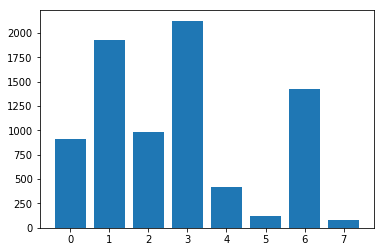

<BarContainer object of 8 artists>

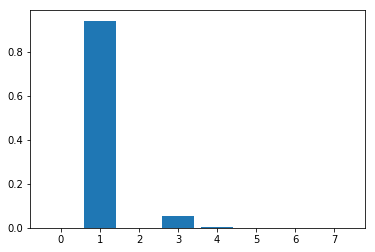

In [13]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=8,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = False 
logL_hists,i_r = gMixture_Global.multiples_run(5,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                               ,cluster=True)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

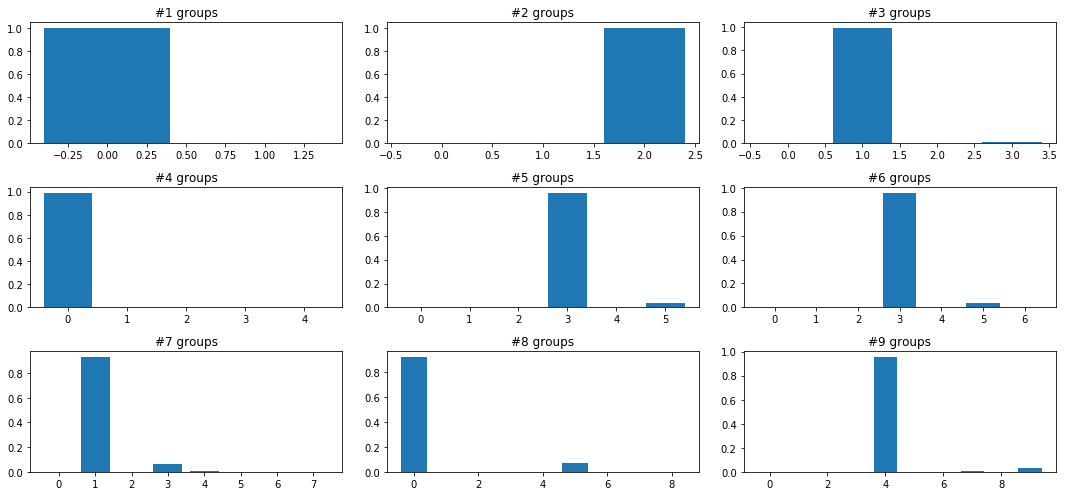

<Figure size 1080x360 with 0 Axes>

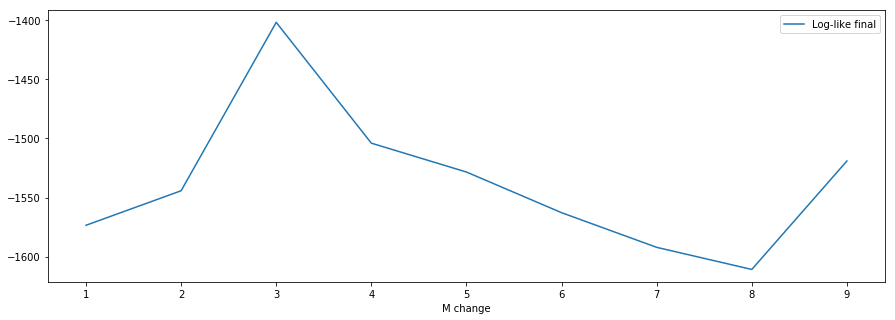

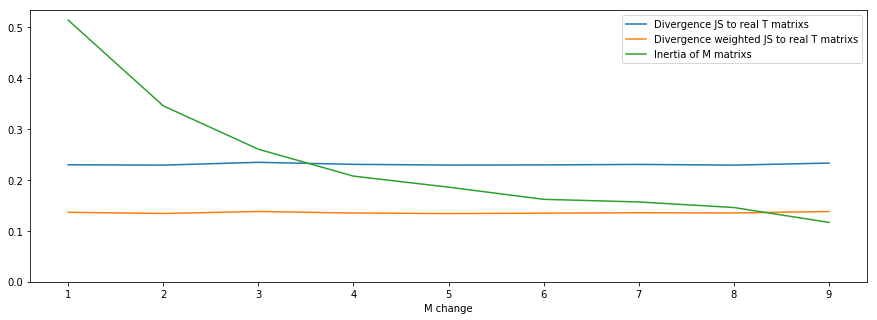

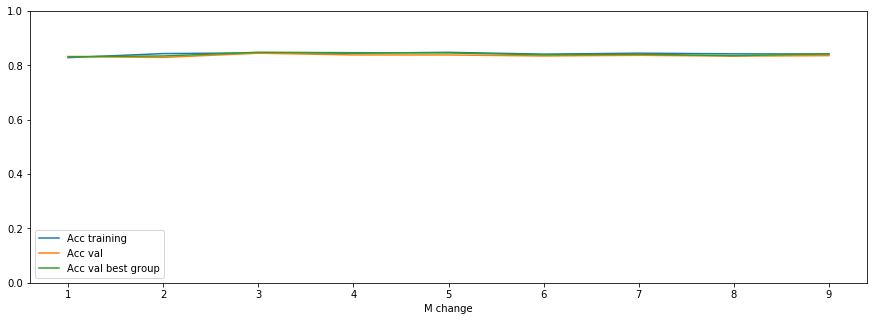

In [11]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

In [26]:
#T if i know T
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

,#Groups,>=1 annotator,>=2 annotator,Used on annotators,Used on annotators limit >=0.01,Used on annotators limit >=0.05
0,1,1,1,2,2,2
1,2,1,1,2,3,3
2,3,1,1,2,4,4
3,4,1,1,2,5,5
4,5,2,1,3,6,6
5,6,2,2,3,7,7
6,7,2,2,3,8,8
7,8,2,2,3,9,9
8,9,2,1,3,10,10


1 o 3...

In [20]:
M_seted = 3 #??

In [21]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = False 
logL_hists,i_r = gMixture_Global.multiples_run(30,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003525 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.78 sec)	logL: -2671.791	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2139.231	Tol1: 0.19933	Tol2: 0.29426	Tol3: 0.12989	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1926.640	Tol1: 0.09938	Tol2: 0.12377	Tol3: 0.23162	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1846.847	Tol1: 0.04142	Tol2: 0.07741	Tol3: 0.26193	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1790.266	Tol1: 0.03064	Tol2: 0.05691	Tol3: 0.27093	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1745.098	Tol1: 0.02523	Tol2: 0.03582	Tol3: 0.28715	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -17

M step: done,  E step: done //  (in 0.56 sec)	logL: -2801.787	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2072.379	Tol1: 0.26034	Tol2: 0.29586	Tol3: 0.06327	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1853.635	Tol1: 0.10555	Tol2: 0.14388	Tol3: 0.29270	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1738.245	Tol1: 0.06225	Tol2: 0.08484	Tol3: 0.30712	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1665.473	Tol1: 0.04187	Tol2: 0.05732	Tol3: 0.32969	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1608.988	Tol1: 0.03391	Tol2: 0.03644	Tol3: 0.34180	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1565.542	Tol1: 0.02700	Tol2: 0.02165	Tol3: 0.34663	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	

M step: done,  E step: done //  (in 0.07 sec)	logL: -1863.722	Tol1: 0.06382	Tol2: 0.10439	Tol3: 0.28630	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1784.441	Tol1: 0.04254	Tol2: 0.06353	Tol3: 0.30100	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.663	Tol1: 0.03350	Tol2: 0.04292	Tol3: 0.32044	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1685.840	Tol1: 0.02251	Tol2: 0.03387	Tol3: 0.33312	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1652.687	Tol1: 0.01967	Tol2: 0.01988	Tol3: 0.33695	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -2647.295	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2062.157	Tol1: 0.22103	Tol2: 0.26617	Tol3: 0.16803	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	

M step: done,  E step: done //  (in 0.69 sec)	logL: -2830.593	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2198.877	Tol1: 0.22317	Tol2: 0.30632	Tol3: 0.06252	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2010.845	Tol1: 0.08551	Tol2: 0.13742	Tol3: 0.22977	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1868.485	Tol1: 0.07080	Tol2: 0.08243	Tol3: 0.25608	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1770.376	Tol1: 0.05251	Tol2: 0.06962	Tol3: 0.28274	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1701.867	Tol1: 0.03870	Tol2: 0.04636	Tol3: 0.30414	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.848	Tol1: 0.02763	Tol2: 0.03040	Tol3: 0.32012	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1616.732	Tol1: 0.02303	Tol2: 0.02332	Tol3: 0.32573	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [16]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [101]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global       0.979         0.979
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.920875      0.920875
====  ======  ==========  ============


*** Soft-Majority (Train with softMV) ***
Train


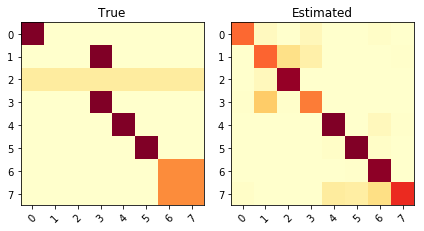

JS divergence: 0.6042	KL divergence: 3.2542


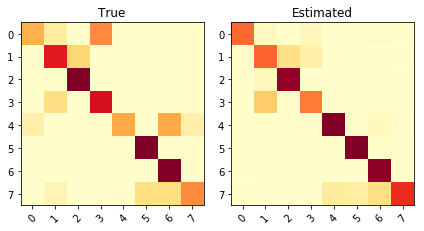

JS divergence: 0.3535	KL divergence: 0.9611


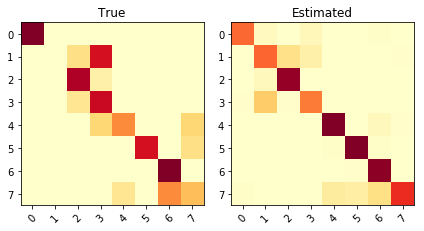

JS divergence: 0.4550	KL divergence: 1.7986


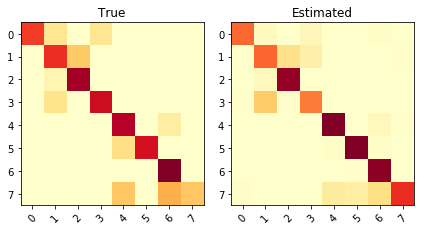

JS divergence: 0.3277	KL divergence: 0.6466


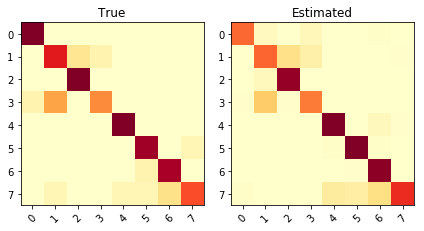

JS divergence: 0.4090	KL divergence: 1.0168


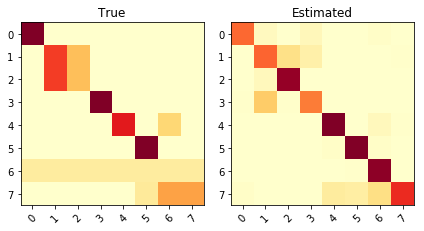

JS divergence: 0.4474	KL divergence: 2.0652


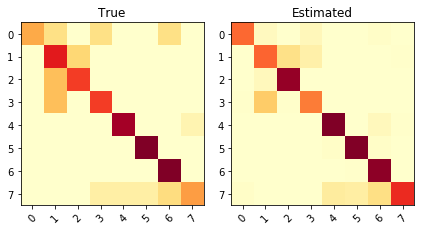

JS divergence: 0.3061	KL divergence: 0.7846


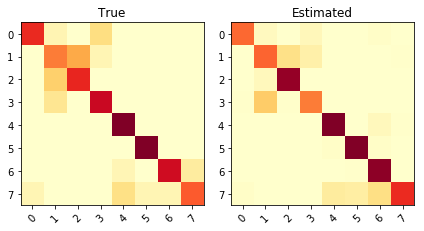

JS divergence: 0.3512	KL divergence: 0.9899


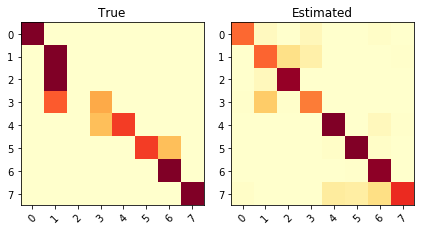

JS divergence: 0.5205	KL divergence: 1.5973


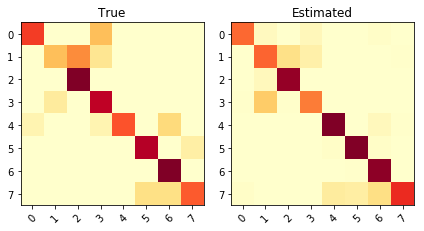

JS divergence: 0.3812	KL divergence: 1.1564


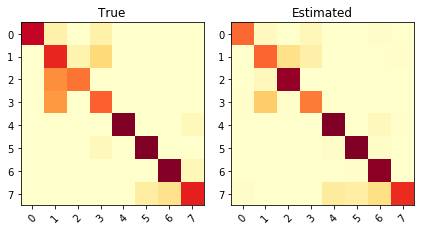

JS divergence: 0.3555	KL divergence: 0.8460


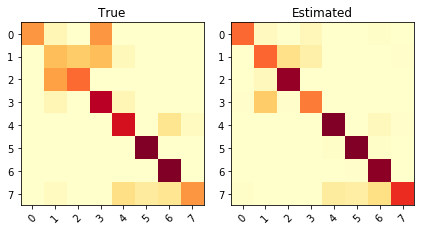

JS divergence: 0.2977	KL divergence: 0.8035


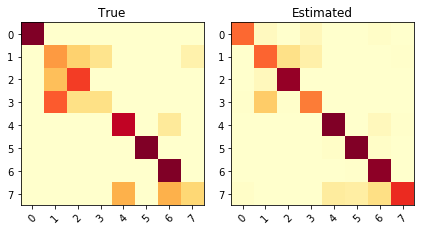

JS divergence: 0.3173	KL divergence: 0.6290


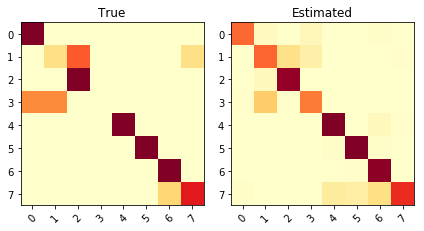

JS divergence: 0.4530	KL divergence: 0.8933


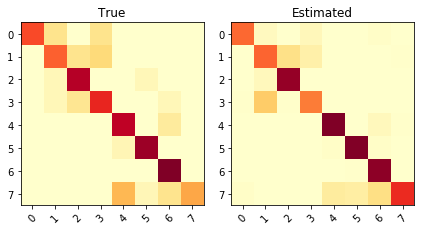

JS divergence: 0.3013	KL divergence: 0.7705
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.827         0.827    2.20961   0.445405     1.13939    0.390029
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.797138      0.797138
====  ======  ==========  ============


In [113]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


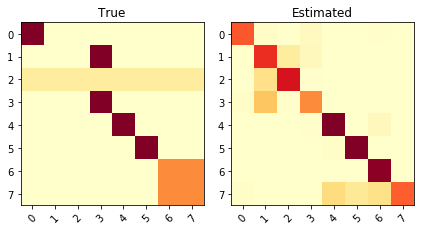

JS divergence: 0.5206	KL divergence: 2.8798


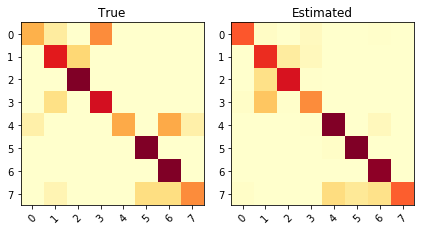

JS divergence: 0.3159	KL divergence: 1.0400


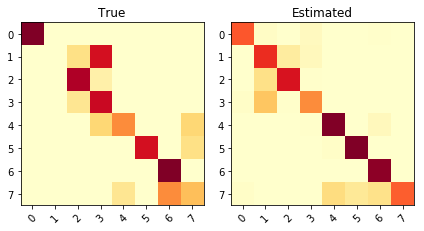

JS divergence: 0.3694	KL divergence: 1.4746


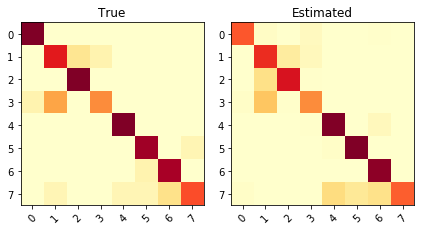

JS divergence: 0.3722	KL divergence: 1.0621


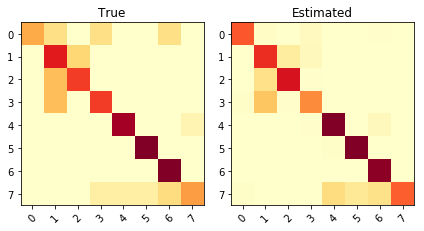

JS divergence: 0.2662	KL divergence: 0.8170


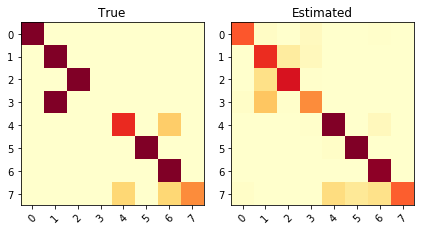

JS divergence: 0.4239	KL divergence: 0.8416


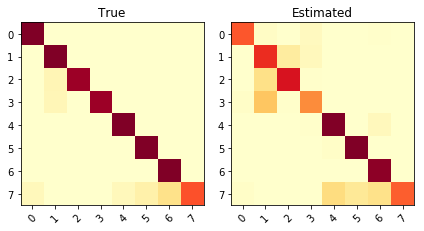

JS divergence: 0.4185	KL divergence: 0.8484


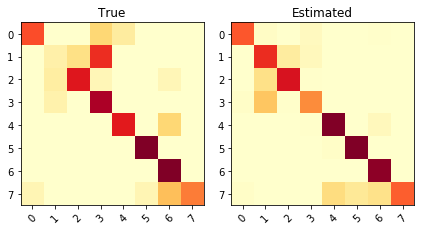

JS divergence: 0.2880	KL divergence: 0.8640


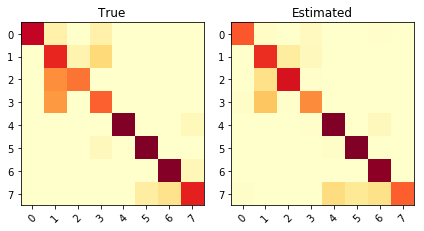

JS divergence: 0.3112	KL divergence: 0.8194


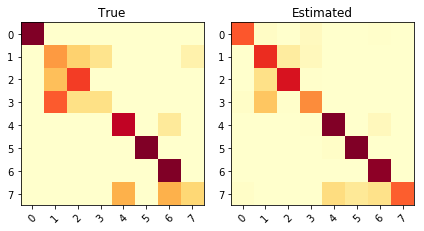

JS divergence: 0.2792	KL divergence: 0.6896


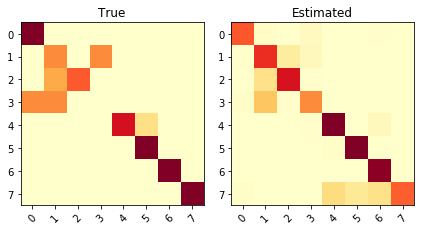

JS divergence: 0.4106	KL divergence: 1.1294


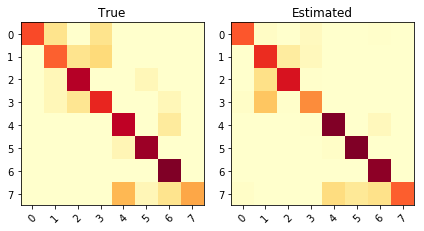

JS divergence: 0.2383	KL divergence: 0.6479


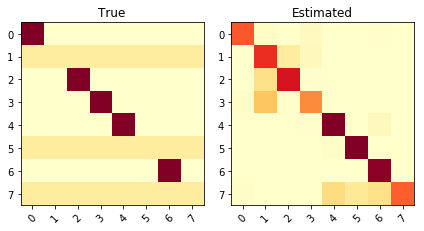

JS divergence: 0.4945	KL divergence: 3.7924


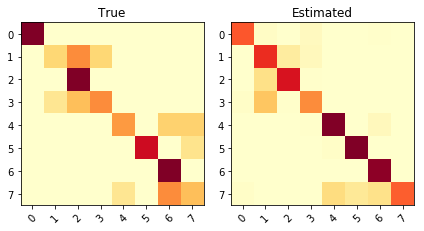

JS divergence: 0.3226	KL divergence: 1.3867


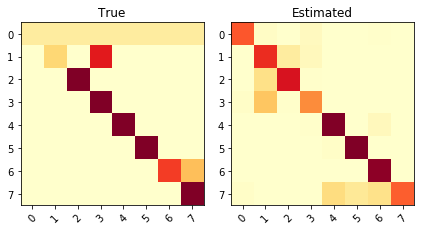

JS divergence: 0.4805	KL divergence: 2.3156
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.812         0.812    2.33873   0.415067     1.16027    0.343895
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.792088      0.792088
====  ======  ==========  ============


In [114]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


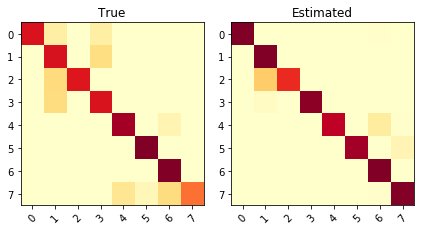

JS divergence: 0.0758	KL divergence: 1.0693


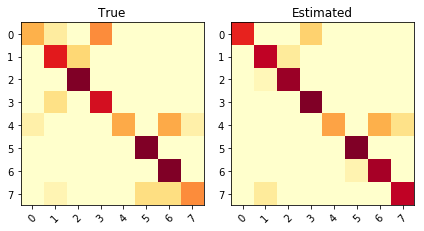

JS divergence: 0.0800	KL divergence: 1.3788


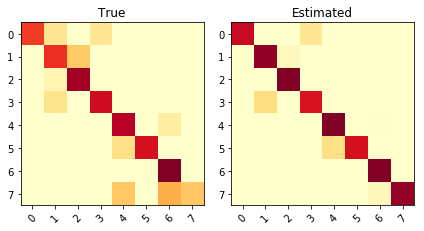

JS divergence: 0.0825	KL divergence: 1.1107


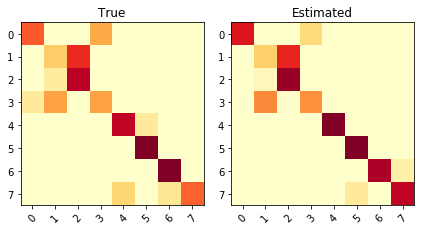

JS divergence: 0.0674	KL divergence: 1.2312


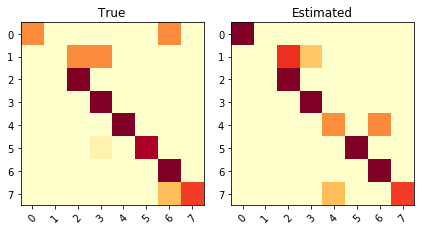

JS divergence: 0.1301	KL divergence: 1.7914


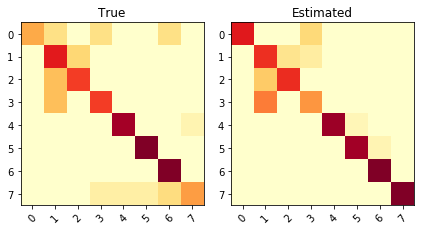

JS divergence: 0.0988	KL divergence: 1.3245


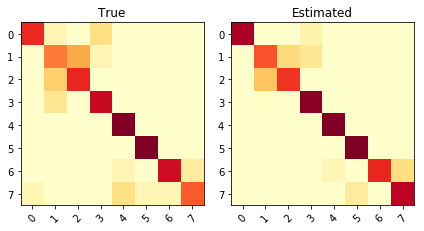

JS divergence: 0.0437	KL divergence: 0.4704


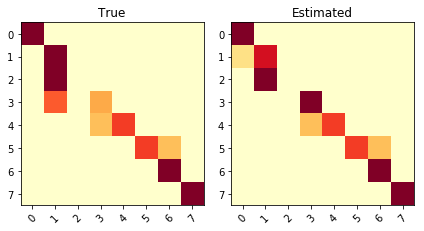

JS divergence: 0.0632	KL divergence: 0.9011


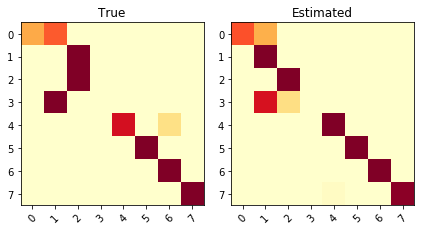

JS divergence: 0.1585	KL divergence: 2.3995


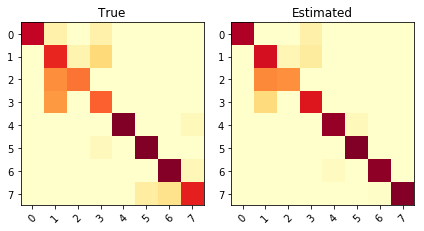

JS divergence: 0.0431	KL divergence: 0.5730


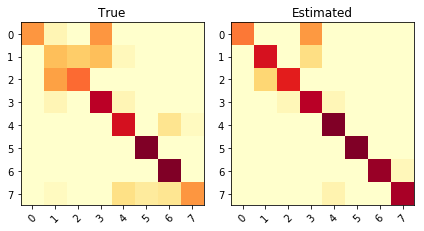

JS divergence: 0.0925	KL divergence: 1.2764


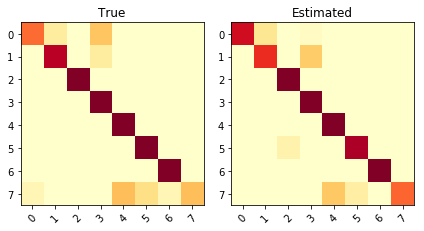

JS divergence: 0.0371	KL divergence: 0.3051


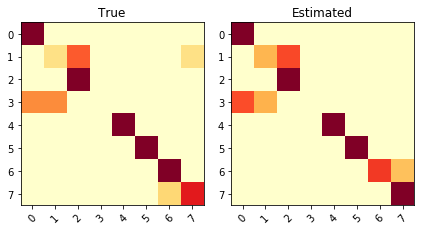

JS divergence: 0.0567	KL divergence: 0.8301


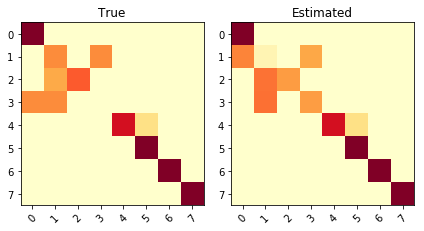

JS divergence: 0.1099	KL divergence: 1.0951


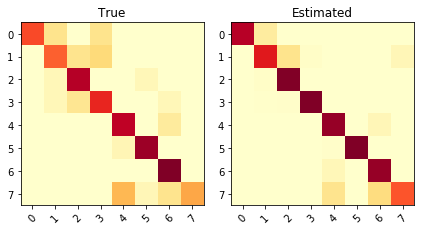

JS divergence: 0.0650	KL divergence: 0.7362
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.851         0.851    1.67215    0.16081     1.08425   0.0850474
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.819865      0.819865
====  ======  ==========  ============


In [23]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


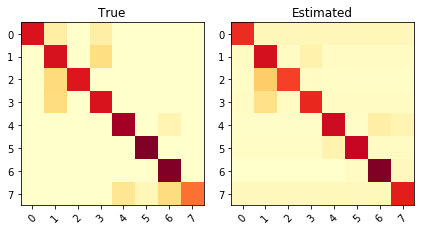

JS divergence: 0.1763	KL divergence: 0.3824


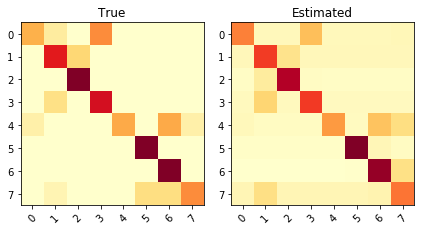

JS divergence: 0.2303	KL divergence: 0.5073


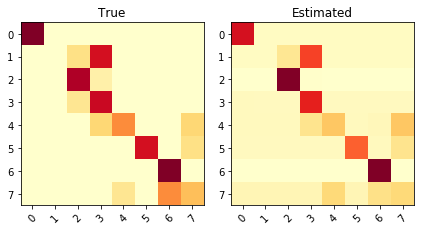

JS divergence: 0.2640	KL divergence: 0.5862


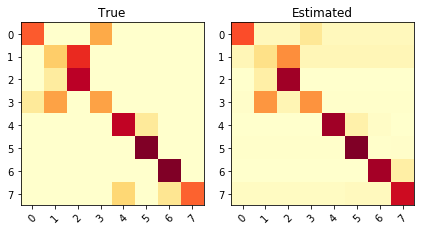

JS divergence: 0.2461	KL divergence: 0.5448


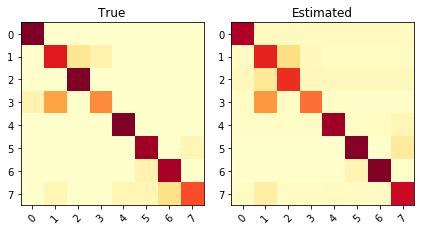

JS divergence: 0.1913	KL divergence: 0.4172


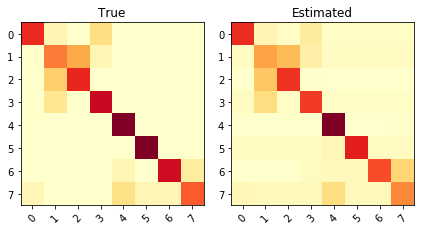

JS divergence: 0.1530	KL divergence: 0.3284


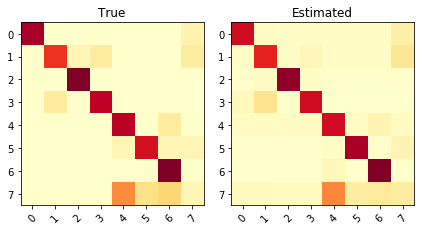

JS divergence: 0.1536	KL divergence: 0.3270


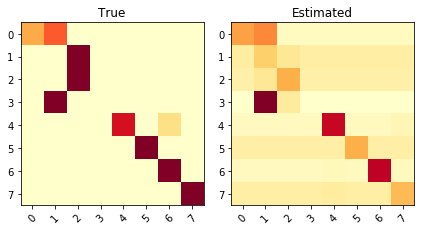

JS divergence: 0.4771	KL divergence: 1.2062


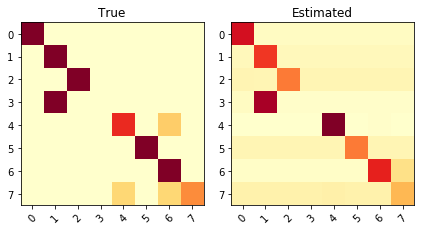

JS divergence: 0.3994	KL divergence: 0.9392


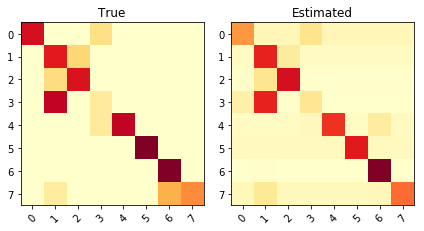

JS divergence: 0.2543	KL divergence: 0.5691


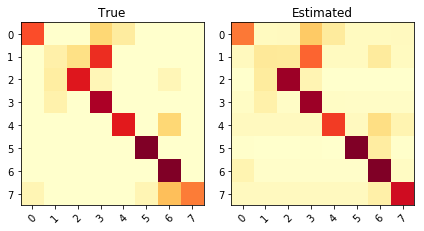

JS divergence: 0.1883	KL divergence: 0.4109


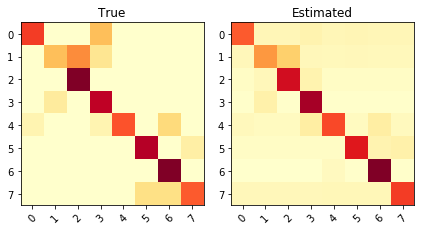

JS divergence: 0.2042	KL divergence: 0.4517


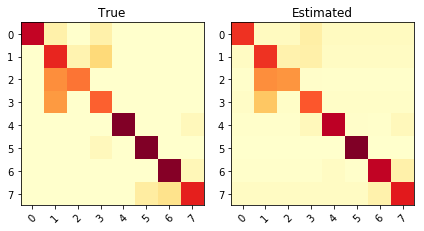

JS divergence: 0.1352	KL divergence: 0.2877


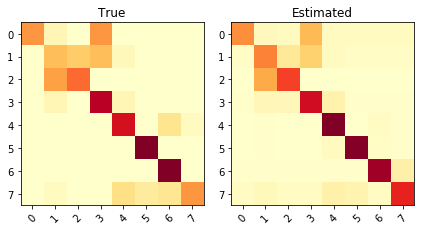

JS divergence: 0.1176	KL divergence: 0.2601


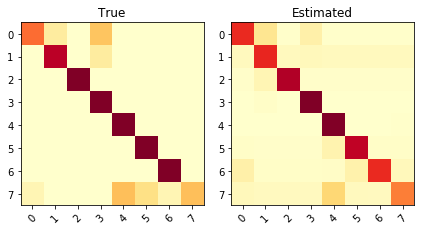

JS divergence: 0.2167	KL divergence: 0.4764
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global       0.854         0.854   0.707193     0.2941    0.541393    0.237015    0.0649323     0.0557519
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                   0.83947                1.1736               

In [13]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
project confusion matrices